In [1]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *

#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scienceplots
import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use(['science', 'no-latex'])
%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', 'X', '+', '*']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')


../results/HEISENBERG/disorder/PBC/


In [3]:
from scipy import sparse
from numpy import array
I = array([0,3,1,0])
J = array([0,3,1,2])
V = array([4,5,7,9])
A = sparse.coo_matrix((V,(I,J)),shape=(4,4)).todense()
print(np.array(A))

[[4 0 9 0]
 [0 7 0 0]
 [0 0 0 0]
 [0 0 0 5]]


In [2]:
def page(L, f):    
    return f * L * np.log(2) - binom(2 * f * L, f * L) / binom(L, L/2) / 2

def page_result(L_a, L_b):
    d_a = 2**L_a
    d_b = 2**L_b
    return digamma(d_a * d_b + 1) - digamma(d_b + 1) - (d_a - 1) / (2*d_b)

def page_result_su(L_a, L_b):
    d_a = binom(L_a, L_b)
    d_b = binom(L_b, L_b)
    return digamma(d_a * d_b + 1) - digamma(d_b + 1) - (d_a - 1) / (2*d_b)
    

def page_result_var(d_a, d_b):
    return (((d_a + d_b)/(d_a*d_b + 1.0)) * polygamma(1, d_b + 1)) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2.0 * d_b - 1.0))/(4.0 * d_b * d_b * (d_a * d_b  + 1.0))

def page_thermodynamic(f, L):
    return f * L * np.log(2.) - np.power(2., -np.abs(1.-2.*f)*L - 1.0)

def page_thermodynamic_var(f, L):
    return (1/2 - 1/4 * (1.0 if f == 1/2 else 0.0)) * np.power(2., -(1+np.abs(1-2*f))*L)

def Srand(L, f): 
    return page(L, f) + (f + np.log(1-f)) / 2. 

In [3]:

L=18
J=2.
J0=0.5
g=0.3
g0=0.3
h=0.6
w=0.1
k=1
p=1
x=1
if h > 0: x=1
dir_pbc = "../results/XYZ/symmetries/PBC/Entropy/Eigenstate/"
dir_obc = "../results/XYZ/symmetries/OBC/Entropy/Eigenstate/"
f = 1/2.
use_Sz_sym = False
scan_lab = r"$\Delta_1$" if use_Sz_sym else r"$h^z$" 
suff = "_su" if use_Sz_sym else ""

h_plot = [0.2, 0.8, 1.6, 2.0]
x_range = hfun.regspace(0.1, 2.1, 0.1)
J_range = hfun.regspace(0.1, 2.1, 0.1)

spin_flip_sectors = [-1, 1] if use_Sz_sym else [1]
parity_sectors = [-1, 1]

def get_sectors(L, use_Sz_sym = False):
    translation_real_sectors = [0, L // 2]
    translation_imag_sectors = range(1, L // 2)

    real_sectors = [[ks, ps, xs] for ks in translation_real_sectors for ps in parity_sectors for xs in spin_flip_sectors]
    imag_sectors = [[kx, 1, x_sym] for kx in translation_imag_sectors for x_sym in spin_flip_sectors]
    return real_sectors, imag_sectors

real_sectors, imag_sectors = get_sectors(L)
print(real_sectors, imag_sectors)
all_sectors = real_sectors + imag_sectors

[[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1]] [[1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]


In [34]:

def get_data(L, J, xx, ksym, psym, xsym, use_Sz_sym = False, get_states = True, plot_abs = False):
    info = hfun.info_sym(L, J, xx, h, ksym, psym, xsym) if use_Sz_sym else hfun.info_sym(L, J, g, xx, ksym, psym, xsym)
    info = dir_pbc + info[0 : info.index('.dat')]

    filename = info + "_subsize=%d.hdf5"%(f * L)
    if exists(filename) and abs(int(f * L) - f * L) < 0.01:
        data = []
        with h5py.File(filename, "r") as file:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            #print(info, "Keys: %s" % file.keys())
            energies = np.array(file.get('energies')[0])
            entropy = np.array(file.get('entropy')[0])
            dim = energies.size
            V = []
            if len(file.keys()) > 2 and get_states: 
                Vfull = None
                #if ksym == 0 or ksym == L//2:   Vfull = np.array(file.get('eigenvectors'))
                #else:                           
                if len(energies) > 80000: Vfull = np.array(file.get('eigenvectors'))#.view('complex')
                else: Vfull = np.array(file.get('eigenvectors')).view('complex')
                szejp = Vfull.shape
                V = Vfull.flatten()
                
                var_theory = 2 * dim if ksym == 0 or ksym == L // 2 else dim
                #print(J, xx, "\t", ksym, "\t", psym, "\t", szejp, "\t", 1./var_theory - np.var(Vfull))
                if plot_abs:
                    V *= np.sqrt(var_theory)
                else:
                    if any(V.imag > 1e-10): 
                        V = np.array(list(V.real / np.sqrt(np.var(V.real)) ) + list(V.imag / np.sqrt(np.var(V.imag))) )
                    else:                  
                        V = V.real / np.sqrt(np.var(V.real))

        return True, energies, entropy, np.abs(V)
    else:
        #print(filename)
        return False, np.array([]), np.array([]), np.array([])

In [35]:

def get_data_obc(L, J, xx, psym, xsym, use_Sz_sym = False, which = 1, get_states = True):
    info = hfun.info_sym(L, J, xx, h, 0, psym, xsym) if use_Sz_sym else hfun.info_sym(L, J, g, xx, 0, psym, xsym)
    info = dir_obc + info[0 : info.index('.dat')]

    filename = info + "_subsize=%d.hdf5"%(f * L)
    if exists(filename) and abs(int(f * L) - f * L) < 0.01:
        data = []
        with h5py.File(filename, "r") as file:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            #print(info, "Keys: %s" % file.keys())
            energies = np.array(file.get('energies')[0])
            entropy = np.array(file.get('entropy')[0])
            dim = energies.size
            V = []
            if len(file.keys()) > 2 and get_states: 
                #Vfull = np.array(file.get('eigenvectors'))#.view('complex')
                if len(energies) > 80000: Vfull = np.array(file.get('eigenvectors'))#.view('complex')
                else: Vfull = np.array(file.get('eigenvectors')).view('complex')
                szejp = Vfull.shape
                V = Vfull.flatten()
                
                #print(J, xx, "\t", psym, "\t", szejp, "\t", 1./dim - np.var(Vfull))

        return True, energies, entropy, np.abs(V) * np.sqrt(dim)
    else:
        #print(filename)
        return False, np.array([]), np.array([]), np.array([])

# PARAMETER SCAN

### PREAMBLE CRAP

- gap ratio masz wartości jak entro plus histogramy w formacie jeden row bins i jeden hist

- size_scale_all params masz podzielone na nu i wewnątrz są size scale dla różnych parametrów w formacie albo csv albo npy. Jest jeszcze dodatkowy folder na wszystkie sektory - tak informacyjnie jakby ktoś kiedyś chciał

- size_scale_nu - tam są gotowe do size scale dla j2=2 i d1 = 0.6

- state_dist_chi_im - chi distribution do imaginary 

- state_dist_chi_re - gauss w sumie, ale odpowiada lewemu plotowi jak robimy chi histogram 

- state_dist_gauss - to samo tylko wszystko zjedzone do jednego wykresu gauss

- w kazdych z histogramowych folderów jest po jednym pliku numpy w formacie kolumn [delta_1, J2, gaussianity]

In [87]:
def read_maks_gaussianity(J2):
        with open(f'MAXIMAL_ENTROPY_DATA/SU/state_dist_gauss/su_states_all_gauss_L=20.npy', 'rb') as file:
                data = np.load(file, allow_pickle=True)
                gauss = []
                for [delta, Jx, G] in data:
                        if Jx == J2: gauss.append(G)
                return np.array(gauss)

def read_maks_gaussianity_abs(J2, sector = 're'):
        suffix_of_hell_cause_live_dont_matter = '_chi' if sector == 'im' else ''
        with open(f'MAXIMAL_ENTROPY_DATA/SU/state_dist_chi_{sector}/su_states_{sector}{suffix_of_hell_cause_live_dont_matter}_gauss_L=20.npy', 'rb') as file:
                data = np.load(file, allow_pickle=True)
                gauss = []
                for [delta, Jx, G] in data:
                        if Jx == J2: gauss.append(G)
                return np.array(gauss)

"""
Read eigenstates distributions from Maks weird dataformats
"""
def read_maks_distributions(J2, delta):
        with open(f'MAXIMAL_ENTROPY_DATA/SU/state_dist_gauss/su_states_all_hist_L=20,J2={J2},d1={delta}.npy', 'rb') as file:
                data = np.load(file, allow_pickle=True)
                
                return np.array(data[0]), np.array(data[1])

def read_maks_distributions_abs(J2, delta, sector = 're'):
        some_weird_number_no_idea_why_the_fuck = 0 if sector == 're' else 1
        with open(f'MAXIMAL_ENTROPY_DATA/SU/state_dist_chi_{sector}/su_states_{some_weird_number_no_idea_why_the_fuck}_chi_hist_L=20,J2={J2},d1={delta}.npy', 'rb') as file:
                data = np.load(file, allow_pickle=True)
                return np.array(data[0]), np.array(data[1])


xx	k	p	shape		var diff
1.0 0.1 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1], [1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]
1.0 0.2 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1], [1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]
1.0 0.3 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1], [1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]
1.0 0.4 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1], [1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]
1.0 0.5 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1], [1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]
1.0 0.6 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1], [1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]
1.0 0.7 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1], [1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1]

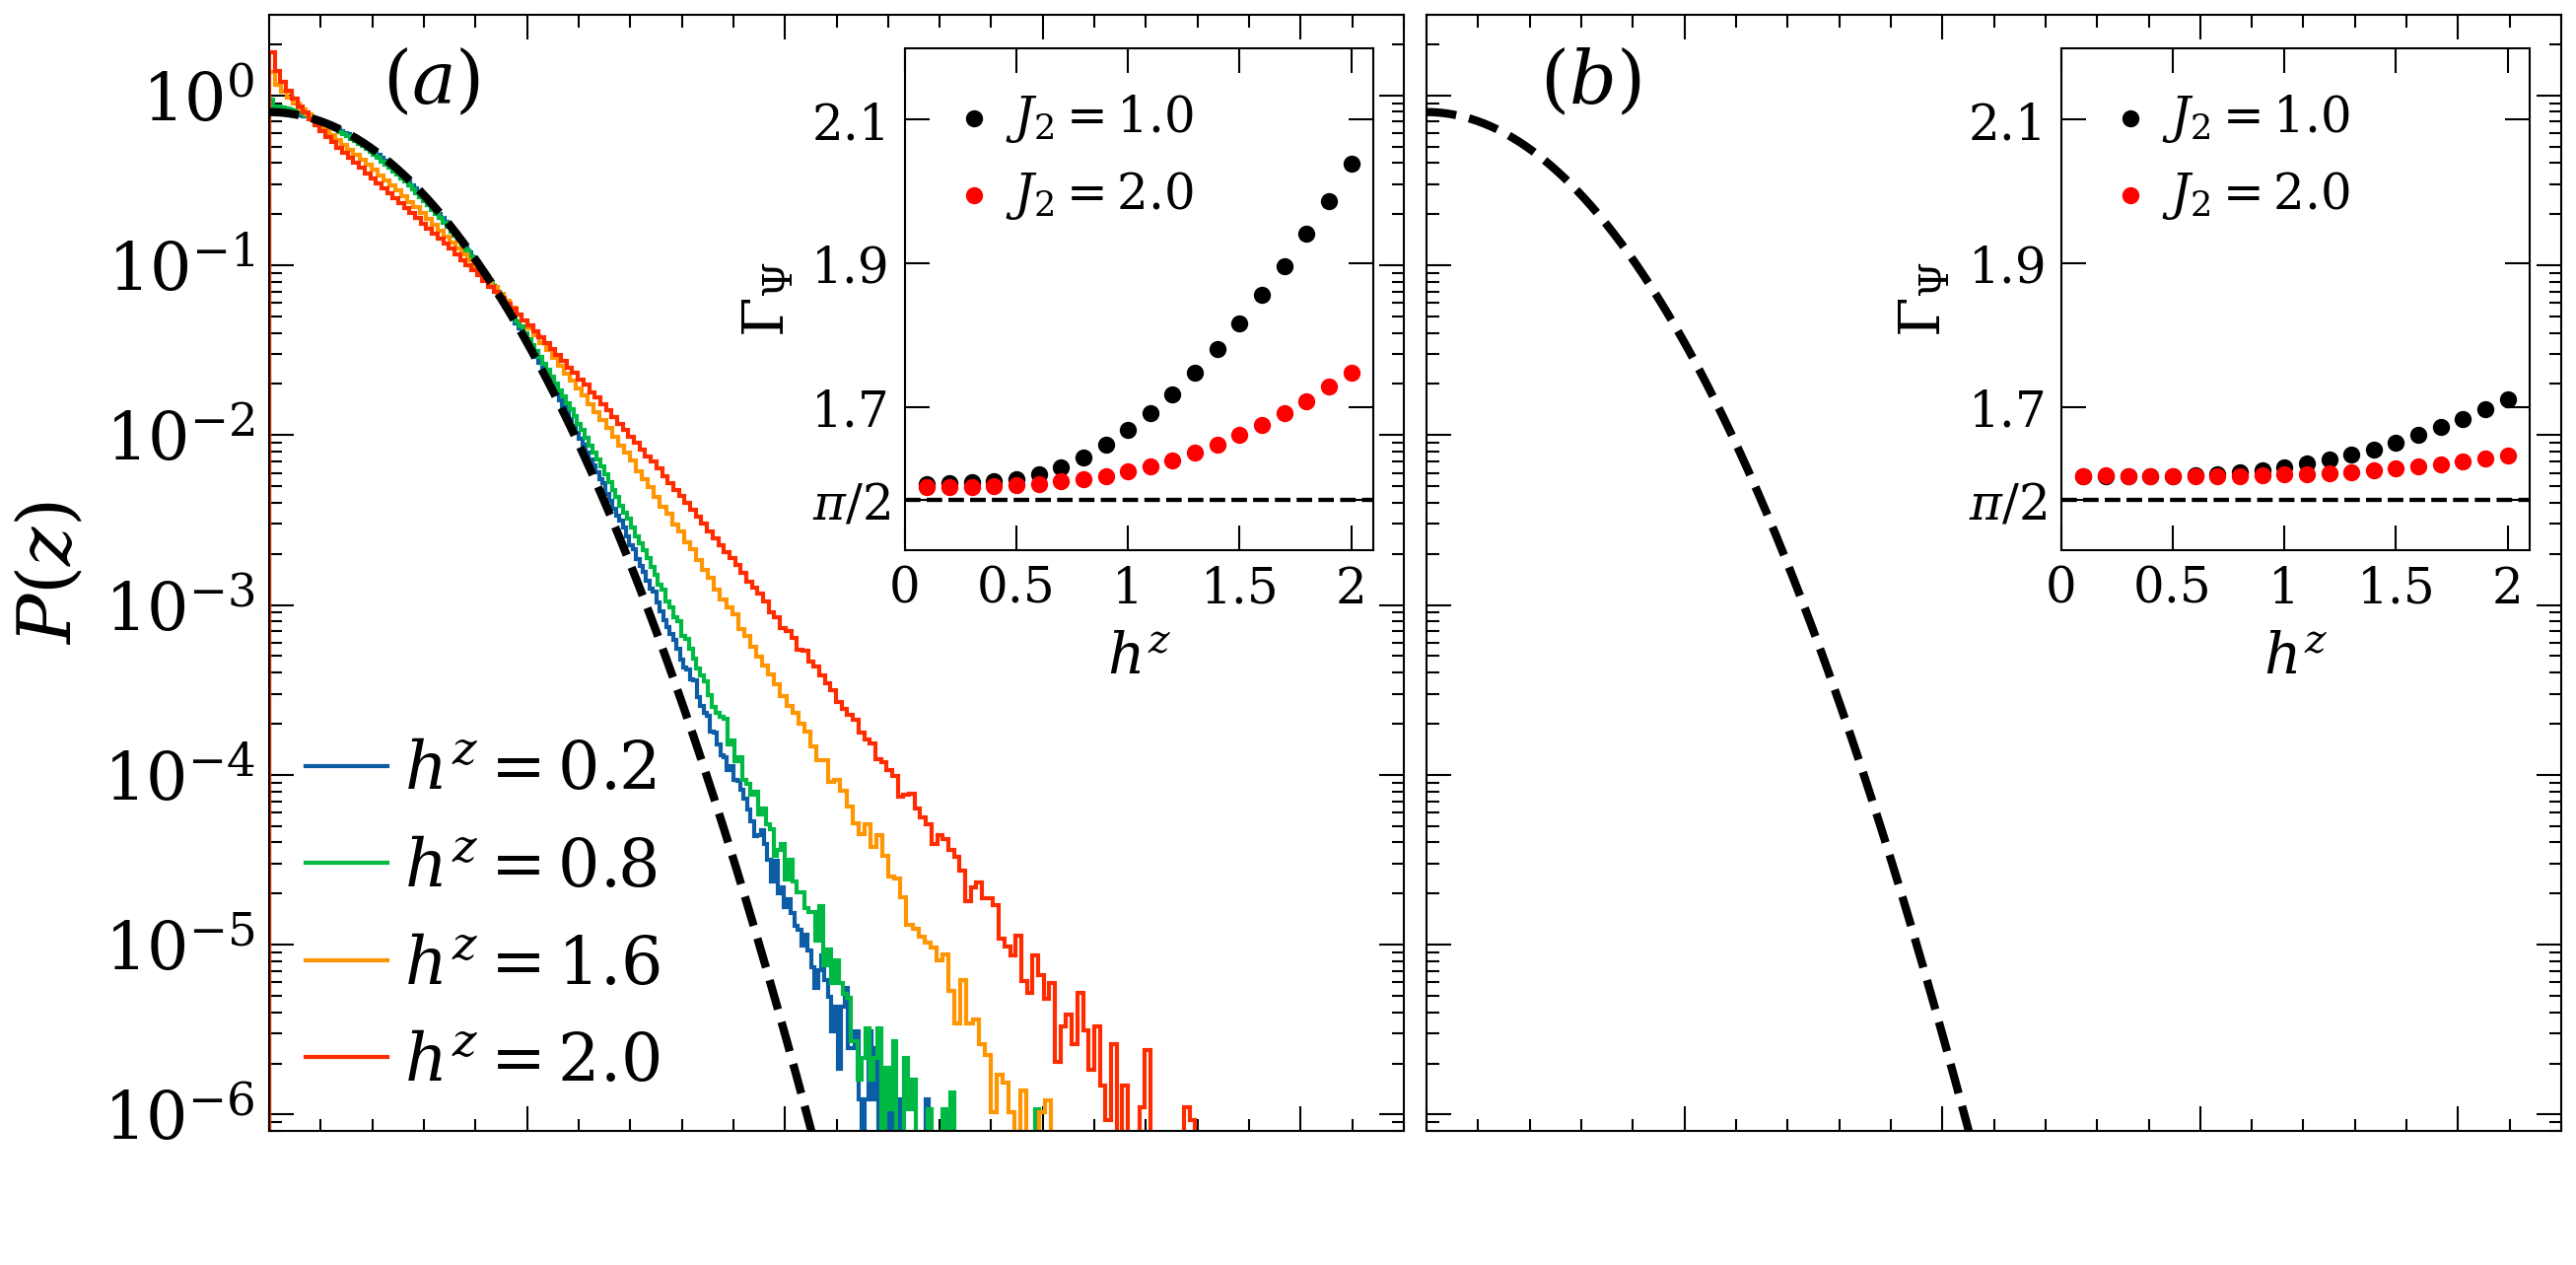

In [419]:
reload_modules()

plot_abs = False
suff = "_abs" if plot_abs else ""
NCOLS = 2
NROWS = 2 if plot_abs else 1
space=0.02

num_of_subplots = NROWS * NCOLS
fig_dist, ax_dist = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(5 * (NCOLS / NROWS),5), dpi = 300, sharex=True, sharey=True)
ax_dist = np.array(ax_dist).flatten()


real_sectors, imag_sectors = get_sectors(L)

width = 0.45
height = 0.45

print("xx\tk\tp\tshape\t\tvar diff")

points = [[1.0, haha] for haha in x_range] + [[2.0, haha] for haha in x_range]
colors = ['red', 'black']
def plotter(which):
    delY = (which // NCOLS) * 0.18 / NROWS
    delX = np.abs(which % NCOLS - NCOLS + 1) * 0.18 / NCOLS
    ax_inset = hfun.add_subplot_axes(ax_dist[which], [delX + 0.97 - width, delY + 0.97 - height, width, height])
    ax_all = [ax_inset, ax_dist[which]]
    if plot_abs:
        suff = "_abs_re" if which == 0 else "_abs_im"
        if which > 1:
            suff += "_su"
        sectors = real_sectors if which == 0 else imag_sectors
    else: 
        suff = "" if which == 0 else "_su"
        sectors = real_sectors + imag_sectors
    gap_ratio = []
    gauss = []
    for J in [1.0, 2.0]:
        gaussianity = []
        if which < 1:
            filename_gauss = f'MAXIMAL_ENTROPY_DATA/Gaussianity_J2={J}.npy'
            for xx in x_range:
                wx = xx/2
                Smean_ener = []
                Smax = []
                validL = []
                coeffs = []
                filename_dist = f'MAXIMAL_ENTROPY_DATA/Distribution_J2={J},hz={xx}.npy'
                hist = []
                edge = []
                print(J, xx, sectors)
                for [ks, ps, xs] in sectors:
                    status, energies, entropy, V = get_data(L=L, J=J, xx=xx, ksym = ks, psym = ps, xsym=xs, plot_abs=plot_abs)
                    if status:
                        factor = 1 if ks == 0 or ks == L // 2 else 2
                        coeffs += factor * list(V)

                coeffs = np.array(coeffs)
                if xx in h_plot and J == 1.0:
                    hist, edge = np.histogram(coeffs, bins=200, normed=True)
                    data = []
                    data.append(np.array(edge))
                    data.append(np.array(hist))
                    with open(filename_dist, 'wb') as file: np.save(file, np.array(data))
            
                    ax_dist[which].stairs(hist, edge, label=scan_lab + r"$=%.1f$"%(xx))

                coeffs = np.abs(coeffs)
                gaussianity.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2)
            with open(filename_gauss, 'wb') as file: 
                np.save(file, np.array(gaussianity))
        else:
            gaussianity = read_maks_gaussianity(J2 = J)

        ax_inset.scatter(x_range, gaussianity, s=10, label=r"$J_2=%.1f$"%(J), color='black' if J == 1.0 else 'red')


    ylab = "P(z)" if which == 0 else "\ "
    xlab = "z=\\sigma|c_n|" if which > 1 else "\ "
    hfun.set_plot_elements(axis = ax_dist[which], ylabel = ylab, xlabel = xlab, settings=user_settings, 
                                font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    if which == 0:
        ax_dist[which].legend(loc = 'lower left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, -0.02))




    val = np.pi / 2 if which == 0 or not plot_abs else 4. / np.pi
    valname = r"$\pi/2$" if which == 0 or not plot_abs else r"$4/\pi$"
    
    ax_inset.axhline(y=val, ls='--', color='black')

    hfun.set_plot_elements(axis = ax_inset, ylabel = "\\Gamma_\\Psi", xlabel = "\\Delta_1" if use_Sz_sym else "h^z", settings=user_settings, 
                            font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax_inset.legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)
    ax_inset.set_xlim(0, 2.1)
    
    for ax in list(ax_all):
        ax.set_xscale('linear')    
        ax.set_yscale('linear')
        ax.tick_params(axis="both",which='major',direction="in",length=6)
        ax.tick_params(axis="both",which='minor',direction="in",length=3)

    ax_inset.axhline(y=val, ls='--', color='black')
    yticks = [val, 1.7, 1.9, 2.1] if which == 0 or not plot_abs else [val, 1.4, 1.5, 1.6]   
    tick_labels = ["%.1f"%ytic if ytic != val else valname for ytic in yticks]
    ax_inset.set_yticks(yticks)
    ax_inset.set_yticklabels(tick_labels)
    if plot_abs:
        if which == 0:  ax_inset.set_ylim(1.5, 2.2)
        else:           ax_inset.set_ylim(1.2, 1.7)
    else:
        ax_inset.set_ylim(1.5, 2.2)
#
    xticks = [0, 0.5, 1.0, 1.5, 2.0]
    tick_labels = ["%.1f"%xtic if xtic not in [0, 1, 2] else "%d"%xtic for xtic in xticks]
    ax_inset.set_xticks(xticks)
    ax_inset.set_xticklabels(tick_labels)
    ax_inset.xaxis.set_minor_locator(plt.NullLocator())
    ax_inset.yaxis.set_minor_locator(plt.NullLocator())


    ax_dist[which].set_xscale('linear')
    ax_dist[which].set_yscale('log')
    aa = np.linspace(-100.0, 100, 20000)
    mu=0.0
    sigma=1.
    ax_dist[which].set_ylim(8e-7, 3.0)
    ax_dist[which].set_xlim(0, 11)
    ax_dist[which].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    #ax_dist[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))

    if which == 0 or not plot_abs:    
        ax_dist[which].plot(aa, 2. / np.sqrt(2*np.pi) * np.exp( - (aa)**2 / (2)), linestyle='--', color='black', linewidth=2)
    else:             
        ax_dist[which].plot(aa, aa * np.exp( - aa**2 / (2)), linestyle='--', color='black', lw=2)


plotter(0)
plotter(1)
ax_dist[0].annotate(r"$(a)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')
ax_dist[1].annotate(r"$(b)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')
if plot_abs:
    plotter(2)
    plotter(3)
    ax_dist[2].annotate(r"$(c)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')
    ax_dist[3].annotate(r"$(d)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')


fig_dist.subplots_adjust(wspace=space, hspace=space)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_coeff{suff}.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_coeff{suff}.png', bbox_inches = 'tight', padding=0.02)


### PLOT GAUSSIANS

xx	k	p	shape		var diff
20
20
20
20


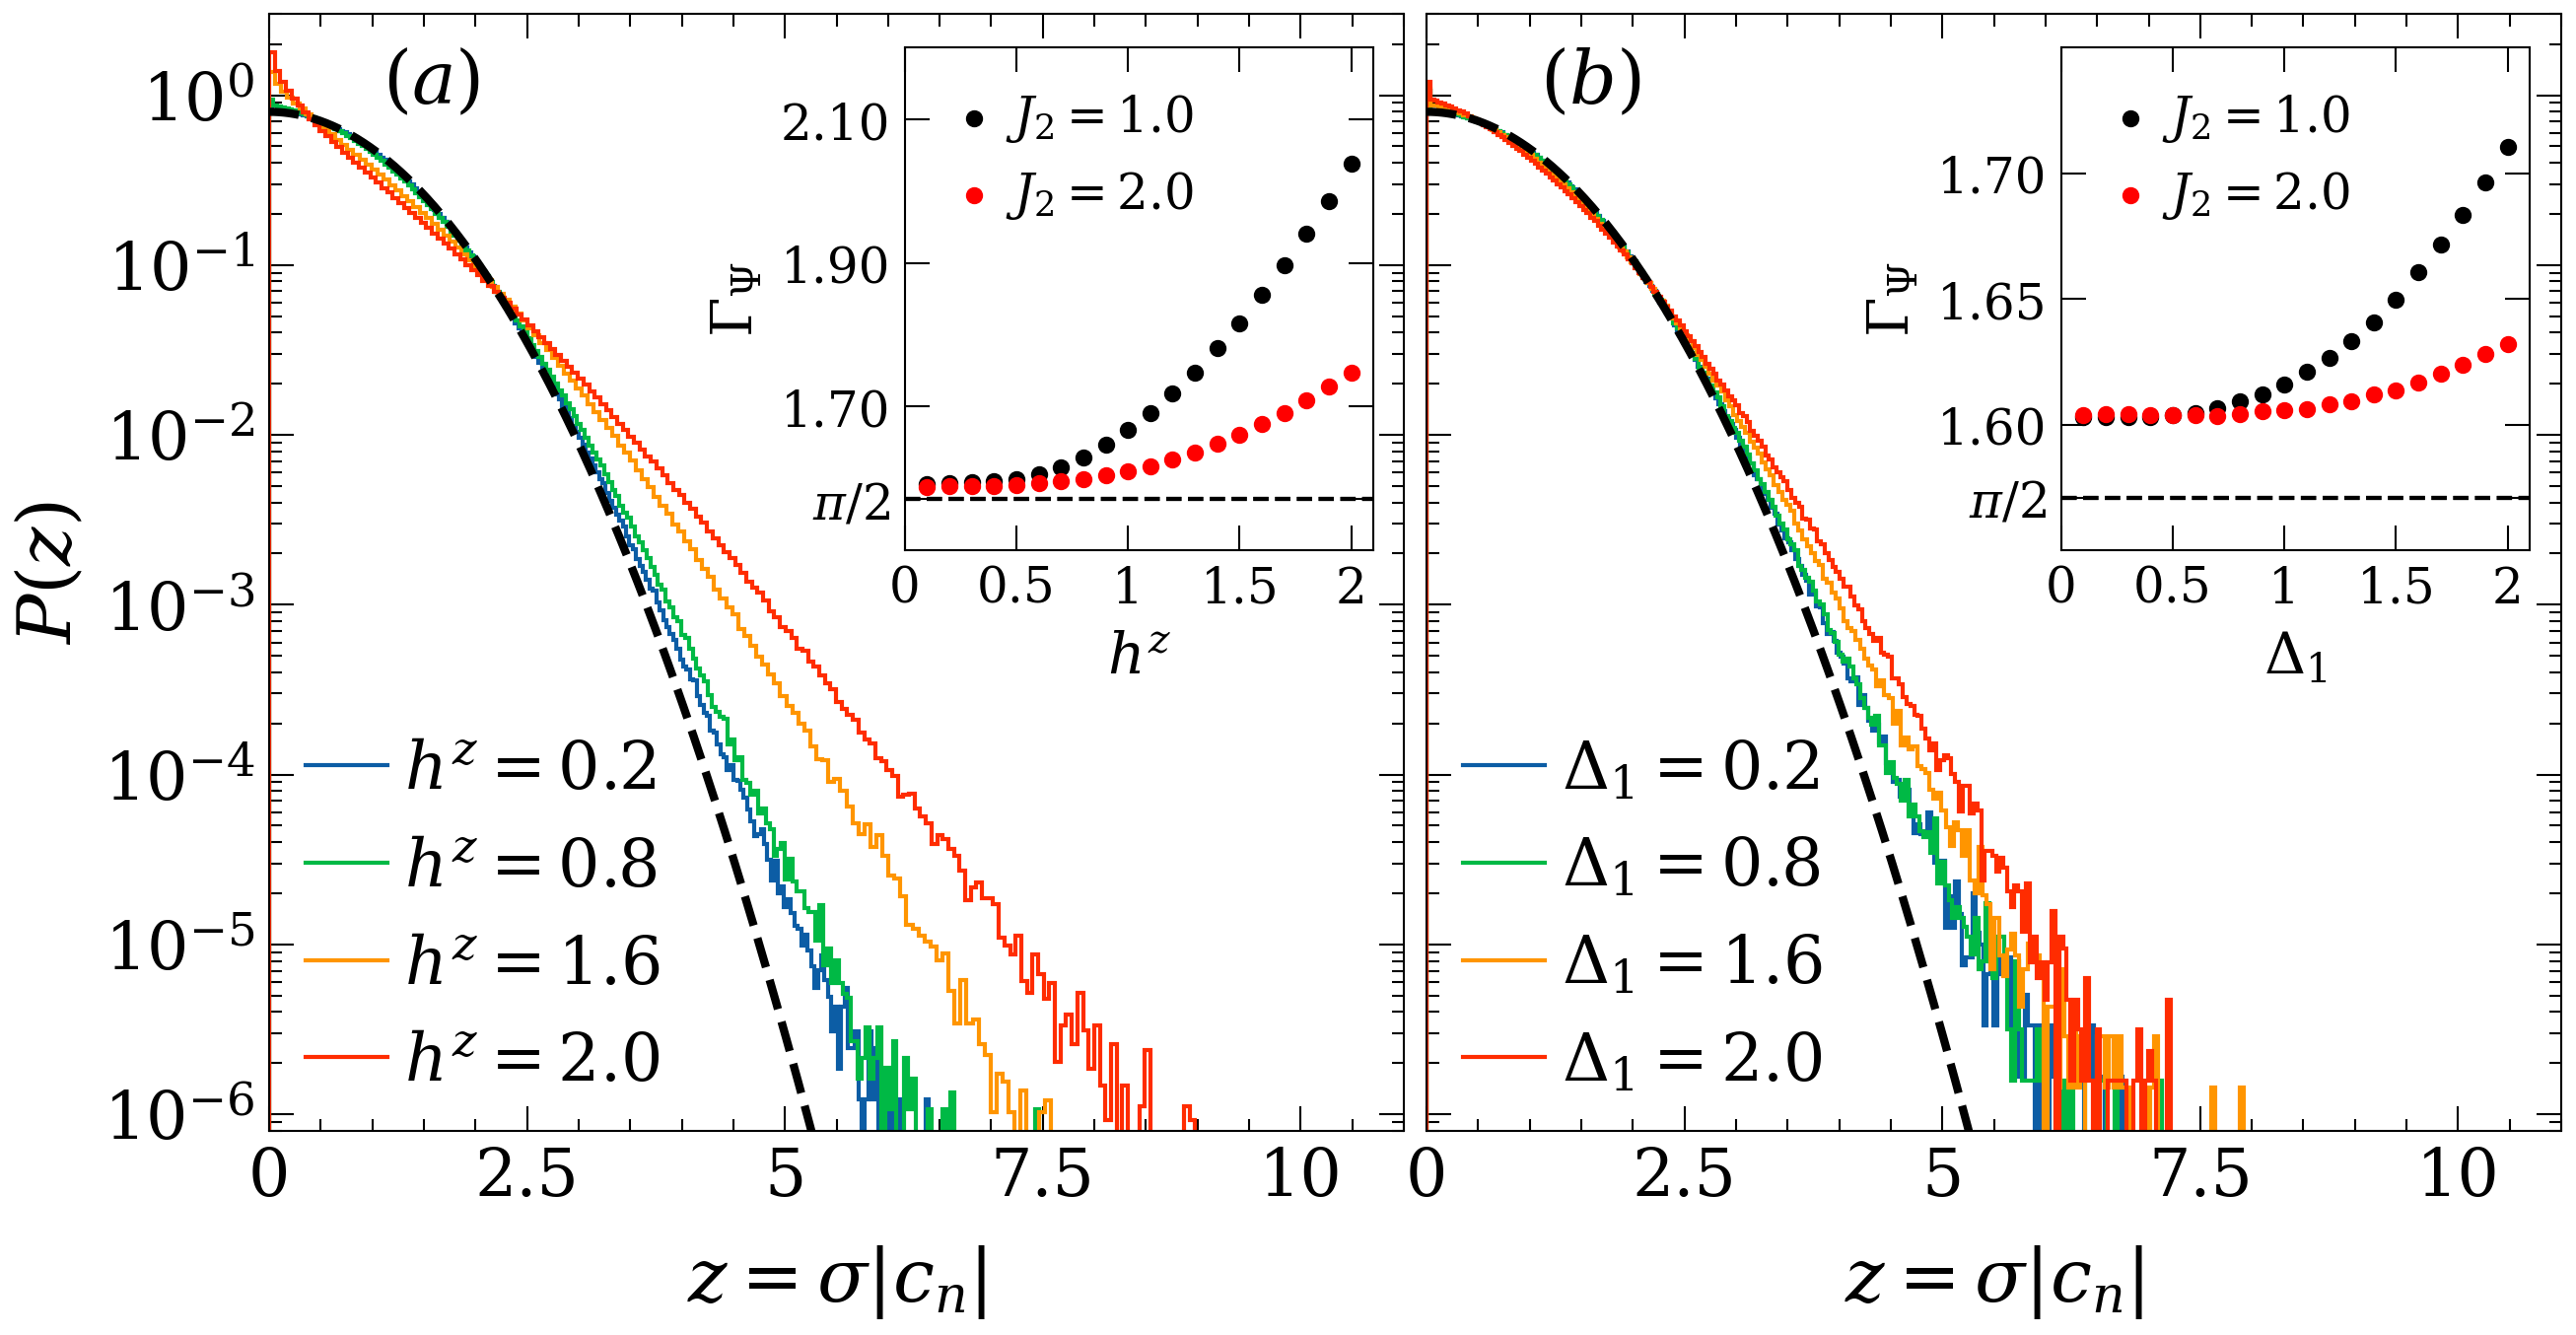

In [90]:
reload_modules()
import numpy as np
importlib.reload(np)

plot_abs = False
NCOLS = 2
NROWS = 1
space=0.02

num_of_subplots = NROWS * NCOLS
fig_dist, ax_dist = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(5 * (NCOLS / NROWS),5), dpi = 300, sharex=True, sharey=True)
ax_dist = np.array(ax_dist).flatten()


real_sectors, imag_sectors = get_sectors(L)

width = 0.45
height = 0.45

print("xx\tk\tp\tshape\t\tvar diff")

points = [[1.0, haha] for haha in x_range] + [[2.0, haha] for haha in x_range]
colors = ['red', 'black']
def plotter(which):
    delY = (which // NCOLS) * 0.18 / NROWS
    delX = np.abs(which % NCOLS - NCOLS + 1) * 0.18 / NCOLS
    ax_inset = hfun.add_subplot_axes(ax_dist[which], [delX + 0.97 - width, delY + 0.97 - height, width, height])
    ax_all = [ax_inset, ax_dist[which]]
    
    J = 1.0

    for xx in h_plot:
        edge = []
        hist = []
        if which == 0:
            filename_dist = f'MAXIMAL_ENTROPY_DATA/Distribution_J2={J},hz={xx}.npy'
            with open(filename_dist, 'rb') as file: 
                data = np.load(file, allow_pickle=True)
                edge = data[0]
                hist = data[1]
        else:
            edge, hist = read_maks_distributions(J2 = 1.0, delta = xx)  
        
        ax_dist[which].stairs(hist, edge, label=r"$%s=%.1f$"%("\Delta_1" if which == 1 else "h^z", xx))
    for J in [1.0, 2.0]:
        gaussianity = np.zeros( (len(x_range)) )
        if which == 0:
            filename_gauss = f'MAXIMAL_ENTROPY_DATA/Gaussianity_J2={J}.npy'
            with open(filename_gauss, 'rb') as file:
                gaussianity = np.load(file, allow_pickle=True)
        else:
            gaussianity = read_maks_gaussianity(J2 = J)
        print(len(gaussianity))
        ax_inset.scatter(x_range, gaussianity, s=10, label=r"$J_2=%.1f$"%(J), color='black' if J == 1.0 else 'red')


    ylab = "P(z)" if which == 0 else "\ "
    xlab = "z=\\sigma|c_n|"
    hfun.set_plot_elements(axis = ax_dist[which], ylabel = ylab, xlabel = xlab, settings=user_settings, 
                                font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax_dist[which].legend(loc = 'lower left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, -0.02))




    val = np.pi / 2 if which == 0 or not plot_abs else 4. / np.pi
    valname = r"$\pi/2$" if which == 0 or not plot_abs else r"$4/\pi$"
    
    ax_inset.axhline(y=val, ls='--', color='black')

    hfun.set_plot_elements(axis = ax_inset, ylabel = "\\Gamma_\\Psi", xlabel = "\\Delta_1" if which == 1 else "h^z", settings=user_settings, 
                            font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax_inset.legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)
    ax_inset.set_xlim(0, 2.1)
    
    for ax in list(ax_all):
        ax.set_xscale('linear')    
        ax.set_yscale('linear')
        ax.tick_params(axis="both",which='major',direction="in",length=6)
        ax.tick_params(axis="both",which='minor',direction="in",length=3)

    ax_inset.axhline(y=val, ls='--', color='black')
    yticks = [val, 1.7, 1.9, 2.1] if which == 0 else [val, 1.6, 1.65, 1.7]   
    tick_labels = ["%.2f"%ytic if ytic != val else valname for ytic in yticks]
    ax_inset.set_yticks(yticks)
    ax_inset.set_yticklabels(tick_labels)
    if which == 0:  ax_inset.set_ylim(1.5, 2.2)
    else:           ax_inset.set_ylim(1.55, 1.75)
#
    xticks = [0, 0.5, 1.0, 1.5, 2.0]
    tick_labels = ["%.1f"%xtic if xtic not in [0, 1, 2] else "%d"%xtic for xtic in xticks]
    ax_inset.set_xticks(xticks)
    ax_inset.set_xticklabels(tick_labels)
    ax_inset.xaxis.set_minor_locator(plt.NullLocator())
    ax_inset.yaxis.set_minor_locator(plt.NullLocator())


    ax_dist[which].set_xscale('linear')
    ax_dist[which].set_yscale('log')
    aa = np.linspace(-100.0, 100, 20000)
    mu=0.0
    sigma=1.
    ax_dist[which].set_ylim(8e-7, 3.0)
    ax_dist[which].set_xlim(0, 11)
    ax_dist[which].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    #ax_dist[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    ax_dist[which].plot(aa, 2. / np.sqrt(2*np.pi) * np.exp( - (aa)**2 / (2)), linestyle='--', color='black', linewidth=2)
    


plotter(0)
plotter(1)
ax_dist[0].annotate(r"$(a)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')
ax_dist[1].annotate(r"$(b)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')


fig_dist.subplots_adjust(wspace=space, hspace=space)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_coeff.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_coeff.png', bbox_inches = 'tight', padding=0.02)

### PLOT ABSOLUTE VALUE OF CEOFF

xx	k	p	shape		var diff


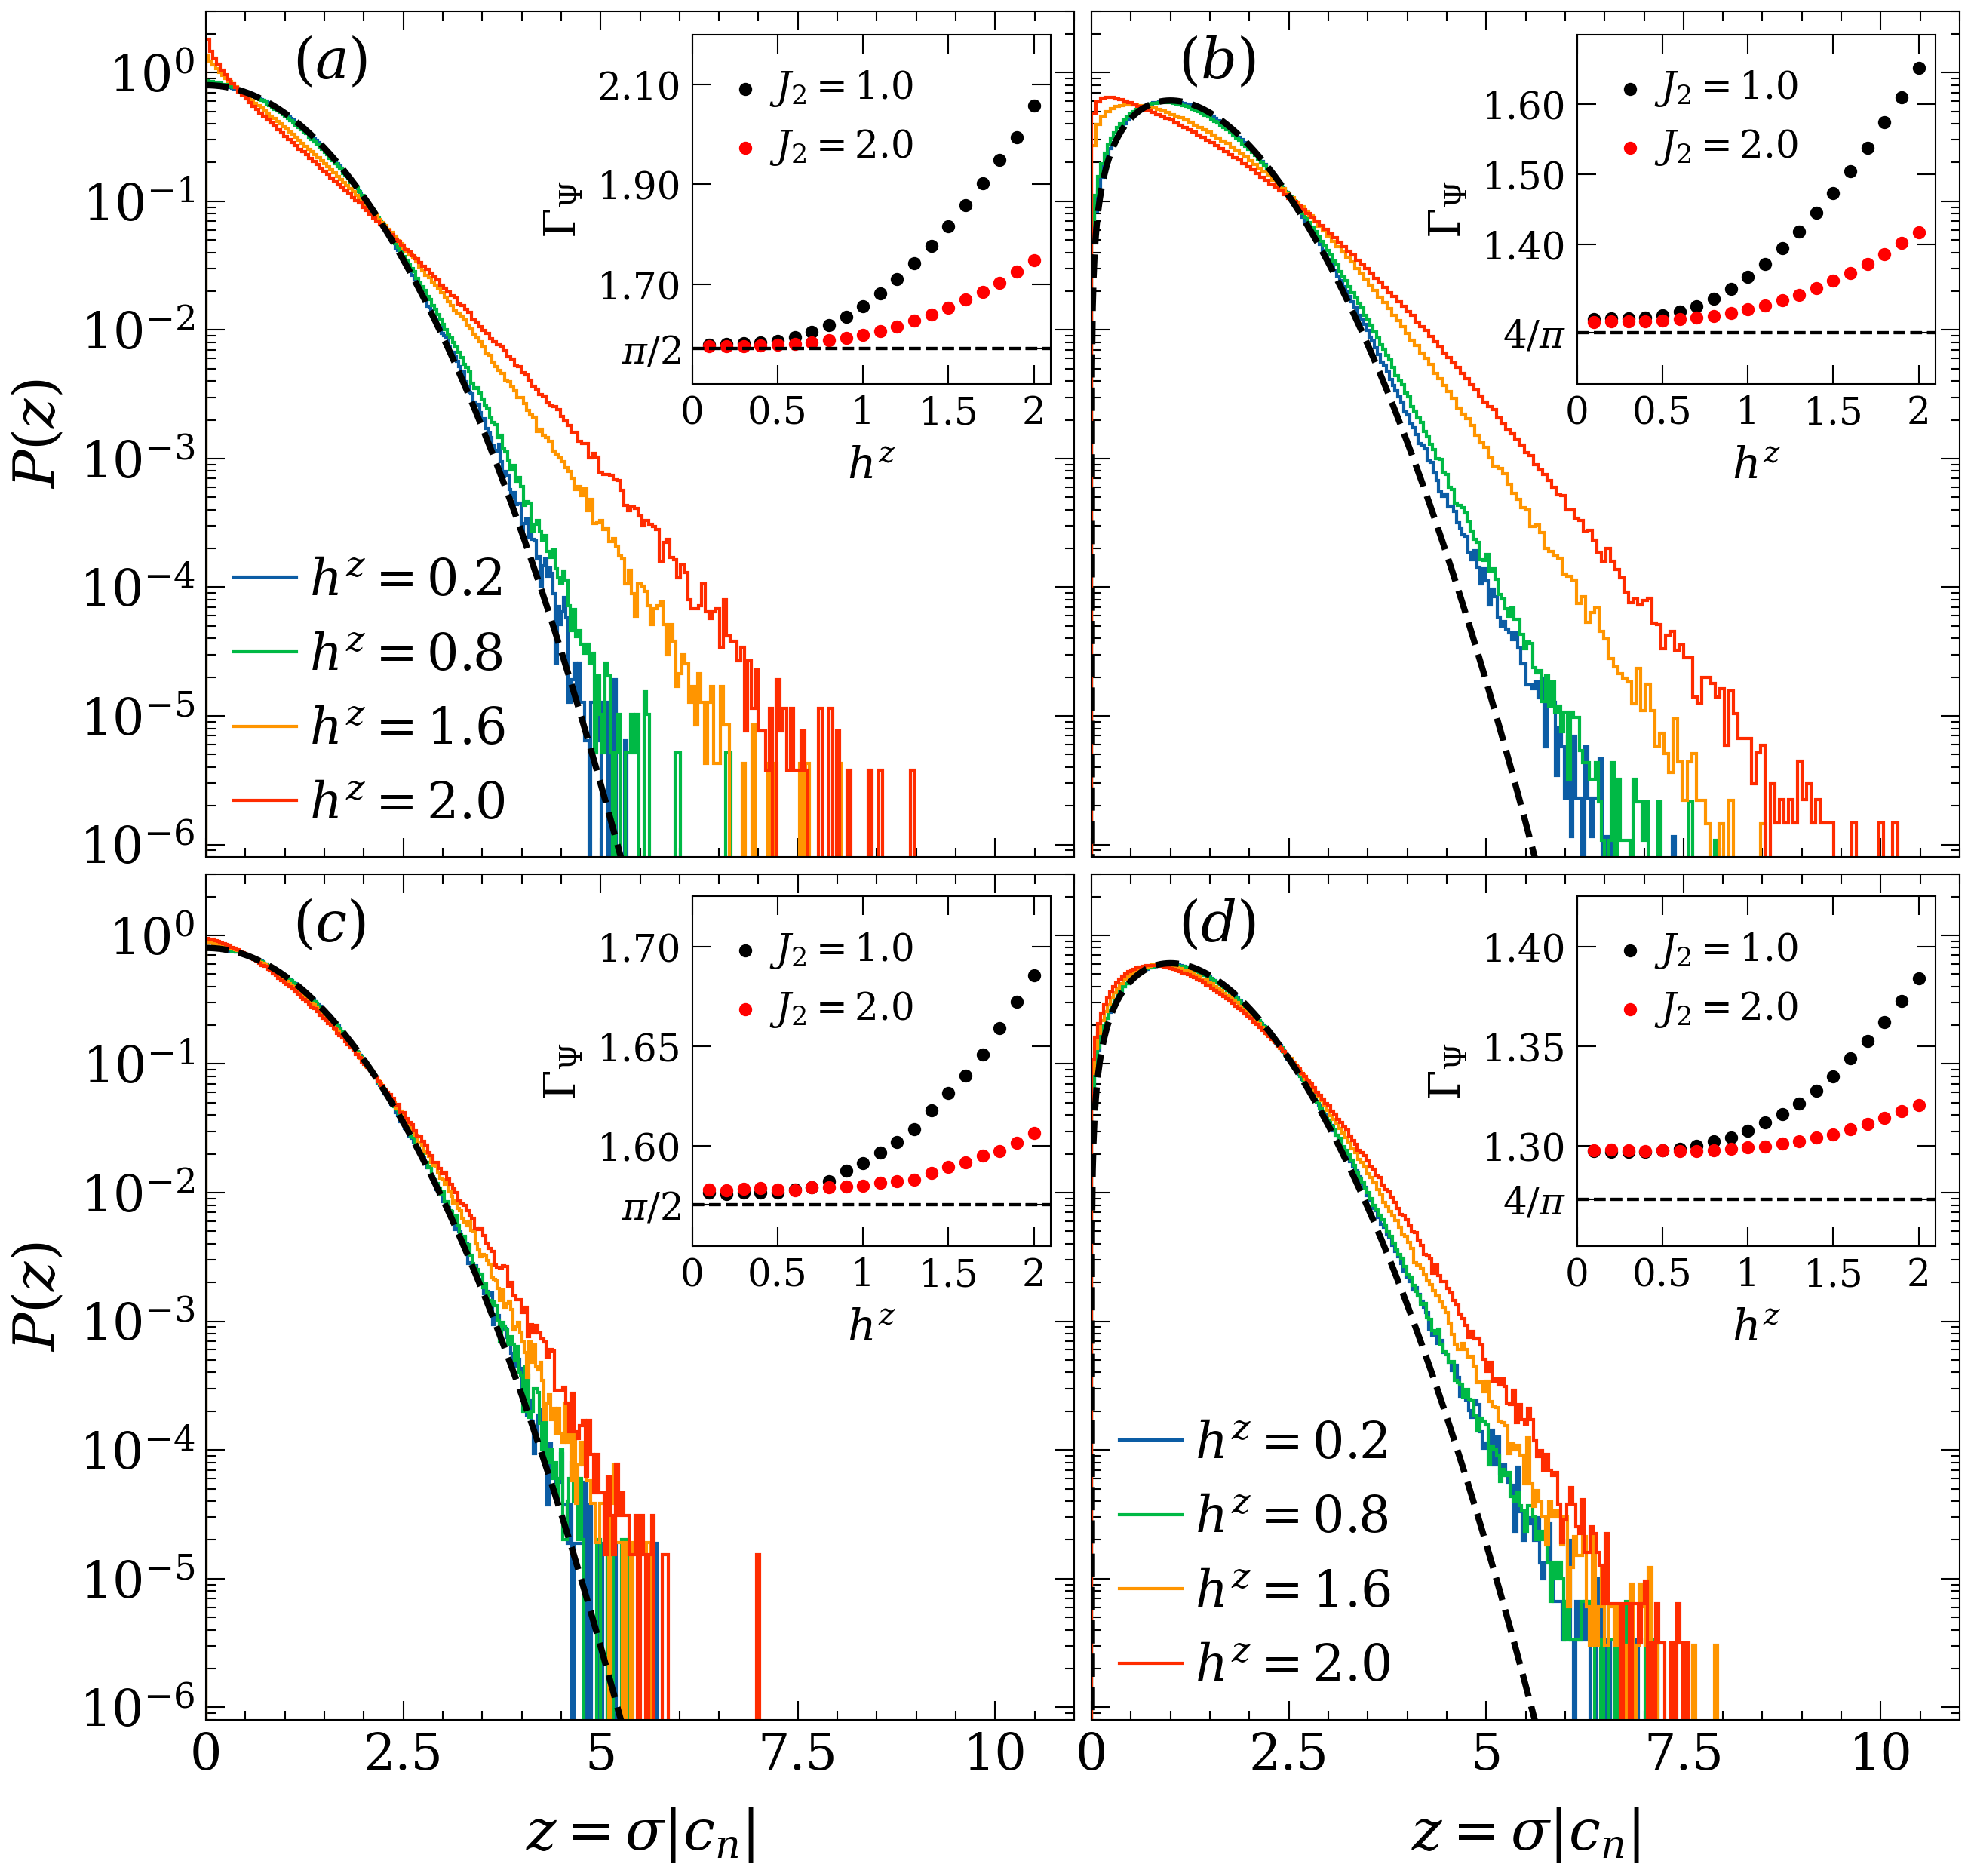

In [91]:
reload_modules()
import numpy as np
importlib.reload(np)

plot_abs = True
suff = "_abs" if plot_abs else ""
NCOLS = 2
NROWS = 2 if plot_abs else 1
space=0.02

num_of_subplots = NROWS * NCOLS
fig_dist, ax_dist = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(10 * (NCOLS / NROWS),10), dpi = 300, sharex=True, sharey=True)
ax_dist = np.array(ax_dist).flatten()


real_sectors, imag_sectors = get_sectors(L)

width = 0.45
height = 0.45

print("xx\tk\tp\tshape\t\tvar diff")

points = [[1.0, haha] for haha in x_range] + [[2.0, haha] for haha in x_range]
colors = ['red', 'black']
def plotter(which):
    delY = (which // NCOLS) * 0.18 / NROWS
    delX = np.abs(which % NCOLS - NCOLS + 1) * 0.18 / NCOLS
    ax_inset = hfun.add_subplot_axes(ax_dist[which], [delX + 0.97 - width, delY + 0.97 - height, width, height])
    ax_all = [ax_inset, ax_dist[which]]
    suff = "_abs_re" if which == 0 else "_abs_im"
    if which > 1:
        suff += "_su"
    J = 1.0

    for xx in h_plot:
        edge = []
        host = []
        if which < 2:
            filename_dist = f'MAXIMAL_ENTROPY_DATA/Distribution_J2={J},hz={xx}{suff}.npy'
            with open(filename_dist, 'rb') as file: 
                data = np.load(file, allow_pickle=True)
                edge = data[0]
                hist = data[1]
        else:
            edge, hist = read_maks_distributions_abs(J2 = 1.0, delta = xx, sector = 're' if which == 2 else 'im')  
        ax_dist[which].stairs(hist, edge, label=r"$h^z=%.1f$"%(xx))
    for J in [1.0, 2.0]:
        gaussianity = []
        if which < 2:
            filename_gauss = f'MAXIMAL_ENTROPY_DATA/Gaussianity_J2={J}{suff}.npy'
            with open(filename_gauss, 'rb') as file:
                gaussianity = np.load(file, allow_pickle=True)
        else:
            gaussianity = read_maks_gaussianity_abs(J2 = J, sector = 're' if which == 2 else 'im')

        ax_inset.scatter(x_range, gaussianity, s=10, label=r"$J_2=%.1f$"%(J), color='black' if J == 1.0 else 'red')


    ylab = "P(z)" if which % 2 == 0 else "\ "
    xlab = "z=\\sigma|c_n|" if which > 1 else "\ "
    hfun.set_plot_elements(axis = ax_dist[which], ylabel = ylab, xlabel = xlab, settings=user_settings, 
                                font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    if which == 0 or which == 3:
        ax_dist[which].legend(loc = 'lower left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, -0.02))




    val = np.pi / 2 if which % 2 == 0 else 4. / np.pi
    valname = r"$\pi/2$" if which % 2 == 0 else r"$4/\pi$"
    
    ax_inset.axhline(y=val, ls='--', color='black')

    hfun.set_plot_elements(axis = ax_inset, ylabel = "\\Gamma_\\Psi", xlabel = "\\Delta_1" if use_Sz_sym else "h^z", settings=user_settings, 
                            font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax_inset.legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)
    ax_inset.set_xlim(0, 2.1)
    
    for ax in list(ax_all):
        ax.set_xscale('linear')    
        ax.set_yscale('linear')
        ax.tick_params(axis="both",which='major',direction="in",length=6)
        ax.tick_params(axis="both",which='minor',direction="in",length=3)

    ax_inset.axhline(y=val, ls='--', color='black')
    yticks = [val, 1.7, 1.9, 2.1] if which % 2 == 0 else [val, 1.4, 1.5, 1.6]
    if which > 1:  yticks = [val, 1.6, 1.65, 1.7] if which % 2 == 0 else [val, 1.3, 1.35, 1.4]  
    tick_labels = ["%.2f"%ytic if ytic != val else valname for ytic in yticks]
    ax_inset.set_yticks(yticks)
    ax_inset.set_yticklabels(tick_labels)
    
    if which == 0:      ax_inset.set_ylim(1.5, 2.2)
    elif which == 1:    ax_inset.set_ylim(1.2, 1.7)
    elif which == 2:    ax_inset.set_ylim(1.55, 1.725)
    else:               ax_inset.set_ylim(1.25, 1.425)
    
    xticks = [0, 0.5, 1.0, 1.5, 2.0]
    tick_labels = ["%.1f"%xtic if xtic not in [0, 1, 2] else "%d"%xtic for xtic in xticks]
    ax_inset.set_xticks(xticks)
    ax_inset.set_xticklabels(tick_labels)
    ax_inset.xaxis.set_minor_locator(plt.NullLocator())
    ax_inset.yaxis.set_minor_locator(plt.NullLocator())


    ax_dist[which].set_xscale('linear')
    ax_dist[which].set_yscale('log')
    aa = np.linspace(-100.0, 100, 20000)
    mu=0.0
    sigma=1.
    ax_dist[which].set_ylim(8e-7, 3.0)
    ax_dist[which].set_xlim(0, 11)
    if which > 1:   ax_dist[which].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    else:           ax_dist[which].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    #ax_dist[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))

    if which % 2 == 0:    
        ax_dist[which].plot(aa, 2. / np.sqrt(2*np.pi) * np.exp( - (aa)**2 / (2)), linestyle='--', color='black', linewidth=2)
    else:             
        ax_dist[which].plot(aa, aa * np.exp( - aa**2 / (2)), linestyle='--', color='black', lw=2)


plotter(0)
plotter(1)
ax_dist[0].annotate(r"$(a)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')
ax_dist[1].annotate(r"$(b)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')

plotter(2)
plotter(3)
ax_dist[2].annotate(r"$(c)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')
ax_dist[3].annotate(r"$(d)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')


fig_dist.subplots_adjust(wspace=space, hspace=space)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_coeff_abs.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_coeff_abs.png', bbox_inches = 'tight', padding=0.02)


## REAL SECTORS

### LOAD

In [39]:
reload_modules()

def load_real(use_Sz_sym):
    if use_Sz_sym:
        J0=0.0
        g0=0.0
        h=0.0
        
    level_spacings = []
    gap_ratio = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    gaussianity = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent_max = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    info_ent = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)

    for ii, xx in enumerate(x_range[:-1]):
        edges_tmp = []
        gaps_distribution = []
        spacings = []
        for jj, Jx in enumerate(J_range[:-1]):

            def get_data(ksym, psym, xsym = 1):
                info = hfun.info_sym(L, Jx, g, xx, ksym, psym, xsym)
                info = dir + info[0 : info.index('.dat') :]

                filename = info + "_subsize=%d.hdf5"%(f * L)
                if exists(filename):  
                    data = []
                    with h5py.File(filename, "r") as file:
                        # Print all root level object names (aka keys) 
                        # these can be group or dataset names 
                        #print(info, "Keys: %s" % file.keys())
                        energies = np.array(file.get('energies')[0])
                        entropy = np.array(file.get('entropy')[0])
                        dim = energies.size

                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        information_ent = 0
                        if len(file.keys()) > 2: 
                            Vfull = np.array(file.get('eigenvectors')).view('complex')
                            print(Jx, xx, ksym, psym, Vfull.shape)
                            V = np.array(Vfull.flatten())
                            skwer = np.square(np.abs(V))
                            information_ent = - np.sum(skwer * np.log(skwer)) / (201. * np.log(0.48 * dim) )

                            V = np.abs(V) * np.sqrt(dim)
                    return True, energies, entropy, V, information_ent
                else:
                    print(filename)
                    return False, np.array([]), np.array([]), np.array([]), np.nan

            coeffs = []
            S = 0
            Smax_tmp = 0
            r = 0
            Sinf = 0
            cunt = 0
            dims_tot = 0
            gaps_dist_tmp = []
            gaps_all = []
            for [kk, px] in real_sectors:
                status, energies, entropy, V, Sinf_tmp = get_data(ksym = kk, psym = px)
                if status:
                    coeffs += list(V)
                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    size = energies.size
                    
                    num = 500 if L > 8 else 100
                    #num = 0.5 * size
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0

                    my_max = int(index_meanE + num / 2) 
                    if my_max>= size: my_max = size

                    if max(entropy) > Smax_tmp: Smax_tmp = max(entropy)
                    sample = entropy[my_min : my_max]

                    dims_tot += energies.size
                    S += energies.size * np.mean(sample)
                    #S += np.mean(sample)
                    Sinf += Sinf_tmp

                    gaps = np.diff(energies)
                    gaps_all += list(gaps)

                    r_tmp = 0
                    counter = 0
                    for i in range(int(int(index_meanE - 0.5 * size / 2)), int(int(index_meanE + 0.5 * size / 2))):
                        r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
                        counter += 1
                    r += r_tmp / counter
                    cunt += 1
                #else: print("Not Found :( ")

            coeffs = np.abs(np.array(coeffs))

            gaussianity[ii, jj] = np.mean(np.square(coeffs)) / np.mean(coeffs)**2 - np.pi / 2 if cunt > 0 else np.nan
            gap_ratio[ii, jj] = r / cunt if cunt > 0 else np.nan
            ent_max[ii, jj] = page(L, f) -  Smax_tmp if cunt > 0 else np.nan
            ent[ii, jj] = page(L, f) -  S / dims_tot if cunt > 0 else np.nan
            info_ent[ii, jj] = Sinf / cunt if cunt > 0 else np.nan
            
            spacings.append(gaps_all)
            
        level_spacings.append(np.array(spacings))

    return np.array(level_spacings), np.array(gaussianity), np.array(gap_ratio), np.array(info_ent), np.array(ent_max), np.array(ent)


In [40]:

level_spacings, gaussianity, gap_ratio, info_ent, ent_max, ent = load_real(use_Sz_sym=False)

with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_re{suff}.npy', 'wb') as file:      np.save(file, level_spacings)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_re{suff}.npy', 'wb') as file:         np.save(file, gaussianity)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_re{suff}.npy', 'wb') as file:           np.save(file, gap_ratio)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_re{suff}.npy', 'wb') as file:            np.save(file, info_ent)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_re{suff}.npy', 'wb') as file:             np.save(file, ent_max)
with open(f'MAXIMAL_ENTROPY_DATA/ent_re{suff}.npy', 'wb') as file:                 np.save(file, ent)

0.1 0.1 0 -1 (201, 6918)
0.1 0.1 0 1 (201, 7686)
0.1 0.1 9 -1 (201, 7400)
0.1 0.1 9 1 (201, 7144)
0.2 0.1 0 -1 (201, 6918)
0.2 0.1 0 1 (201, 7686)


KeyboardInterrupt: 

In [2]:
with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_re.npy', 'rb') as file:      level_spacings = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_re.npy', 'rb') as file:         gaussianity = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_re.npy', 'rb') as file:           gap_ratio = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_re.npy', 'rb') as file:            info_ent = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_re.npy', 'rb') as file:             ent_max = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_re.npy', 'rb') as file:                 ent = np.load(file)

### PLOT

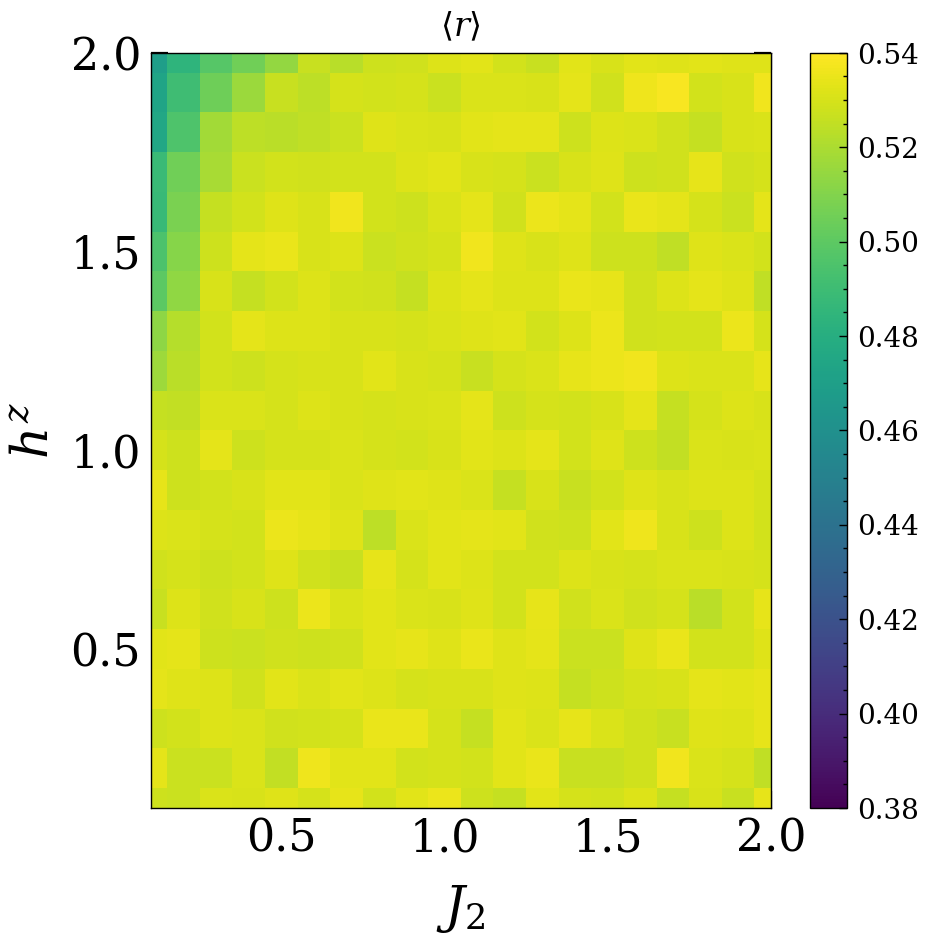

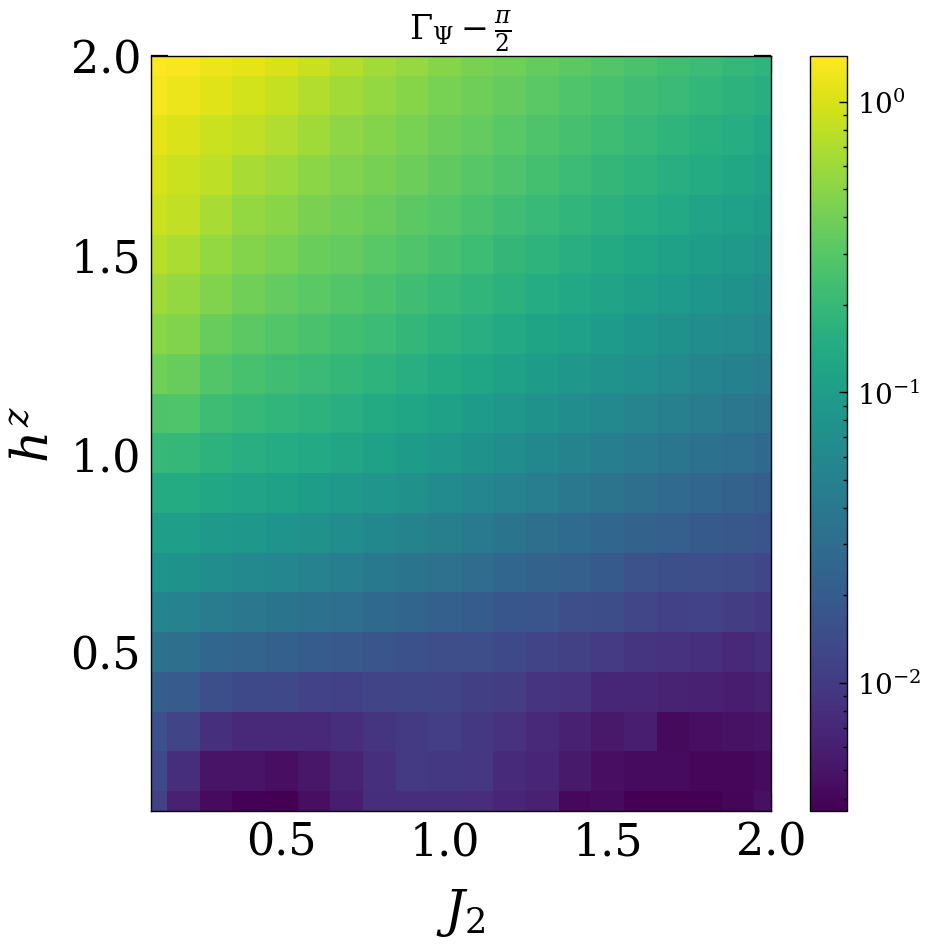

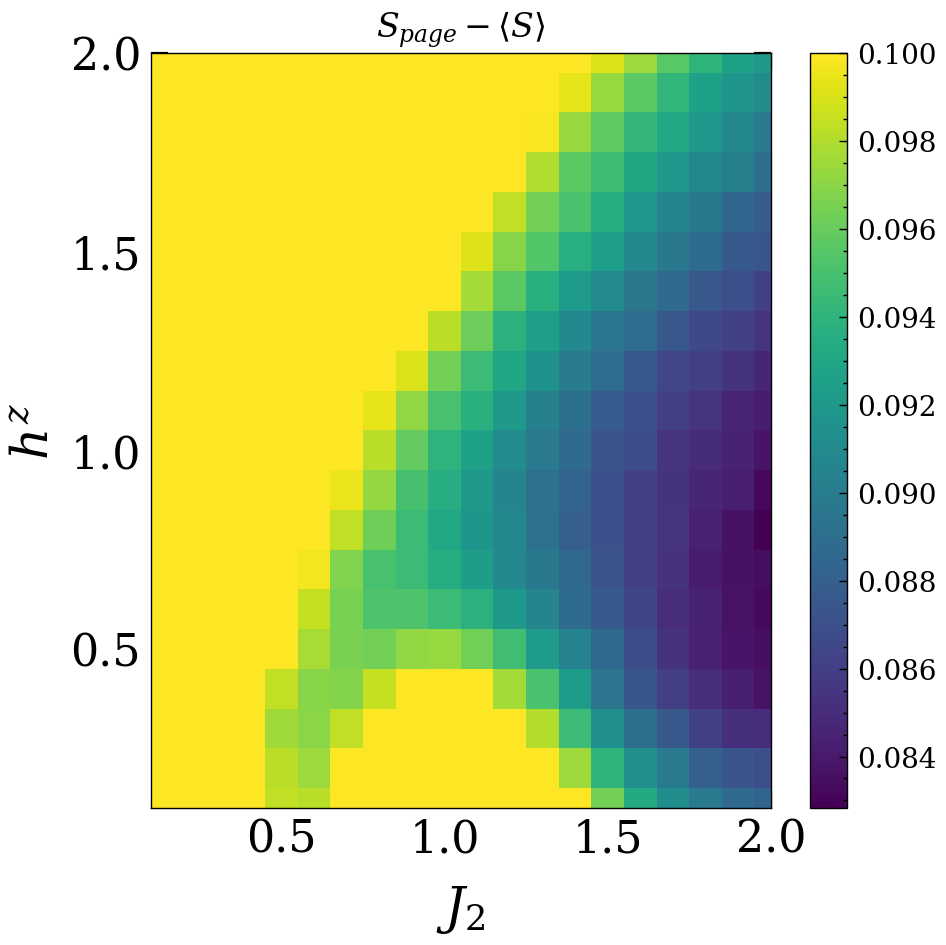

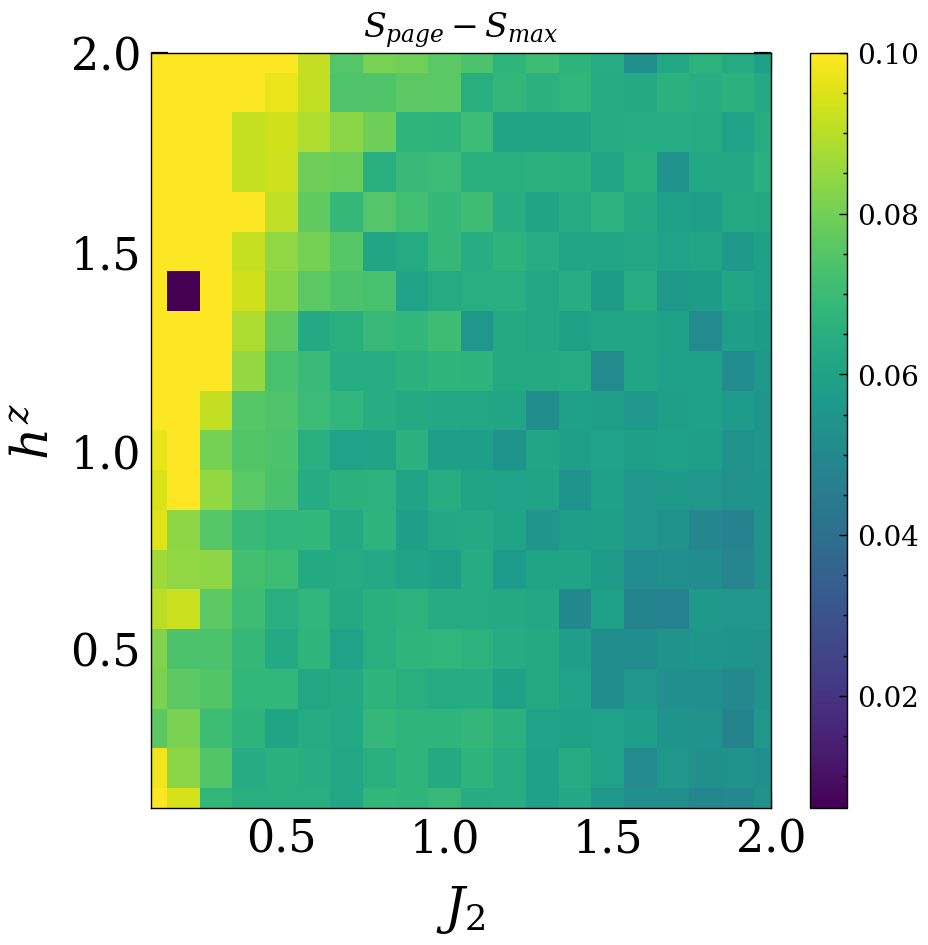

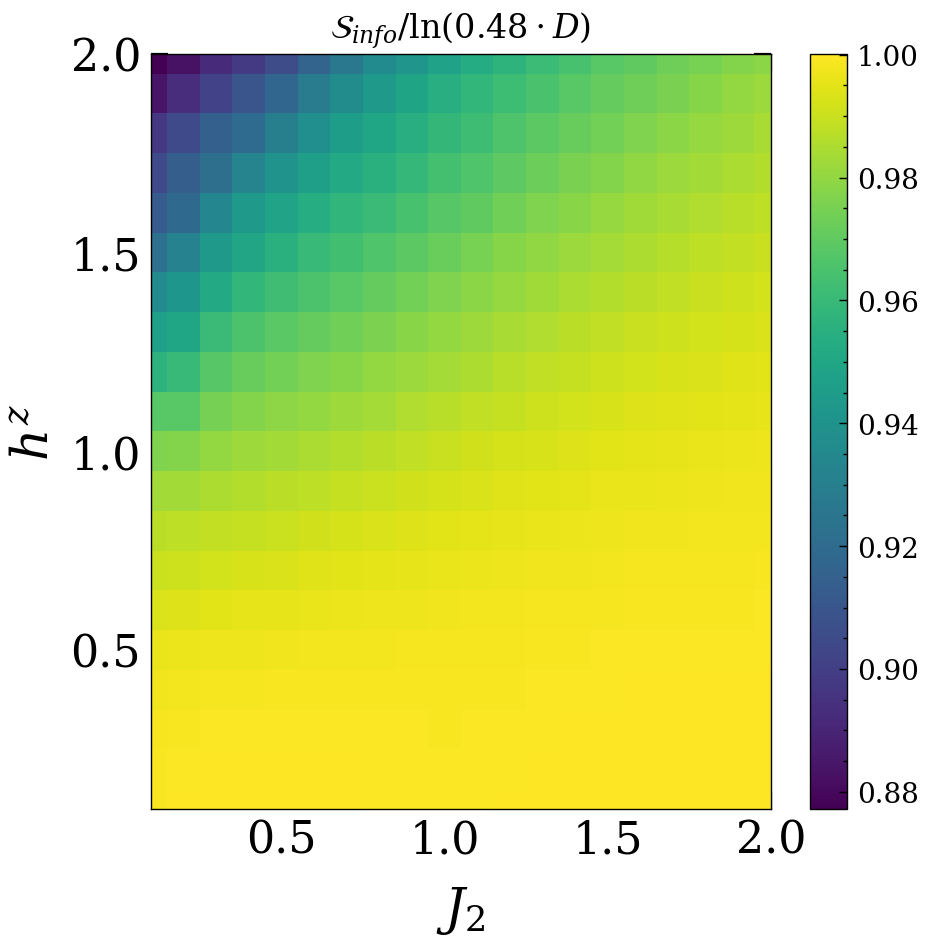

In [193]:

skipX = int(J_range.size / 6)
skipY = int(x_range.size / 6)

X, Y = np.meshgrid(J_range, x_range)

fig, ax_gaps = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gaps.pcolormesh(X, Y, gap_ratio, shading='nearest', vmin=0.38, vmax=0.54)
ax_gaps.set_title(r"$\langle r\rangle$")
fig.colorbar(p)

fig, ax_gauss = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gauss.pcolormesh(X, Y, gaussianity, shading='nearest', norm=matplotlib.colors.LogNorm())
ax_gauss.set_title(r"$\Gamma_\Psi - \frac{\pi}{2}$")
fig.colorbar(p)

fig, ax_ent = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_ent.pcolormesh(X, Y, ent, shading='nearest', vmax=0.1)
ax_ent.set_title(r"$S_{page} - \langle S\rangle$")
fig.colorbar(p)

fig, ax_outlier = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_outlier.pcolormesh(X, Y, ent_max, shading='nearest', vmax=0.1)
ax_outlier.set_title(r"$S_{page} - S_{max}$")
fig.colorbar(p)

fig, ax_info = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_info.pcolormesh(X, Y, info_ent, shading='nearest')
ax_info.set_title(r"$\mathcal{S}_{info}/\ln(0.48\cdot D)$")
fig.colorbar(p)

for ax in [ax_info, ax_ent, ax_outlier, ax_gaps, ax_gauss]:

    hfun.set_plot_elements(axis = ax, ylabel = "\\Delta_1" if use_Sz_sym else "h^z", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    tics = [0.5, 1.0, 1.5, 2.0]
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)
    ax.set_yticks(tics)
    ax.set_xticks(tics)
    ax.set_xlim(min(J_range), max(J_range))
    ax.set_ylim(min(x_range), max(x_range))

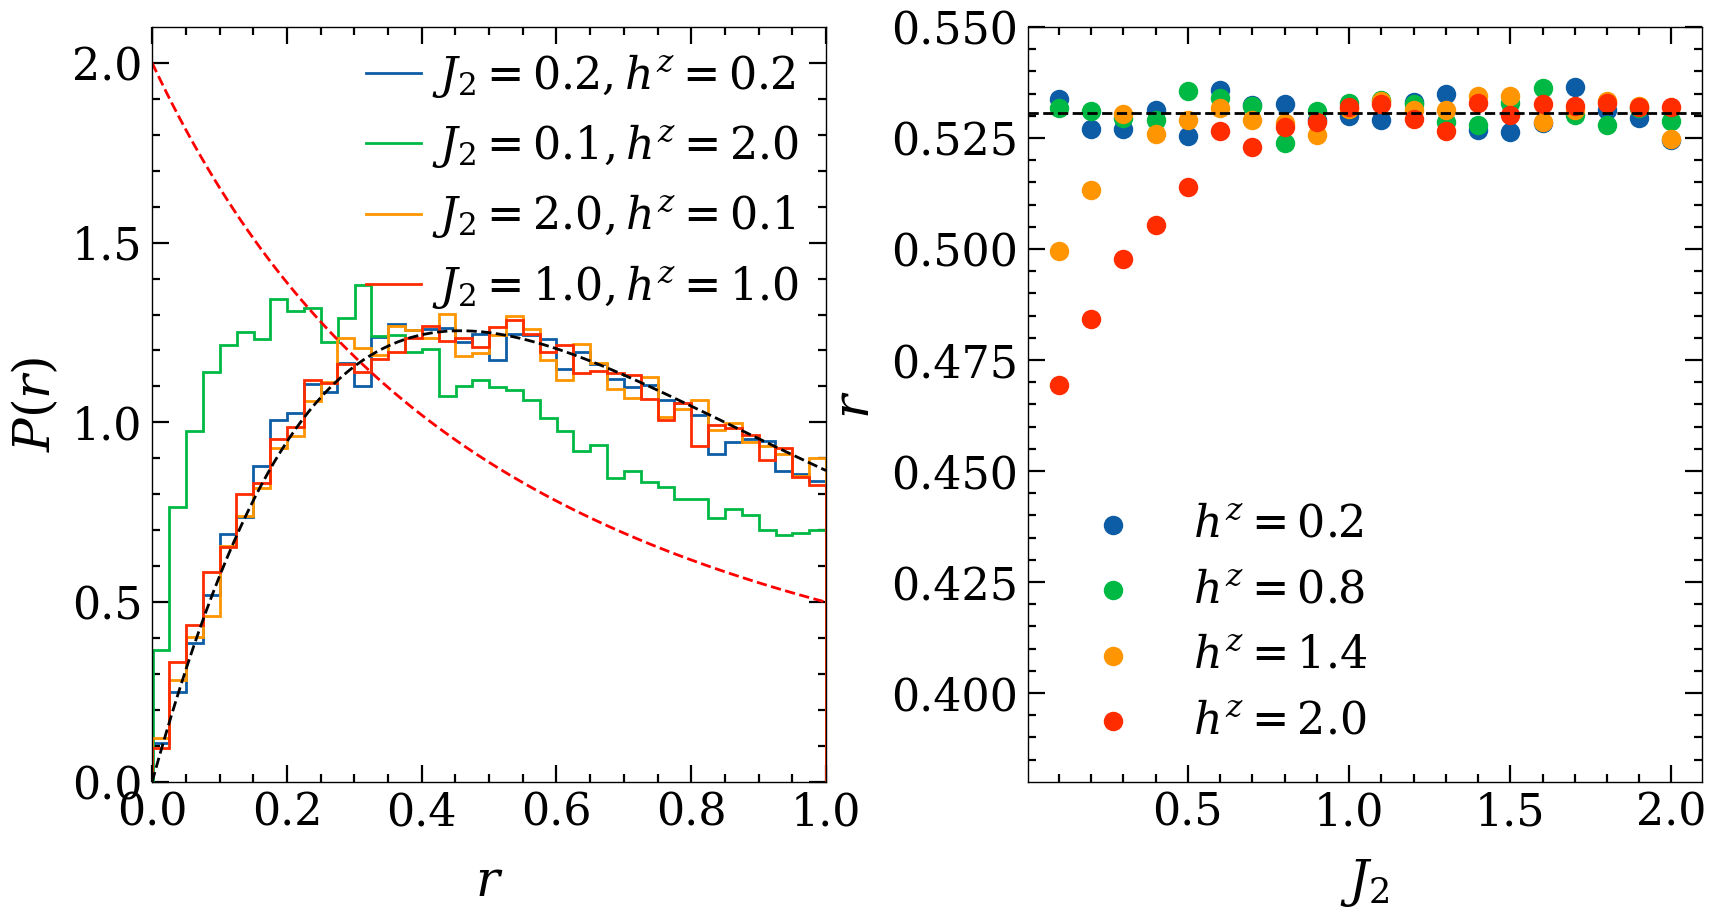

In [ ]:
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)


## --- LEFT PANEL
USE_GAP_RATIO = 1
points_to_plot = [[0.2, 0.2], [0.1, 2.0], [2.0, 0.1], [1.0, 1.0]]
xpoi = np.linspace(0, 1, 100)
if USE_GAP_RATIO:
    axis[0].plot(xpoi, 27 / 4 * ( xpoi + xpoi**2 ) / ( 1 + xpoi + xpoi**2 )**(5/2), linestyle='--', color='black')
    axis[0].plot(xpoi, 2 / (1 + xpoi)**2, linestyle='--', color='red')
else:
    axis[0].plot(xpoi, np.pi / 2 * xpoi * np.exp(-np.pi/4 * xpoi**2), linestyle='--', color='black')
    axis[0].plot(xpoi, np.exp(-xpoi), linestyle='--', color='red')

for [J2, xx] in points_to_plot:
    ii = list(x_range).index(xx)
    jj = list(J_range).index(J2)
    gaps = np.array(level_spacings[ii][jj])
    level_stats = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])
    data = level_stats if USE_GAP_RATIO else gaps
    hist, bins = np.histogram(data, bins=40, normed=True)
    axis[0].stairs(hist, bins, label=r"$J_2=%.1f$"%J2 + scan_lab + r"$=%.1f$"%(xx))
axis[0].set_xlim(0,1)    

## --- RIGHT PANEL

J_to_plot = [0.2, 0.8, 1.4, 2.0]
for J2 in J_to_plot:
    ii = list(J_range).index(J2)
    r = gap_ratio[ii]
    axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2))

axis[1].set_ylim(0.38, 0.55)
axis[1].axhline(y=0.5307, ls='--', color='black')


## --- COMSETICS
hfun.set_plot_elements(axis = axis[0], ylabel = "P(r)", xlabel = "r", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[0].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))


hfun.set_plot_elements(axis = axis[1], ylabel = "r", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=True, xlim=(None, None), ylim=(None, None))
for ax in list(axis):
    ax.set_xscale('linear')    
    ax.set_yscale('linear')
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)

fig.subplots_adjust(wspace=0.3, hspace=0.3)


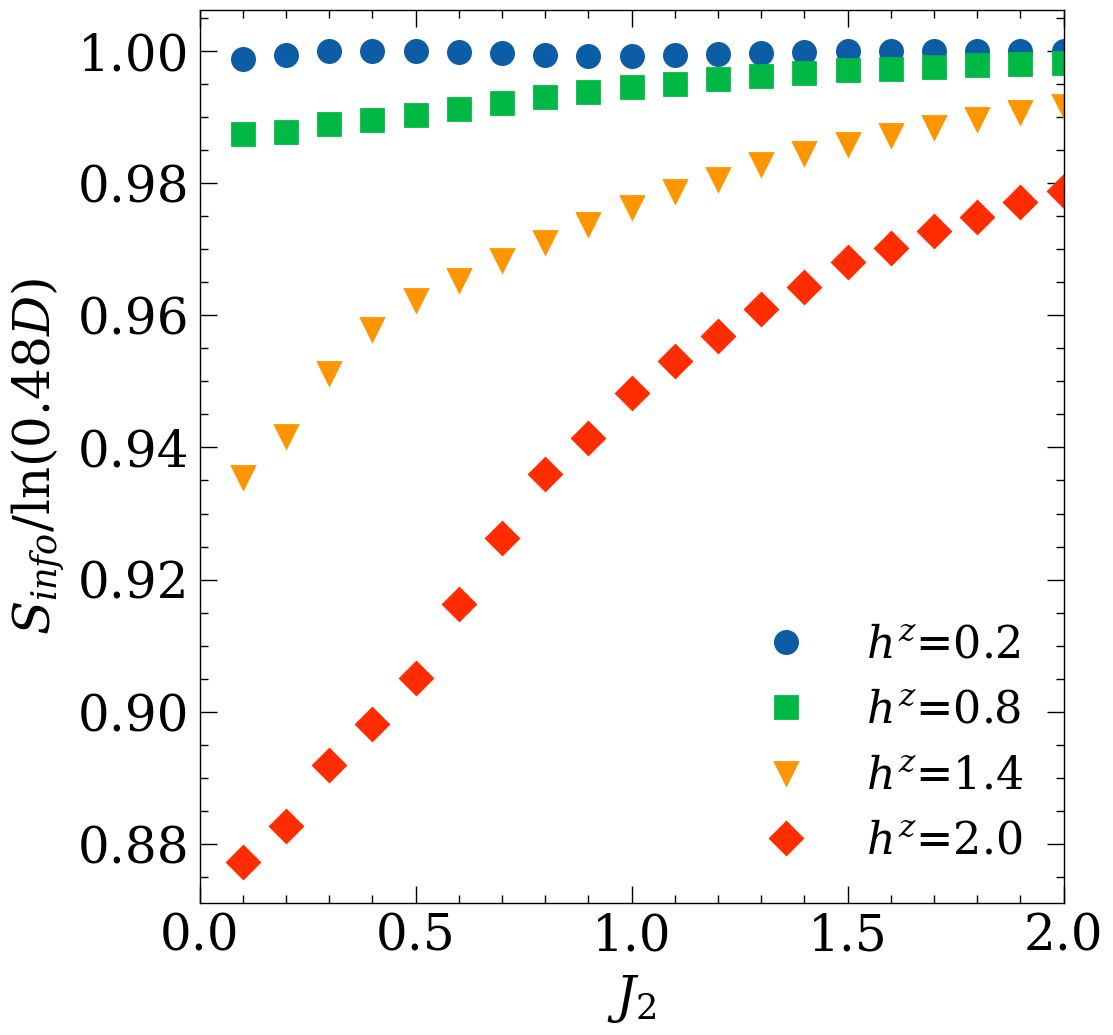

In [35]:
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

label_b = '$\Delta_1$' if use_Sz_sym else  '$h^z$'
label_a = '$J_2$'
f = 1/2.

# plot
fig, ax = plt.subplots(1, figsize = (5, 5), dpi=200)
fig.tight_layout()

h_to_plot = [0.2, 0.8, 1.4, 2.0]
for xx in h_to_plot:
    ii = list(x_range).index(xx)
    #axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2), marker=next(markers))
    ax.plot(J_range, info_ent[ii], label = scan_lab + f'=${xx}$', linewidth=0, marker = next(markers), markersize=8)
    
#ax.axhline(goe, label = '$r_{GOE}$', linestyle = "--", linewidth=3, color='black')
ax.set_xlabel(label_a, size = 18)
ax.set_ylabel('$S_{info} / \ln(0.48D)$', size = 18)
ax.set_xlim(0.0,2.0)
#ax.set_ylim(1.015, 1.030)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', rotation = 0, labelsize=18)

ax.tick_params(axis="both",which='major',direction="in", length=6)
ax.tick_params(axis="both",which='minor',direction="in", length=3)

#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#ax.set_title(title)
ax.legend(fontsize = 16)

## IMAGINARY SECTORS

### LOAD

In [30]:
reload_modules()

def load_imag(use_Sz_sym = False):

    if use_Sz_sym:
        J0=0.0
        g0=0.0
        h=0.0

    level_spacings_im = []
    gap_ratio_im   = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    gaussianity_im = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent_im         = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent_max_im     = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    info_ent_im    = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)

    for ii, xx in enumerate(x_range[:-1]):
        spacings = []
        for jj, Jx in enumerate(J_range[:-1]):

            def get_data(ksym, psym, xsym = 1):
                info = hfun.info_sym(L, Jx, g, xx, ksym, psym, xsym)
                info = dir + info[0 : info.index('.dat') :]

                filename = info + "_subsize=%d.hdf5"%(f * L)
                if exists(filename):  
                    data = []
                    with h5py.File(filename, "r") as file:
                        # Print all root level object names (aka keys) 
                        # these can be group or dataset names 
                        #print(info, "Keys: %s" % file.keys())
                        energies = np.array(file.get('energies')[0])
                        entropy = np.array(file.get('entropy')[0])
                        dim = energies.size

                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        information_ent = 0
                        if len(file.keys()) > 2: 
                            V = np.array(file.get('eigenvectors')).view('complex')
                            print(Jx, xx, ksym, psym, V.shape)

                            V = np.abs(np.array(V.flatten()))
                            skwer = V**2
                            information_ent = - np.sum(skwer * np.log(skwer)) / (201. * np.log(0.48 * dim) )

                            V = V * np.sqrt(2* dim)
                    return True, energies, entropy, V, information_ent
                else:
                    print(filename)
                    return False, np.array([]), np.array([]), np.array([]), np.nan

            coeffs = []
            S = 0
            Smax_tmp = 0
            r = 0
            Sinf = 0
            cunt = 0
            dims_tot = 0
            gaps_all = []
            for [kk, px] in imag_sectors:
                status, energies, entropy, V, Sinf_tmp = get_data(ksym = kk, psym = px)
                if status:
                    coeffs += 2 * list(V)
                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    dim = energies.size
                    
                    num = 500 if dim > 1000 else 200
                    my_min = int(index_meanE - num / 2)
                    my_max = int(index_meanE + num / 2) 
                    if my_min < 0: my_min = 0
                    if my_max >= dim: my_max = dim
                    
                    if max(entropy) > Smax_tmp: Smax_tmp = max(entropy)
                    sample = entropy[my_min : my_max]

                    gaps = np.diff(energies)

                    r_tmp = 0
                    counter = 0
                    for i in range(int(int(index_meanE - 0.5 * dim / 2)), int(int(index_meanE + 0.5 * dim / 2))):
                        r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
                        counter += 1

                    dims_tot += 2 * dim
                    S += 2 * dim * np.mean(sample)
                    Sinf += 2 * Sinf_tmp
                    r += 2 * r_tmp / counter
                    gaps_all += 2 * list(gaps)
                    
                    cunt += 2

            coeffs = np.abs(np.array(coeffs))

            val = 4 / np.pi
            gaussianity_im[ii, jj]  = np.mean(np.square(coeffs)) / np.mean(coeffs)**2 - val if cunt > 0 else np.nan
            gap_ratio_im[ii, jj]    = r / cunt if cunt > 0 else np.nan
            info_ent_im[ii, jj]     = Sinf / cunt if cunt > 0 else np.nan
            
            ent_max_im[ii, jj]      = page(L, f) -  Smax_tmp if cunt > 0 else np.nan
            ent_im[ii, jj]          = page(L, f) -  S / dims_tot if cunt > 0 else np.nan
            
            spacings.append(gaps_all)

        level_spacings_im.append(np.array(spacings))


In [ ]:

level_spacings_im, gaussianity_im, gap_ratio_im, info_ent_im, ent_max_im, ent_im = load_imag(use_Sz_sym=False)

with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_im{suff}.npy', 'wb') as file:      np.save(file, level_spacings_im)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_im{suff}.npy', 'wb') as file:         np.save(file, gaussianity_im)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_im{suff}.npy', 'wb') as file:           np.save(file, gap_ratio_im)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_im{suff}.npy', 'wb') as file:            np.save(file, info_ent_im)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_im{suff}.npy', 'wb') as file:             np.save(file, ent_max_im)
with open(f'MAXIMAL_ENTROPY_DATA/ent_im{suff}.npy', 'wb') as file:                 np.save(file, ent_im)

In [3]:
with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_im.npy', 'rb') as file:      level_spacings_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_im.npy', 'rb') as file:         gaussianity_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_im.npy', 'rb') as file:           gap_ratio_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_im.npy', 'rb') as file:            info_ent_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_im.npy', 'rb') as file:             ent_max_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_im.npy', 'rb') as file:                 ent_im = np.load(file)

### PLOT

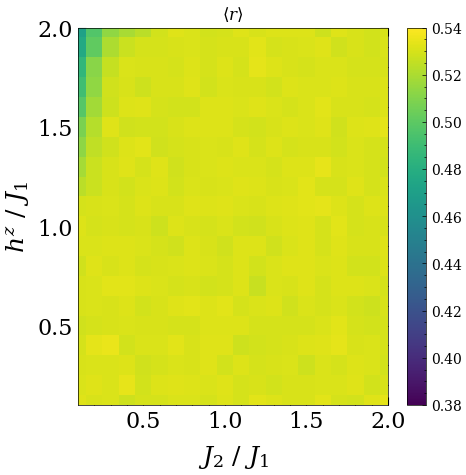

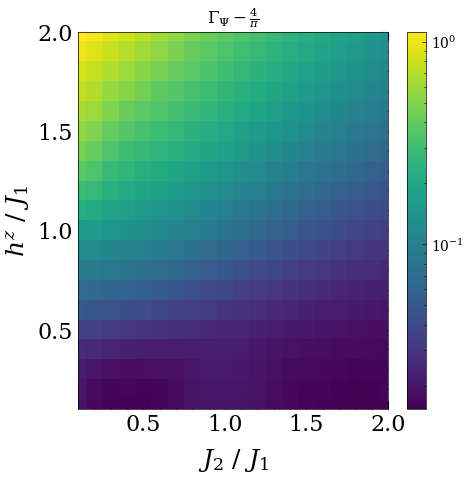

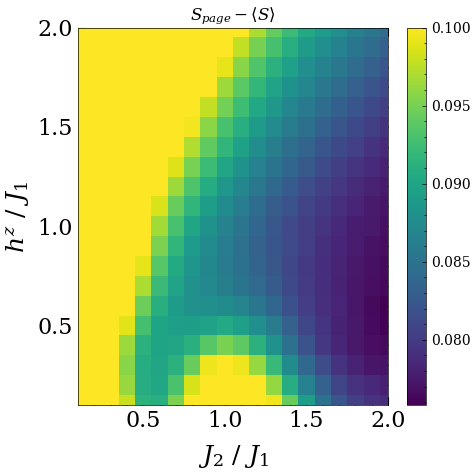

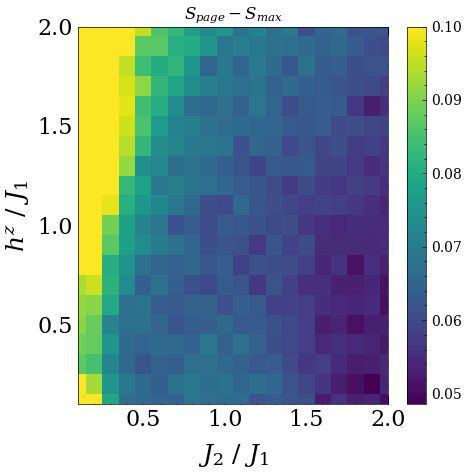

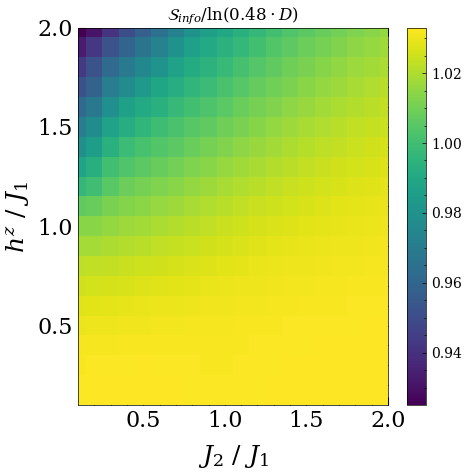

In [218]:

skipX = int(J_range.size / 6)
skipY = int(x_range.size / 6)

X, Y = np.meshgrid(J_range, x_range)

fig, ax_gaps = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_gaps.pcolormesh(X, Y, gap_ratio_im, shading='nearest', vmin=0.38, vmax=0.54)
ax_gaps.set_title(r"$\langle r\rangle$")
fig.colorbar(p)

fig, ax_gauss = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_gauss.pcolormesh(X, Y, gaussianity_im, shading='nearest', norm=matplotlib.colors.LogNorm())
ax_gauss.set_title(r"$\Gamma_\Psi - \frac{4}{\pi}$")
fig.colorbar(p)

fig, ax_ent = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_ent.pcolormesh(X, Y, ent_im, shading='nearest', vmax=0.1)
ax_ent.set_title(r"$S_{page} - \langle S\rangle$")
fig.colorbar(p)

fig, ax_outlier = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_outlier.pcolormesh(X, Y, ent_max_im, shading='nearest', vmax=0.1)
ax_outlier.set_title(r"$S_{page} - S_{max}$")
fig.colorbar(p)

fig, ax_info = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_info.pcolormesh(X, Y, info_ent_im, shading='nearest')
ax_info.set_title(r"$\mathcal{S}_{info}/\ln(0.48\cdot D)$")
fig.colorbar(p)

for ax in [ax_info, ax_ent, ax_outlier, ax_gaps, ax_gauss]:

    hfun.set_plot_elements(axis = ax, ylabel = "h^z\ /\ J_1", xlabel = "J_2\ /\ J_1", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    tics = [0.5, 1.0, 1.5, 2.0]
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)
    ax.set_yticks(tics)
    ax.set_xticks(tics)
    ax.set_xlim(min(J_range), max(J_range))
    ax.set_ylim(min(x_range), max(x_range))

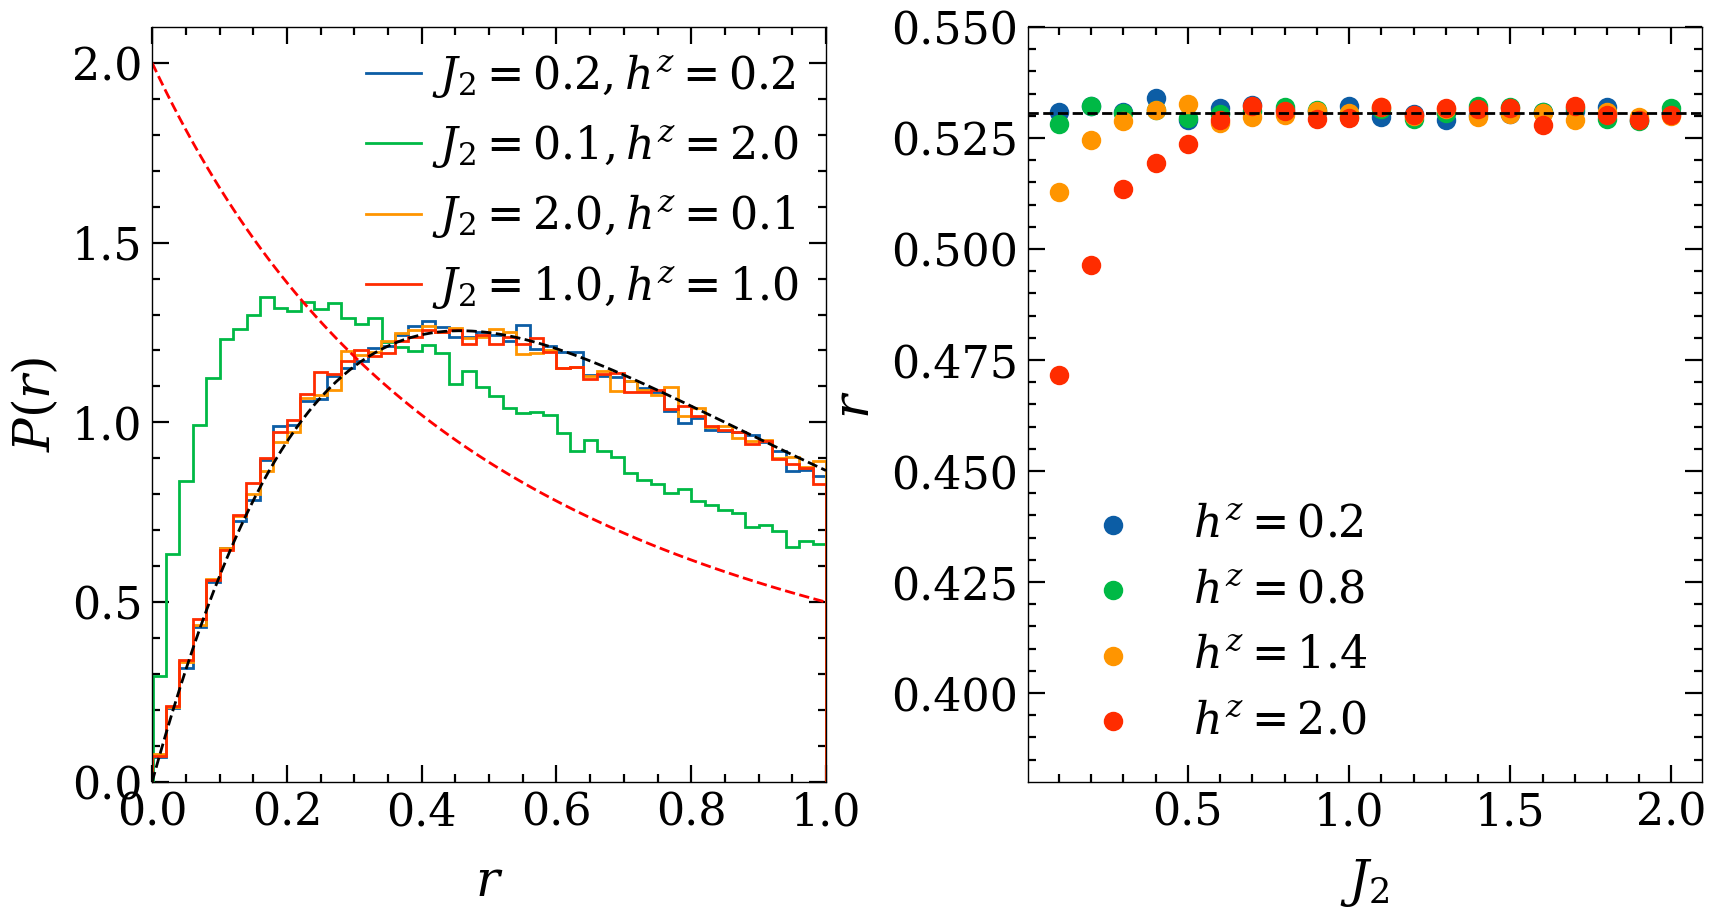

In [ ]:
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)


## --- LEFT PANEL
points_to_plot = [[0.2, 0.2], [0.1, 2.0], [2.0, 0.1], [1.0, 1.0]]
xpoi = np.linspace(0, 1, 100)
axis[0].plot(xpoi, 27 / 4 * ( xpoi + xpoi**2 ) / ( 1 + xpoi + xpoi**2 )**(5/2), linestyle='--', color='black')
axis[0].plot(xpoi, 2 / (1 + xpoi)**2, linestyle='--', color='red')

for [J2, xx] in points_to_plot:
    ii = list(x_range).index(xx)
    jj = list(J_range).index(J2)
    gaps = np.array(list(level_spacings_im[ii][jj]) + list(level_spacings[ii][jj]))
    wH = np.mean(gaps)
    gaps /= wH
    level_stats = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])
    data = level_stats
    hist, bins = np.histogram(data, bins=50, normed=True)
    axis[0].stairs(hist, bins, label=r"$J_2=%.1f$"%J2 + scan_lab + r"$=%.1f$"%(xx))
axis[0].set_xlim(0,1)    

## --- RIGHT PANEL

J_to_plot = [0.2, 0.8, 1.4, 2.0]
for J2 in J_to_plot:
    ii = list(J_range).index(J2)
    r = gap_ratio_im[ii]
    axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2))

axis[1].set_ylim(0.38, 0.55)
axis[1].axhline(y=0.5307, ls='--', color='black')


## --- COMSETICS
hfun.set_plot_elements(axis = axis[0], ylabel = "P(r)", xlabel = "r", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[0].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))


hfun.set_plot_elements(axis = axis[1], ylabel = "r", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=True, xlim=(None, None), ylim=(None, None))
for ax in list(axis):
    ax.set_xscale('linear')    
    ax.set_yscale('linear')
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)

fig.subplots_adjust(wspace=0.3, hspace=0.3)


## ALL SECTORS

In [6]:
ent_all = np.zeros((len(x_range), len(J_range)), dtype=np.float)
gauss_all = np.zeros((len(x_range), len(J_range)), dtype=np.float)
Smin = 1e10
indices = [0, 0]
for ii in range(len(x_range)):
   for jj in range(len(J_range)):
      dims_here_re = len(level_spacings[ii][jj]) + len(real_sectors)
      dims_here_im = len(level_spacings_im[ii][jj]) + len(imag_sectors)
      S = (dims_here_re * ent[ii, jj] + dims_here_im * ent_im[ii, jj]) / (dims_here_re + dims_here_im)
      if S < Smin: 
         Smin = S
         indices = [ii, jj]
      ent_all[ii, jj] = S
      gauss_all[ii, jj] = (gaussianity[ii, jj] + gaussianity_im[ii, jj])/2.

print(indices)
print(x_range[indices[0]], J_range[indices[1]])

[5, 19]
0.6 2.0


### COMBINE BY HAND

#### HEATMAPS

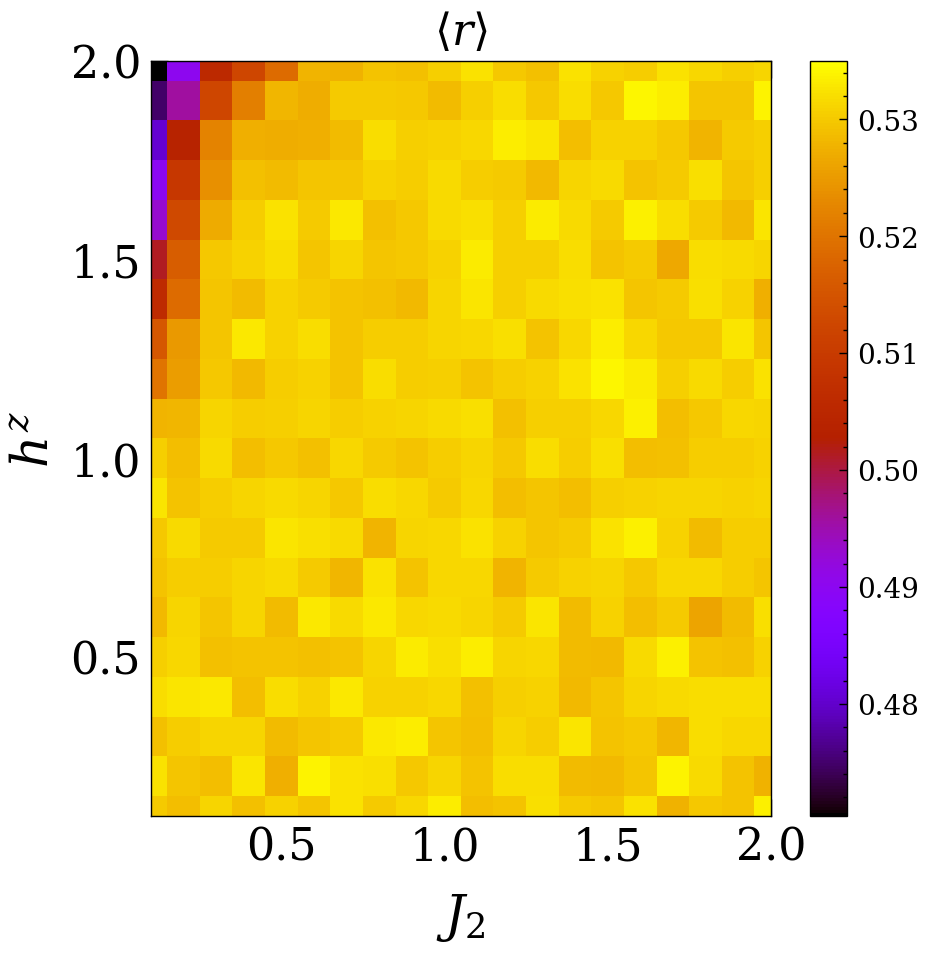

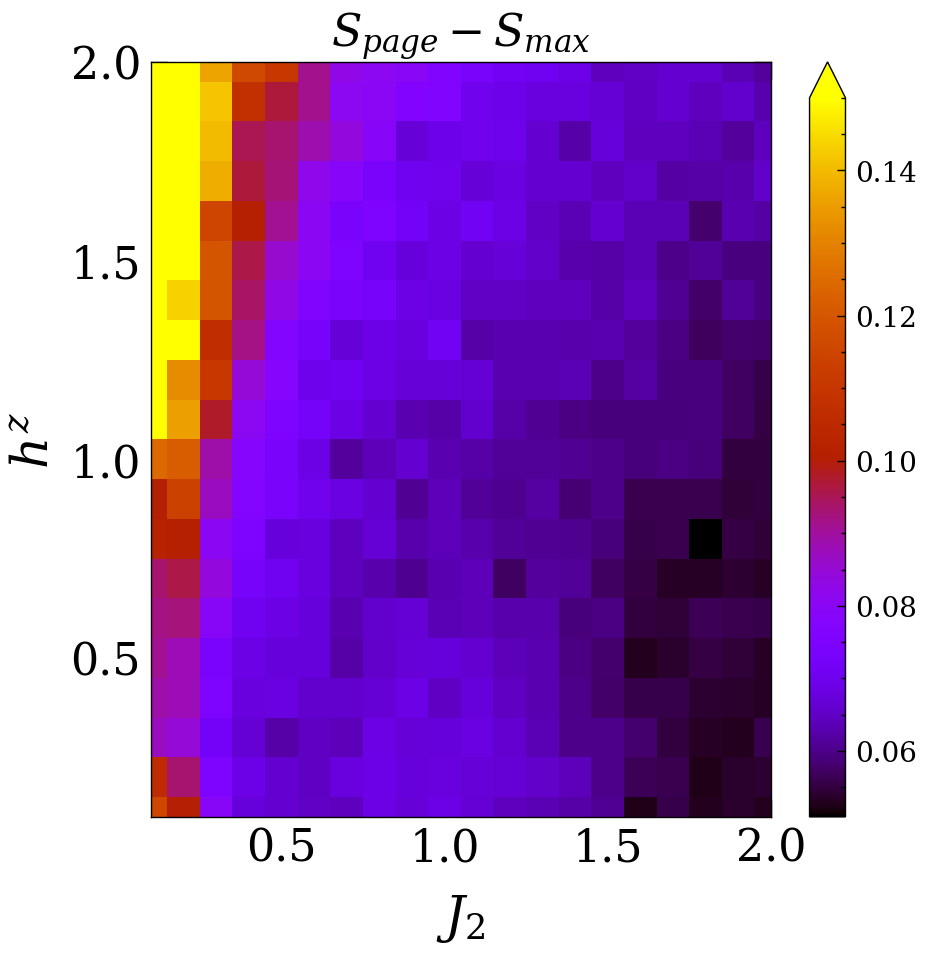

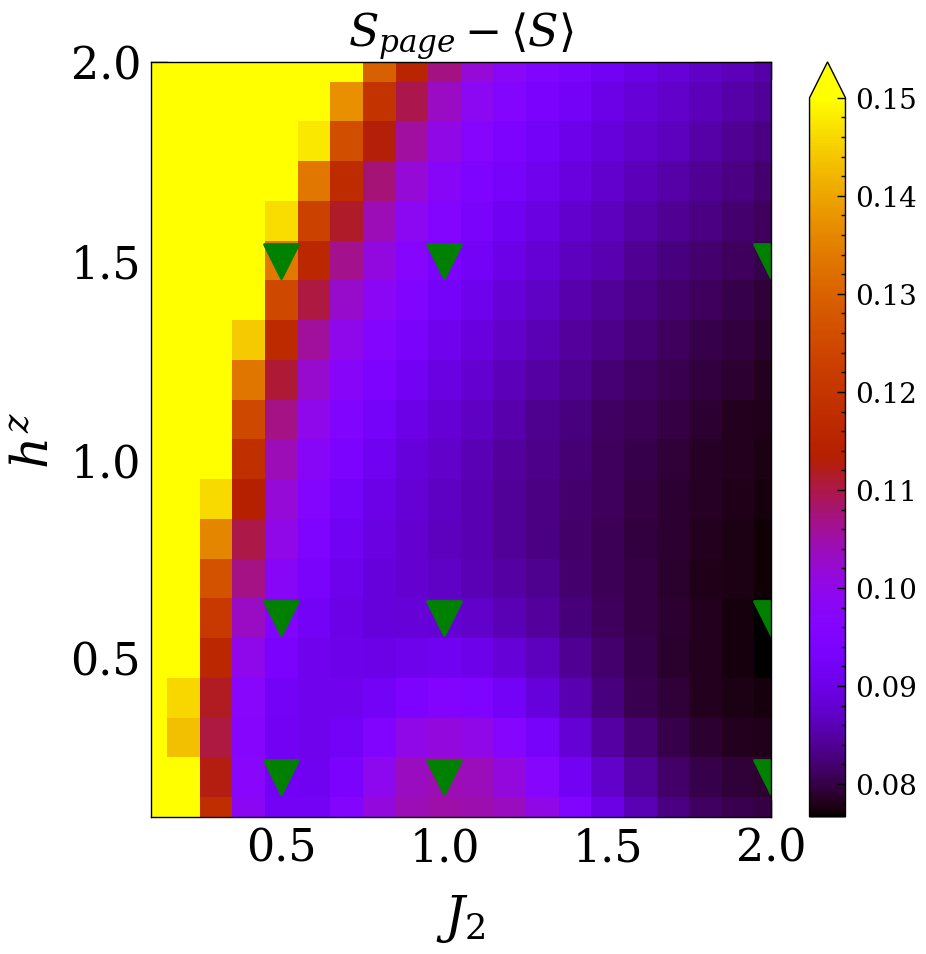

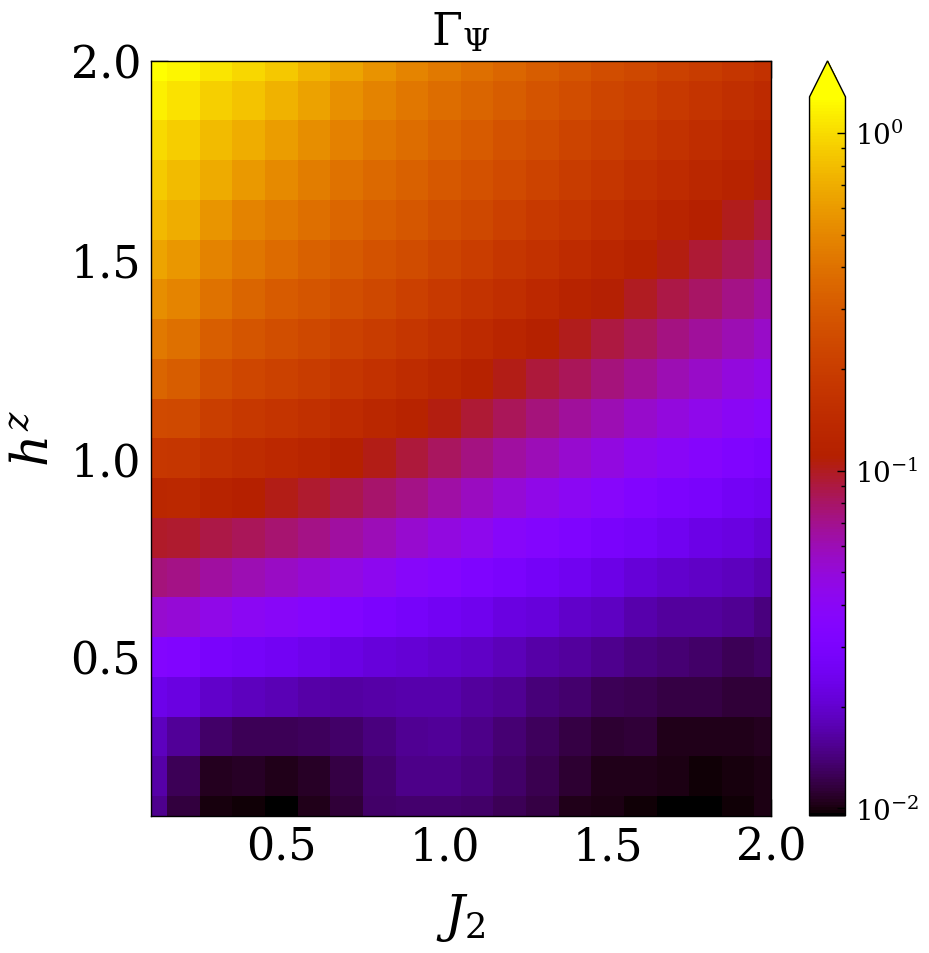

In [432]:

x_range = hfun.regspace(0.1, 2.1, 0.1)
J_range = hfun.regspace(0.1, 2.1, 0.1)
skipX = int(J_range.size / 4)
skipY = int(x_range.size / 4)

def add_stuff(ax):
    hfun.set_plot_elements(axis = ax, ylabel = "\\Delta_1" if use_Sz_sym else "h^z", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    tics = [0.5, 1.0, 1.5, 2.0]
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)
    ax.set_yticks(tics)
    ax.set_xticks(tics)
    ax.set_xlim(min(J_range), max(J_range))
    ax.set_ylim(min(x_range), max(x_range))


aaah_cmap = 'gnuplot'

X, Y = np.meshgrid(J_range, x_range)

fig, ax_gaps = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gaps.pcolormesh(X, Y, (gap_ratio + gap_ratio_im)/2, shading='nearest', vmax=0.535, cmap=aaah_cmap)
ax_gaps.set_title(r"$\langle r\rangle$", fontsize=16)
add_stuff(ax_gaps)
fig.colorbar(p)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_r_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_r_map.png', bbox_inches = 'tight', padding=0.02)

fig, ax_outlier = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_outlier.pcolormesh(X, Y, np.maximum(ent_max_im, ent_max), shading='nearest', vmax=0.15, cmap=aaah_cmap)
ax_outlier.set_title(r"$S_{page} - S_{max}$", fontsize=16)
fig.colorbar(p, extend='max')
add_stuff(ax_outlier)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_entMax_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_entMax_map.png', bbox_inches = 'tight', padding=0.02)

#fig, ax_info = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
#p = ax_info.pcolormesh(X, Y, (info_ent + info_ent_im)/2, shading='nearest')
#ax_info.set_title(r"$\mathcal{S}_{info}/\ln(0.48\cdot D)$")
#fig.colorbar(p)


fig, ax_ent = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_ent.pcolormesh(X, Y, ent_all, cmap=aaah_cmap, shading='nearest', vmax=0.15)
ax_ent.set_title(r"$S_{page} - \langle S\rangle$", fontsize=16)
fig.colorbar(p, extend='max')
add_stuff(ax_ent)

for J2 in [0.5, 1.0, 2.0]:
    for hz in [0.2, 0.6, 1.5]:
        ax_ent.scatter(J2, hz, s=150, marker='v', c='green', facecolor='None')
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_ent_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_ent_map.png', bbox_inches = 'tight', padding=0.02)


fig, ax_gauss = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gauss.pcolormesh(X, Y, gauss_all, cmap=aaah_cmap, shading='nearest', norm=matplotlib.colors.LogNorm())
ax_gauss.set_title(r"$\Gamma_\Psi$", fontsize=16)
fig.colorbar(p, extend='max')
add_stuff(ax_gauss)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_Gauss_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'../swap results/MAXIMAL_ENTROPY/Fig_Gauss_map.png', bbox_inches = 'tight', padding=0.02)

#for ax in [ax_ent, ax_outlier, ax_gaps]:

#### GAP RATIO & ENTROPY

     da   Jb  gapratios
0   0.2  0.1   0.436051
1   0.8  0.1   0.498029
2   1.4  0.1   0.484221
3   2.0  0.1   0.455784
4   0.2  0.2   0.521299
..  ...  ...        ...
75  2.0  1.9   0.530751
76  0.2  2.0   0.530937
77  0.8  2.0   0.531110
78  1.4  2.0   0.530685
79  2.0  2.0   0.529423

[80 rows x 3 columns]


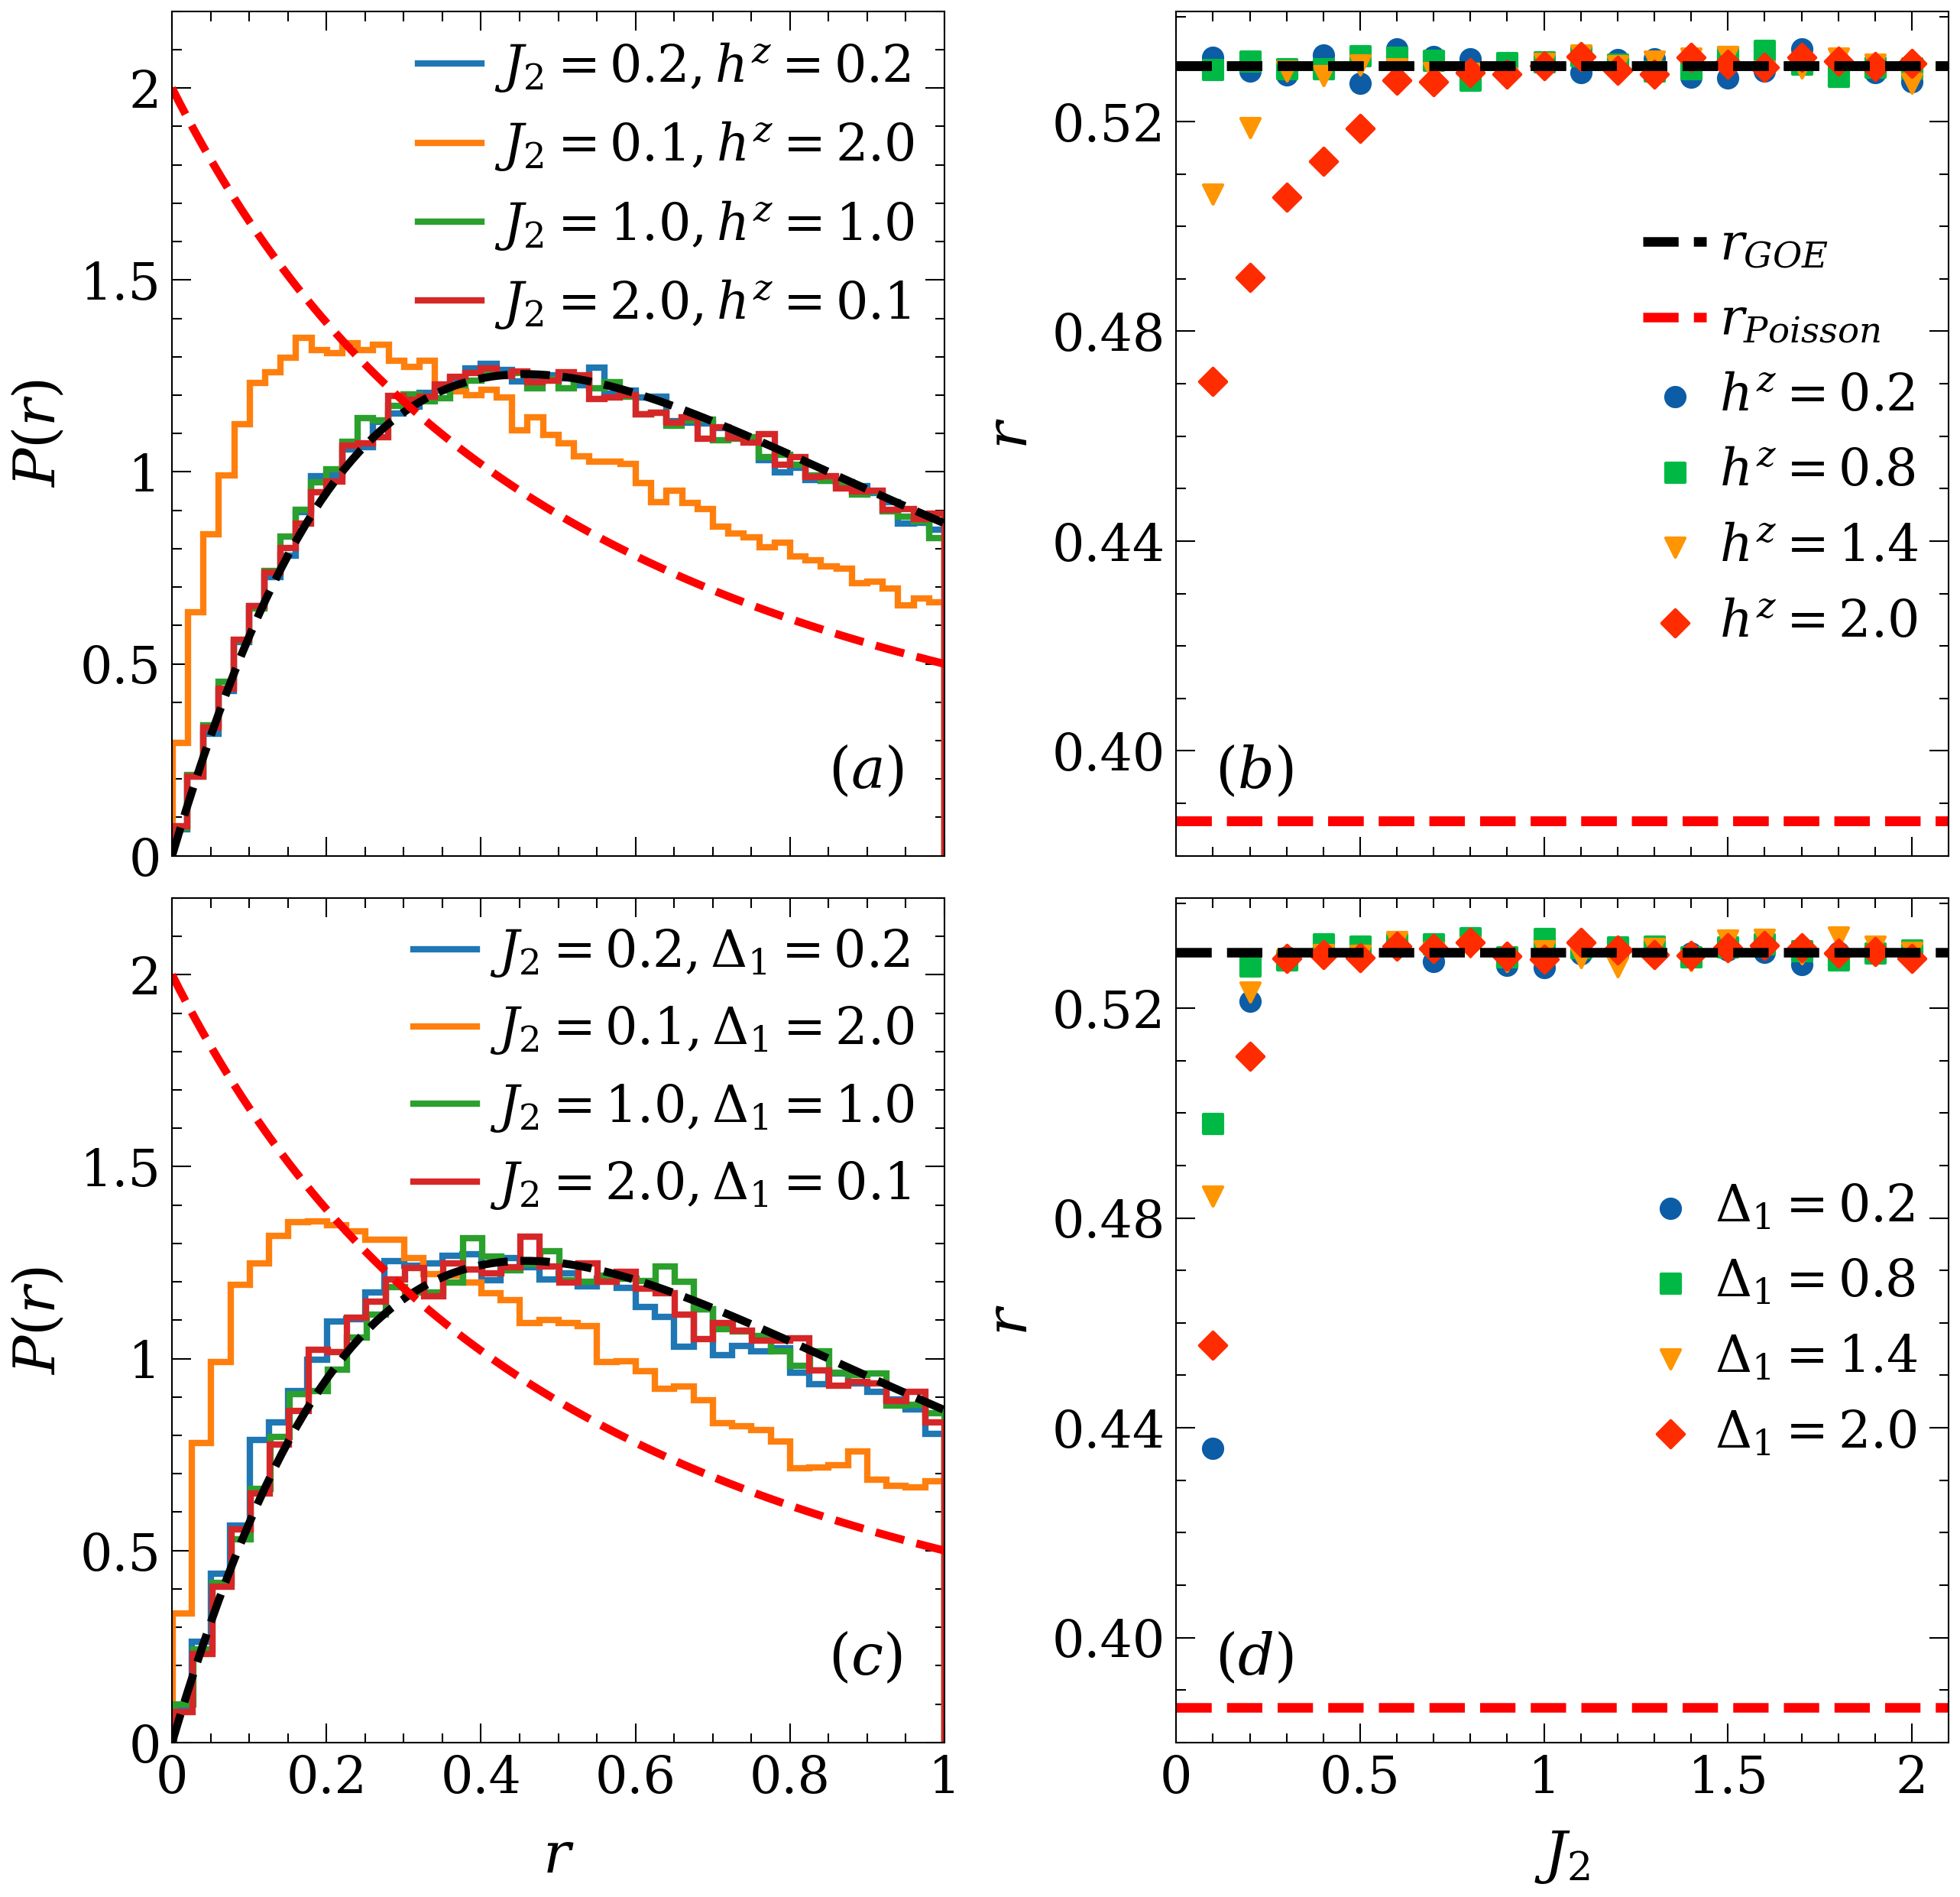

In [85]:
reload_modules()
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,10), dpi = 300)
axis = np.array(axis).flatten()

## --- LEFT PANEL
points_to_plot = [[0.2, 0.2], [0.1, 2.0], [1.0, 1.0], [2.0, 0.1]]
xpoi = np.linspace(0, 1, 100)

for ax in [axis[0], axis[2]]:
    ax.plot(xpoi, 27 / 4 * ( xpoi + xpoi**2 ) / ( 1 + xpoi + xpoi**2 )**(5/2), linestyle='--', color='black', lw=2.5)
    ax.plot(xpoi, 2 / (1 + xpoi)**2, linestyle='--', color='red', lw=2.5)
    ax.set_xlim(0,1)  
    ax.set_ylim(0.0,2.2)

for [J2, xx] in points_to_plot:
    ii = list(x_range).index(xx)
    jj = list(J_range).index(J2)
    gaps = np.array(list(level_spacings_im[ii][jj]) + list(level_spacings[ii][jj]))
    level_stats = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])
    c = next(colors_ls_cyc)
    hist, bins = np.histogram(level_stats, bins=50, normed=True)
    axis[0].stairs(hist, bins, label=r"$J_2=%.1f,$"%J2 + r"$h^z=%.1f$"%(xx), linewidth=2, color=c)
    with open(f'MAXIMAL_ENTROPY_DATA/SU/gap_ratio/su_gap_ratio_hist_L=20,J2={J2},d1={xx}.npy', 'rb') as file:
        data = np.load(file, allow_pickle=True)
        axis[2].stairs(data[1], data[0], label=r"$J_2=%.1f,$"%J2 + r"$\Delta_1=%.1f$"%(xx), linewidth=2, color=c)
    
    # ARROWS
    #dx = 0.07 if J2 < 0.2 else 0
    #r = (gap_ratio_im[ii] + gap_ratio[ii]) / 2.
    #r = np.mean(level_stats[ len(level_stats) // 4 : 3 * len(level_stats) // 4 ])
    #axis[1].annotate("", xy=(J_range[jj], r[jj]), xytext=(dx + J_range[jj], r[jj] - 0.015), arrowprops=dict(arrowstyle="->"))

    


## --- RIGHT PANEL
gap_ratio_su = pd.read_csv(f'MAXIMAL_ENTROPY_DATA/SU/gap_ratio/su_gap_ratio_L=20.csv')
print(gap_ratio_su)

h_to_plot = [0.2, 0.8, 1.4, 2.0]
for idx, xx in enumerate(h_to_plot):
    mar = next(markers)
    ii = list(x_range).index(xx)
    r = (gap_ratio_im[ii] + gap_ratio[ii]) / 2.
    axis[1].scatter(J_range, r, label=r"$h^z=%.1f$"%(xx), marker=mar)

    r = gap_ratio_su[gap_ratio_su['da'] == xx]['gapratios']
    J_su = gap_ratio_su[gap_ratio_su['da'] == xx]['Jb']
    axis[3].scatter(J_su, r, label=r"$\Delta_1=%.1f$"%(xx), marker=mar)

axis[1].axhline(y=0.5307, ls='--', lw=3, color='black', label=r"$r_{GOE}$")
axis[1].axhline(y=0.3867, ls='--', lw=3, color='red', label=r"$r_{Poisson}$")
## --- COMSETICS
hfun.set_plot_elements(axis = axis[0], ylabel = "P(r)", xlabel = "\ ", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[0].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))

hfun.set_plot_elements(axis = axis[2], ylabel = "P(r)", xlabel = "r", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[2].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))

hfun.set_plot_elements(axis = axis[1], ylabel = "r", xlabel = "\ ", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[1].legend(loc = 'center right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 0.5))

hfun.set_plot_elements(axis = axis[3], ylabel = "r", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[3].legend(loc = 'center right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 0.5))
for i, ax in enumerate(axis):
    ax.set_xscale('linear')    
    ax.set_yscale('linear')
    ax.tick_params(axis="both",which='major',direction="in",length=6, labelsize=16)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)
    if i > 1:   ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))
    else:       ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))
    ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))

for ax in [axis[1], axis[3]]:
    ax.set_ylim(0.38, 0.541)
    ax.set_xlim(0.0,2.1)
    ax.axhline(y=0.5307, ls='--', lw=3, color='black', label=r"$r_{GOE}$")
    ax.axhline(y=0.3867, ls='--', lw=3, color='red', label=r"$r_{Poisson}$")
    yticks = [0.4 + 0.04 * ala for ala in range(4)]   
    tick_labels = ["%.2f"%ytic for ytic in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(tick_labels)    

axis[0].set_xlim(0,1)  
axis[0].set_ylim(0.0,2.2)
axis[2].set_xlim(0,1)  
axis[2].set_ylim(0.0,2.2)

axis[0].annotate(r"$(a)$", xy=(0.85, 0.08), fontsize=18, xycoords='axes fraction')
axis[1].annotate(r"$(b)$", xy=(0.05, 0.08), fontsize=18, xycoords='axes fraction')
axis[2].annotate(r"$(c)$", xy=(0.85, 0.08), fontsize=18, xycoords='axes fraction')
axis[3].annotate(r"$(d)$", xy=(0.05, 0.08), fontsize=18, xycoords='axes fraction')
fig.subplots_adjust(wspace=0.3, hspace=0.05)

plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_gap_ratio.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_gap_ratio.png", bbox_inches = 'tight', pad_inches=0.02)

     da   Jb  S_f=250.000     S_min     S_max
0   0.2  0.1     5.145327  3.521299  6.154004
1   0.8  0.1     5.548282  3.988307  6.082242
2   1.4  0.1     5.415910  4.173314  6.029686
3   2.0  0.1     5.166068  3.798941  5.933572
4   0.2  0.2     5.891369  4.581057  6.203818
..  ...  ...          ...       ...       ...
75  2.0  1.9     6.242781  6.206433  6.277453
76  0.2  2.0     6.264564  6.227107  6.298405
77  0.8  2.0     6.259171  6.221811  6.292071
78  1.4  2.0     6.252358  6.215615  6.286340
79  2.0  2.0     6.244311  6.205903  6.277893

[80 rows x 5 columns]


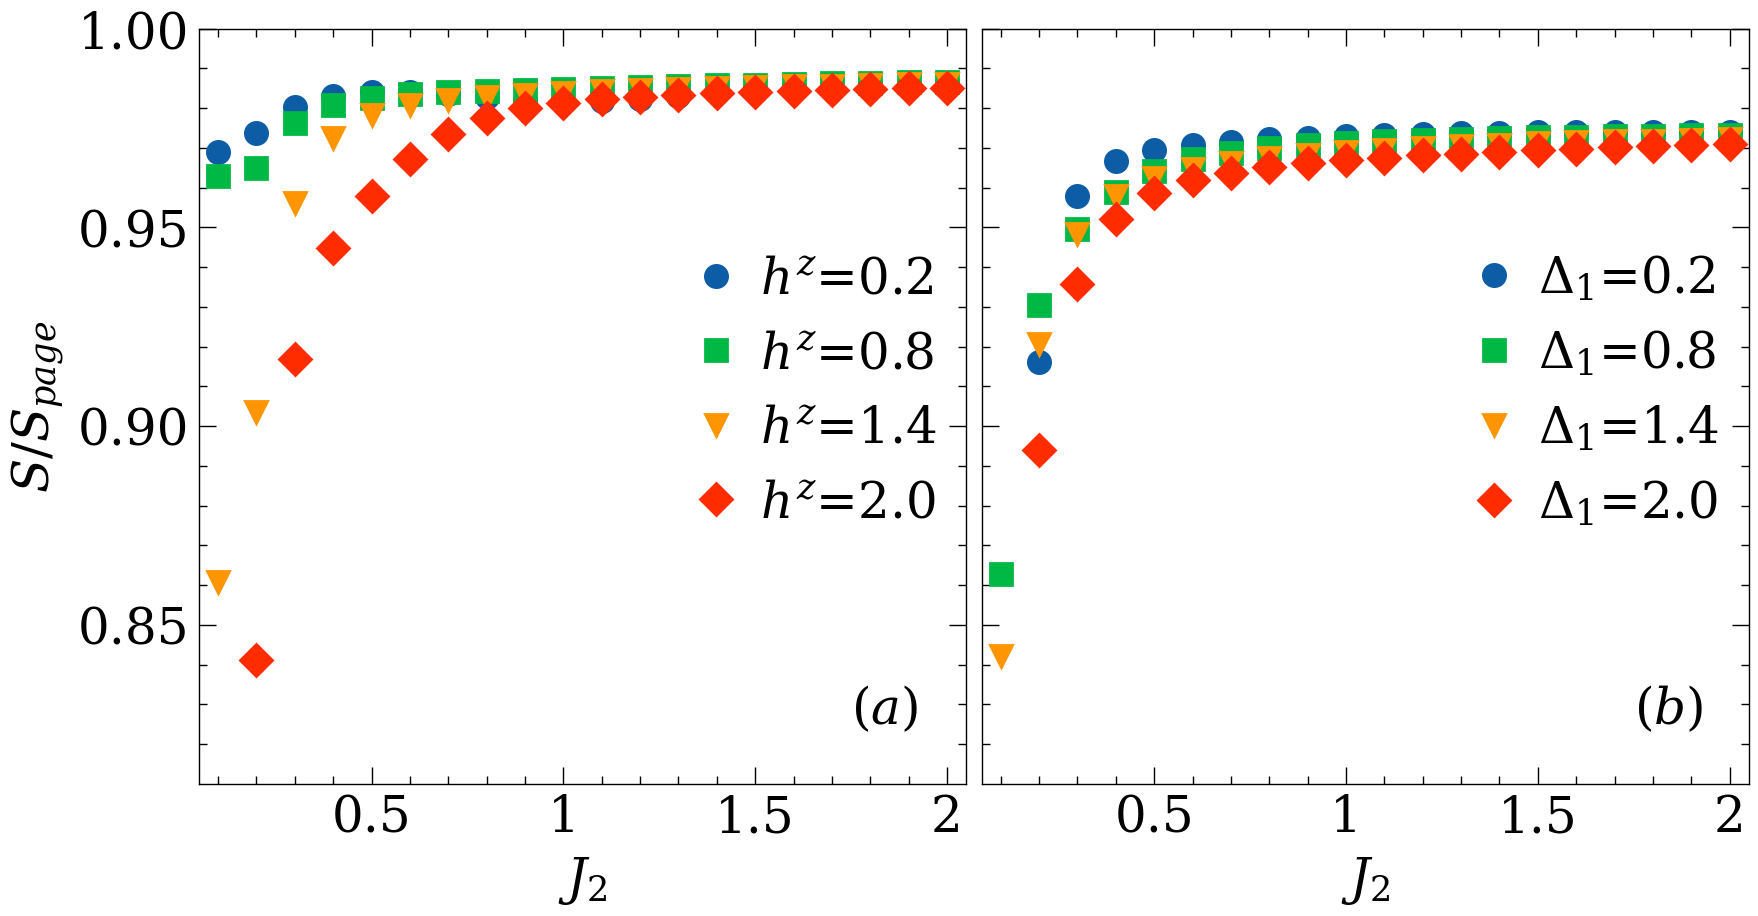

In [461]:
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

label_b = '$\Delta_1$' if use_Sz_sym else  '$h^z$'
label_a = '$J_2$'
f = 1/2.
L = 18
# plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5), dpi=200, sharey=True)


h_to_plot = [0.2, 0.8, 1.4, 2.0]
entrop = pd.read_csv(f'MAXIMAL_ENTROPY_DATA/SU/entropy_sweep/su_entro_L=20.csv')
print(entrop)
for xx in h_to_plot:
    ii = list(x_range).index(xx)
    #axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2), marker=next(markers))
    La = int(f * L)
    mar = next(markers)
    axes[0].plot(J_range, (page_result(La, La) - ent_all[ii]) / page_result(La, La), label = f'$h^z$=${xx}$', linewidth=0, marker = mar, markersize=8)

    J_su = entrop[entrop['da'] == xx]['Jb']
    S_su = entrop[entrop['da'] == xx]['S_f=250.000']
    La = int(f * 20)
    axes[1].plot(J_su, S_su / page_result(La, La), label = f'$\Delta_1$=${xx}$', linewidth=0, marker = mar, markersize=8)
    
#ax.axhline(goe, label = '$r_{GOE}$', linestyle = "--", linewidth=3, color='black')
axes[0].set_ylabel('$S / S_{page}$', size = 18)

for ax in axes:
    ax.set_xlabel(label_a, size = 18)
    #ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', rotation = 0, labelsize=18)
    ax.tick_params(axis="both",which='major',direction="in", length=6)
    ax.tick_params(axis="both",which='minor',direction="in", length=3)

    ax.legend(loc = 'center right', frameon=False, fontsize=18, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 0.52))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    ax.set_xlim(0.05, 2.05)
    ax.set_ylim(0.81, 1.0)
#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#ax.set_title(title)
#ax.legend(fontsize = 18)

axes[0].annotate(r"$(a)$", xy=(0.85, 0.08), fontsize=18, xycoords='axes fraction')
axes[1].annotate(r"$(b)$", xy=(0.85, 0.08), fontsize=18, xycoords='axes fraction')
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_ent.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_ent.png", bbox_inches = 'tight', pad_inches=0.02)

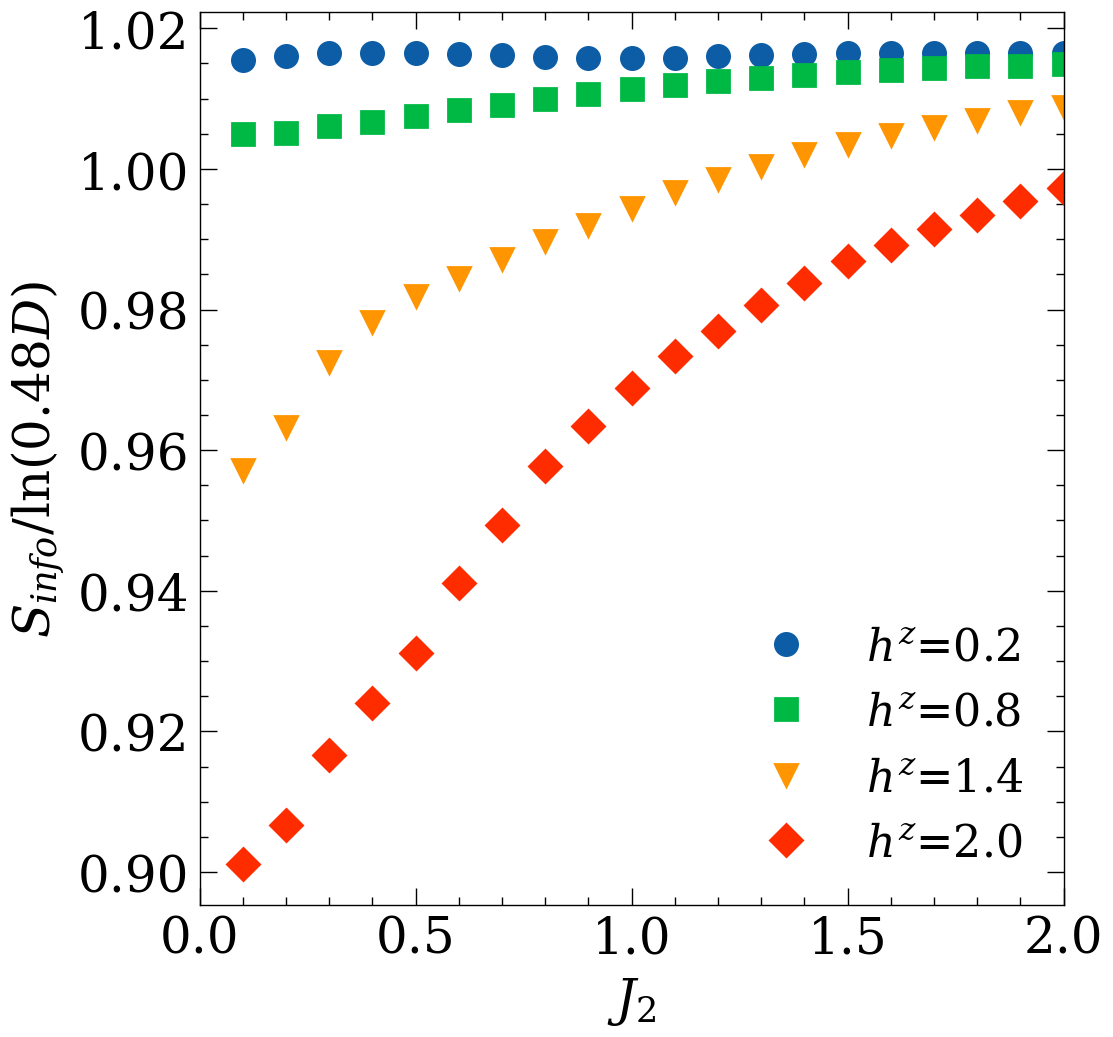

In [ ]:
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

label_b = '$\Delta_1$' if use_Sz_sym else  '$h^z$'
label_a = '$J_2$'
f = 1/2.

# plot
fig, ax = plt.subplots(1, figsize = (5, 5), dpi=200)
fig.tight_layout()
for xx in h_to_plot:
    ii = list(x_range).index(xx)
    #axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2), marker=next(markers))
    ax.plot(J_range, (info_ent + info_ent_im)[ii] / 2., label = f'{label_b}=${xx}$', linewidth=0, marker = next(markers), markersize=8)
    
#ax.axhline(goe, label = '$r_{GOE}$', linestyle = "--", linewidth=3, color='black')
ax.set_xlabel(label_a, size = 18)
ax.set_ylabel('$S_{info} / \ln(0.48D)$', size = 18)
ax.set_xlim(0.0,2.0)
#ax.set_ylim(1.015, 1.030)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', rotation = 0, labelsize=18)

ax.tick_params(axis="both",which='major',direction="in", length=6)
ax.tick_params(axis="both",which='minor',direction="in", length=3)

#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#ax.set_title(title)
ax.legend(fontsize = 16)

$J_2=2.0$

$h^z=0.2, 0.8, 1.5$

$L=14, 16,.., 20, 22$

# SIZE SCALING

## LOADERS

### PBC

In [7]:
hz_points = [0.2, 0.6, 0.8, 1.5] # hz or delta
J_points = [0.5, 1.0, 2.0]
num = 100
sizes = np.arange(16, 27, 2) if use_Sz_sym else np.arange(12, 24, 2)

J = 2.0
hz = 0.6
use_J_change = True

use_Sz_sym = False

def get_entropy_scaling(J, hz, get_states = False, fraction = lambda dim: 100):

    S_re = []
    S_im = []
    dims_re = []
    dims_im = []

    S_max_re = []
    S_max_im = []
    S_min_re = []
    S_min_im = []

    edge = []
    hist = []
    gauss = []
    for L in sizes:

        real_sectors, imag_sectors = get_sectors(L)
        #print(L, real_sectors, imag_sectors)
        hist_tmp = []
        edge_tmp = []

        ent_max_re = -1e10
        ent_min_re = 1e10
        entropy_re = []
        coeffs_re_tmp = []
        dims_re_tmp = []
        for [ks, ps, xs] in real_sectors:
            status, energies, entropy, V = get_data(L=L, J=J, xx=hz, 
                                                    ksym = ks, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                    if get_states:  coeffs_re_tmp += list(V)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    dim = energies.size
                    num = fraction(dim)

                    my_min = int(index_meanE - num / 2)
                    if my_min < 0:
                        my_min = 0;  
                        print(f'System size too small, dim(H)={dim}')

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = entropy[my_min : my_max]
                    if max(sample) > ent_max_re: ent_max_re = max(sample)
                    if min(sample) < ent_min_re: ent_min_re = min(sample)

                    entropy_re.append(np.mean(sample))
                    dims_re_tmp.append(dim)
    
        ent_max_im = -1e10
        ent_min_im = 1e10
        entropy_im = []
        coeffs_im_tmp = []
        dims_im_tmp = []
        for [ks, ps, xs] in imag_sectors:
            status, energies, entropy, V = get_data(L=L, J=J, xx=hz, 
                                                    ksym = ks, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                if get_states:  coeffs_im_tmp += 2 * list(V)
                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                dim = energies.size
                num = fraction(dim)
                    
                my_min = int(index_meanE - num / 2)
                if my_min < 0: 
                    my_min = 0;  
                    print(f'System size too small, dim(H)={dim}')

                my_max = int(index_meanE + num / 2) 
                if my_max >= dim: my_max = dim

                sample = entropy[my_min : my_max]
                if max(sample) > ent_max_im: ent_max_im = max(sample)
                if min(sample) < ent_min_im: ent_min_im = min(sample)

                entropy_im.append(np.mean(sample))
                entropy_im.append(np.mean(sample))
                dims_im_tmp.append(dim)
                dims_im_tmp.append(dim)

        #print(entropy_im)
        S_re.append(np.array(entropy_re))
        S_im.append(np.array(entropy_im))

        dims_re.append(np.array(dims_re_tmp))
        dims_im.append(np.array(dims_im_tmp))
        
        S_max_re.append(np.nan if ent_max_re < 0 else ent_max_re)
        S_max_im.append(np.nan if ent_max_im < 0 else ent_max_im)

        S_min_re.append(np.nan if ent_min_re > 1e6 else ent_min_re)
        S_min_im.append(np.nan if ent_min_im > 1e6 else ent_min_im)

        coeffs = coeffs_re_tmp + coeffs_im_tmp
        hista, bins = np.histogram(coeffs, bins=200, normed=True)
        edge.append(bins)
        hist.append(hista)

        gauss.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2)
     
    return S_re, S_im, S_max_re, S_max_im, S_min_re, S_min_im, dims_re, dims_im, edge, hist, gauss


def get_entropy_scaling_combine_sectors(J, hz, get_states = False, fraction = lambda dim: 100):

    S_pbc = []
    dims_re = []
    dims_im = []

    S_max_pbc = []
    S_min_pbc = []

    edge = []
    hist = []
    gauss = []
    for L in sizes:

        real_sectors, imag_sectors = get_sectors(L)
        #print(L, real_sectors, imag_sectors)
        hist_tmp = []
        edge_tmp = []
        coeffs_re_tmp = []
        dims_re_tmp = []

        entropies = []
        energies = []
        for [ks, ps, xs] in real_sectors:
            status, E, S, V = get_data(L=L, J=J, xx=hz, 
                                                    ksym = ks, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                if get_states:  coeffs_re_tmp += list(V)
                energies = [*energies, *E]
                entropies = [*entropies, *S]
                dims_re_tmp.append(E.size)

        coeffs_im_tmp = []
        dims_im_tmp = []
        for [ks, ps, xs] in imag_sectors:
            status, E, S, V = get_data(L=L, J=J, xx=hz, 
                                                    ksym = ks, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                if get_states:  coeffs_im_tmp += 2 * list(V)
                energies = [*energies, *E, *E]
                entropies = [*entropies, *S, *S]
                dims_im_tmp.append(E.size)
                dims_im_tmp.append(E.size)

        if len(energies) > 0:
            indc = np.array(energies).argsort()
            energies = np.array(energies)[indc]
            entropies = np.array(entropies)[indc]

            E_av = np.mean(energies)
            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
            num = fraction(len(energies))

            sample = entropies[int(index_meanE - num // 2) : int(index_meanE + num // 2)]
            S = np.mean(sample)
            
            S_pbc.append( np.mean(sample))
            S_max_pbc.append(max(sample))
            S_min_pbc.append(min(sample))
        else:
            S_pbc.append(np.nan)
            S_max_pbc.append(np.nan)
            S_min_pbc.append(np.nan)

        dims_re.append(np.array(dims_re_tmp))
        dims_im.append(np.array(dims_im_tmp))

        coeffs = coeffs_re_tmp + coeffs_im_tmp
        hista, bins = np.histogram(coeffs, bins=200, normed=True)
        edge.append(bins)
        hist.append(hista)

        gauss.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2)
     
    return S_pbc, S_max_pbc, S_min_pbc, dims_re, dims_im, edge, hist, gauss


### OBC

In [8]:
num = 100
sizes_obc = np.arange(12, 23, 2) if use_Sz_sym else np.arange(10, 20, 2)

J = 2.0
hz = 0.6
use_J_change = True

use_Sz_sym = False

def get_entropy_scaling_obc(J, hz, get_states = False, fraction = lambda dim: 100, with_small_size = False):
    global sizes_obc
    S_obc = []
    dims_obc = []
    S_max_obc = []
    S_min_obc = []

    edge_obc = []
    hist_obc = []
    gauss_obc = []
    if with_small_size:
        sizes_obc = np.arange(10, 22, 2) if use_Sz_sym else np.arange(8, 20, 2)
    for L in sizes_obc:

        real_sectors, imag_sectors = get_sectors(L)
        #print(L, real_sectors)
        hist_tmp = []
        edge_tmp = []

        ent_max = -1e10
        ent_min = 1e10
        entropy_tmp = []
        coeffs = []
        dims_tmp = []
        for [ks, ps, xs] in real_sectors:
            status, E, S, V = get_data_obc(L=L, J=J, xx=hz, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                    if get_states:  coeffs += list(V)

                    E_av = np.mean(E)
                    index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    dim = E.size
                    num = fraction(dim)
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0:
                        my_min = 0;  
                        print(f'System size too small, dim(H)={dim}')

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = S[my_min : my_max]
                    if max(sample) > ent_max: ent_max = max(sample)
                    if min(sample) < ent_min: ent_min = min(sample)

                    entropy_tmp.append(np.mean(sample)) 
                    dims_tmp.append(dim)


        #print(entropy_tmp)
        S_obc.append(np.array(entropy_tmp))

        dims_obc.append(np.array(dims_tmp))
        
        S_max_obc.append(np.nan if ent_max < 0 else ent_max)
        S_min_obc.append(np.nan if ent_min > 1e8 else ent_min)
        if get_states:
            hista, bins = np.histogram(coeffs, bins=100, normed=True)
            edge_obc.append(bins)
            hist_obc.append(hista)
            gauss_obc.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2)

    return S_obc, S_max_obc, S_min_obc, dims_obc, edge_obc, hist_obc, gauss_obc

    num = 100
sizes_obc = np.arange(12, 23, 2) if use_Sz_sym else np.arange(10, 20, 2)

J = 2.0
hz = 0.6
use_J_change = True

use_Sz_sym = False


""" 

"""
def get_entropy_scaling_obc_combine_sectors(J, hz, get_states = False, fraction = lambda dim: 100, with_small_size = False):
    global sizes_obc
    S_obc = []
    dims_obc = []
    S_max_obc = []
    S_min_obc = []

    edge_obc = []
    hist_obc = []
    gauss_obc = []
    if with_small_size:
        sizes_obc = np.arange(10, 22, 2) if use_Sz_sym else np.arange(8, 20, 2)
    for L in sizes_obc:

        real_sectors, imag_sectors = get_sectors(L)
        #print(L, real_sectors)
        hist_tmp = []
        edge_tmp = []

        ent_max = -1e10
        ent_min = 1e10
        entropy_tmp = []
        coeffs = []
        dims_tmp = []

        energies = []
        entropies = []

        meanS = 0
        for [ks, ps, xs] in real_sectors:
            status, E, S, V = get_data_obc(L=L, J=J, xx=hz, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                    if get_states:  coeffs += list(V)
                    energies = [*energies, *E]#list(E)
                    entropies = [*entropies, *S]

                    dims_tmp.append(E.size)
        
        if len(energies) > 0:
            indc = np.array(energies).argsort()
            energies = np.array(energies)[indc]
            entropies = np.array(entropies)[indc]

            E_av = np.mean(energies)
            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
            num = fraction(len(energies))

            sample = entropies[int(index_meanE - num // 2) : int(index_meanE + num // 2)]
            S = np.mean(sample)
            
            S_obc.append( np.mean(sample))
            S_max_obc.append(max(sample))
            S_min_obc.append(min(sample))
        else:
            S_obc.append(np.nan)
            S_max_obc.append(np.nan)
            S_min_obc.append(np.nan)
        dims_obc.append(dims_tmp)
        #print(entropy_tmp)

        if get_states:
            hista, bins = np.histogram(coeffs, bins=100, normed=True)
            edge_obc.append(bins)
            hist_obc.append(hista)
            gauss_obc.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2)

    return S_obc, S_max_obc, S_min_obc, dims_obc, edge_obc, hist_obc, gauss_obc

In [48]:
J2 = 1.0
hz = 0.6
S_re, S_im, S_max_re, S_max_im, S_min_re, S_min_im, dims_re, dims_im, _, _, _ = get_entropy_scaling(J2, hz, get_states=False)
S_obc, S_max_obc, S_min_obc, dims_obc, _, _, _ = get_entropy_scaling_obc(J2, hz, get_states=False)
print(dims_re)
print(dims_im)
print(dims_obc)

[array([128, 224, 190, 158]), array([495, 687, 613, 549]), array([1866, 2250, 2121, 1993]), array([6917, 7685, 7399, 7143]), array([25476, 27012, 26496, 25984]), array([93837, 96909, 95791, 94767])]
[array([335, 335, 344, 344, 338, 338, 346, 346, 335, 335]), array([1161, 1161, 1179, 1179, 1161, 1161, 1179, 1179, 1161, 1161, 1179,
       1179]), array([4080, 4080, 4110, 4110, 4080, 4080, 4113, 4113, 4080, 4080, 4110,
       4110, 4080, 4080]), array([14532, 14532, 14588, 14588, 14541, 14541, 14588, 14588, 14532,
       14532, 14599, 14599, 14532, 14532, 14588, 14588]), array([52377, 52377, 52476, 52476, 52377, 52377, 52482, 52482, 52380,
       52380, 52476, 52476, 52377, 52377, 52482, 52482, 52377, 52377]), array([], dtype=float64)]
[array([496, 528, 496, 528]), array([2016, 2080, 2016, 2080]), array([8128, 8256, 8128, 8256]), array([32640, 32896, 32640, 32896]), array([], dtype=float64)]


## PLOTTERS

### DISTRIBUTIONS -- WIERD

In [ ]:
NCOLS=3
NROWS=2
space=0.02
J = 2.0
hz=0.6
num_of_subplots = NROWS * NCOLS
fig, axes = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(14 * (NCOLS / NROWS),12), dpi = 200)
axes = axes.flatten()

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

for ii, L in enumerate(sizes[2:]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    real_sectors, imag_sectors = get_sectors(L)
    sectors = real_sectors + imag_sectors
    
    energies = []
    entropy = []
    for [ks, ps, xs] in sectors:
        status, E, S, V = get_data(L=L, J=J, xx=hz, 
                                                ksym = ks, psym = ps, xsym=xs, 
                                                get_states=False, use_Sz_sym=False)
        if status:
            hist, edge = np.histogram(S, bins=200, normed=True)
            axes[ii].stairs(hist, edge, color=next(colors_ls_cyc), label=f'$(k,p)=({ks},{ps})$')
    hfun.set_plot_elements(axis = axes[ii], ylabel = "S_n", xlabel = "\epsilon_n", settings=settings, 
                        font_size=16, set_legend=False, xlim=(L/2*np.log(2)-1, L/2*np.log(2)-0.5), ylim=(None, None))
    axes[ii].legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))
for jj, L in enumerate(sizes_obc[1:-1]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    real_sectors, imag_sectors = get_sectors(L)
    
    energies = []
    entropy = []
    for [ks, ps, xs] in real_sectors:
        status, E, S, V = get_data(L=L, J=J, xx=hz, 
                                                ksym = ks, psym = ps, xsym=xs, 
                                                get_states=False, use_Sz_sym=False)
        if status:
            hist, edge = np.histogram(S, bins=200, normed=True)
            axes[jj + NCOLS].stairs(hist, edge, color=next(colors_ls_cyc), label=f'$(p,x)=({ps},{xs})$')
    hfun.set_plot_elements(axis = axes[jj + NCOLS], ylabel = "S_n", xlabel = "\epsilon_n", settings=settings, 
                        font_size=16, set_legend=False, xlim=(L/2*np.log(2)-1, L/2*np.log(2)-0.5), ylim=(None, None))
    axes[jj + NCOLS].legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))

### SIZE SCALERS -- RATATATTA TA

[12 14 16 18 20 22]
[2.04041353 2.08561325 2.04041353 2.08561325]
[2.84716138 2.84198715 2.84716138 2.84198715]
[3.5754829  3.56708477 3.5754829  3.56708477]
[4.26874046 4.26982664 4.26874046 4.26982664]
[4.96648924 4.96233476 4.96648924 4.96233476]
[5.65360838 5.65332778 5.65360838 5.65332778]
0.08265684371282411 0.08034861641095237
S_min_im =  [0.49976688 0.34775765 0.139706   0.10007219 0.09552693        nan]
S_min_re =  [0.8293372  0.45165075 0.18591492 0.12368808 0.10066497 0.0850082 ]


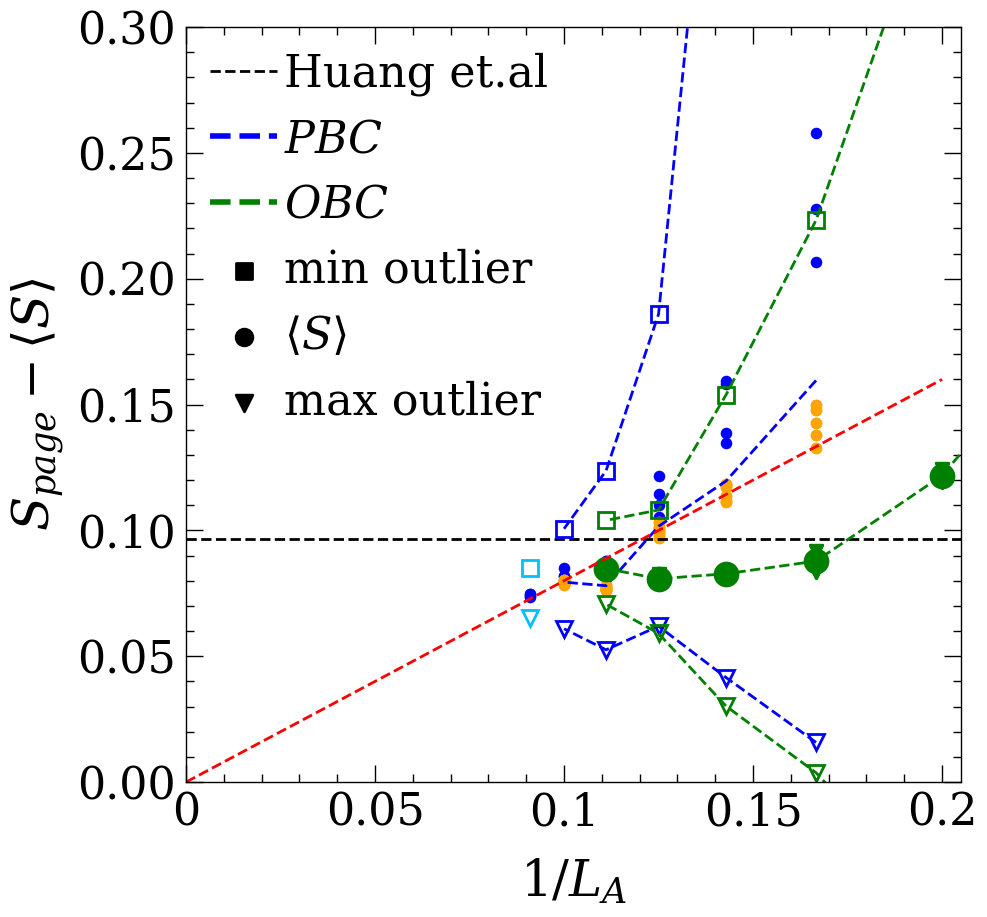

In [38]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
f = 0.5
S_tot = []

J2 = 2.0
hz = 0.2
S_re, S_im, S_max_re, S_max_im, S_min_re, S_min_im, dims_re, dims_im, _, _, _ = get_entropy_scaling(J2, hz, get_states=False, fraction=lambda dim: 100)
S_obc, S_max_obc, S_min_obc, dims_obc, _, _, _ = get_entropy_scaling_obc(J2, hz, get_states=False, fraction=lambda dim: 100)

use_raw_size = True
def rescaler(dim):
    return dim if use_raw_size else np.log2(dim)
print(sizes)
for i, L in enumerate(sizes):
    LA = f * L
    LB = (1-f)*L
    S_tot_tmp = 0
    dims = 0
    for jj, Sre in enumerate(S_re[i]): 
        axis.scatter(2. / L, page_result(LA, LB) - Sre, color='blue', s=10)
        S_tot_tmp += Sre * rescaler(dims_re[i][jj])
        dims += rescaler(dims_re[i][jj])

    for jj, Sim in enumerate(S_im[i]): 
        axis.scatter(2. / L, page_result(LA, LB) - Sim, color='orange', s=10)
        S_tot_tmp += Sim * rescaler(dims_im[i][jj])
        dims += rescaler(dims_im[i][jj])

    S_tot.append(S_tot_tmp / dims if dims > 0 else np.nan)
S_tot_obc = []
for i, L in enumerate(sizes_obc):
    LA = f * L
    LB = (1-f)*L
    S_tot_tmp = 0
    dims = 0
    print(S_obc[i])
    for jj, So in enumerate(S_obc[i]):
        axis.scatter(2. / L, page_result(LA, LB) - So, color='green', marker='v', s=20)
        S_tot_tmp += So * rescaler(dims_obc[i][jj])
        dims += rescaler(dims_obc[i][jj])
    S_tot_obc.append(S_tot_tmp / dims if dims > 0 else np.nan)
   
thermodynamic_value_pbc = page_result(f * 20, (1-f)*20) - (S_tot[-2] + np.maximum(S_max_re[-2], S_max_im[-2]) + + np.minimum(S_min_re[-2], S_min_im[-2])) / 3.
thermodynamic_value_obc = page_result(f * 16, (1-f)*16) - (S_tot_obc[-2] + S_max_obc[-2] +  S_min_obc[-2]) / 3.
print(thermodynamic_value_obc, thermodynamic_value_pbc)
#
#axis.arrow(x=0.005, y=thermodynamic_value_pbc, dx=-0.0025, dy=0, color='gray', head_length=0.002, head_width=0.005, lw=2)
#axis.arrow(x=0.005, y=thermodynamic_value_obc, dx=-0.0025, dy=0, color='green', head_length=0.002, head_width=0.005, lw=2)

axis.axhline(y = 0.096574, linestyle='--', color='black', label='Huang et.al')

# PBC
Ls = sizes[-1:]; axis.plot(2. / Ls,       page_result(f * Ls, (1-f)*Ls) - S_tot[-1:], ls='--', lw=0, color='DeepSkyBlue', marker='o', markersize=0, markeredgewidth=1.25)
Ls = sizes[:-1]; axis.plot(2. / Ls,       page_result(f * Ls, (1-f)*Ls) - S_tot[:-1], ls='--', lw=1, color='blue',        marker='o', markersize=0, markeredgewidth=1.25)

print("S_min_im = ", page_result(f * sizes, (1-f)*sizes) - S_min_im)
print("S_min_re = ", page_result(f * sizes, (1-f)*sizes) - S_min_re)
max_PBC = [S_max_re[iii] if np.isnan(S_max_im[iii]) else np.maximum(S_max_re[iii], S_max_im[iii]) for iii in range(len(S_max_im)) ]
min_PBC = [S_min_re[iii] if np.isnan(S_min_im[iii]) else np.minimum(S_min_re[iii], S_min_im[iii]) for iii in range(len(S_min_im)) ]
Ls = sizes[-1:]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - max_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='v', markersize=6)
Ls = sizes[-1:]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - min_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='s', markersize=6)
Ls = sizes[:-1]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - max_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='v', markersize=6)
Ls = sizes[:-1]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - min_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='s', markersize=6)

#OBC
axis.plot(2. / sizes_obc,   page_result(f * sizes_obc, (1-f)*sizes_obc) - S_tot_obc, ls='--', lw=1, color='green', marker='o', markersize=8, markeredgewidth=1.25)

axis.plot(2. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_max_obc,                      color='green', ls='--', markerfacecolor='None', marker='v', markersize=6)
axis.plot(2. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_min_obc,                      color='green', ls='--', markerfacecolor='None', marker='s', markersize=6)

#LEGEND
axis.plot(np.nan, np.nan, ls='--', lw=2, color='blue', label=r"$PBC$")
axis.plot(np.nan, np.nan, ls='--', lw=2, color='green', label=r"$OBC$")
axis.scatter(np.nan, np.nan, marker='s', color='black', label="min outlier")
axis.scatter(np.nan, np.nan, marker='o', color='black', label=r"$\langle S\rangle$")
axis.scatter(np.nan, np.nan, marker='v', color='black', label="max outlier")

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

y_min = 1.2 * (page_result(f * sizes_obc[0], (1-f)*sizes_obc[0]) - S_max_obc[0])
y_max = 1.2 * np.max(page_result(f * sizes[0], (1-f)*sizes[0]) - S_min_obc[0])
hfun.set_plot_elements(axis = axis, ylabel = "S_{page}-\\langle S\\rangle", xlabel = "1/L_A", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0, 0.205), ylim=(0.0, 0.3))

legend = axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))
#handles, labels = axis.get_legend_handles_labels()
#handles = np.array(handles)
#labels = np.array(labels)
#legend = axis.legend(handles[[0,1,2]], labels[[0,1,2]], fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))
#axis.legend(handles[[3,4,5]], labels[[3,4,5]], fontsize=16, loc='lower left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, -0.02))
#plt.gca().add_artist(legend)
xtic = axis.get_xticks()
tick_labels = ["%d"%tic if tic == 0 else "%g"%tic for tic in xtic]
axis.set_xticklabels(tick_labels)
eee = np.linspace(0, 0.2, 100)
axis.plot(eee, 0.8*eee, ls = '--', c='red')
#Ls = [30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10]
#Ls_with0 = [0] + Ls
#tick_labels = ["0" if Lx == 0 else (r"$\frac{1}{%d}$"%(Lx / 2) if Lx % 2 == 0 and Lx < 22 else "") for Lx in Ls_with0]
#axis.set_xticks([0] + list(2./np.array(Ls)))
#axis.set_xticklabels(tick_labels)
#axis.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(2./ ( np.array(Ls) - 1) ) )

axis.tick_params(axis='both', which='major', labelsize=16, length=6)
axis.tick_params(axis='both', which='minor', labelsize=16, length=3)

plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling.png", bbox_inches = 'tight', padding=0.02, transparent=False)

PBC	 [-3.42226275e-02 -5.83158170e-03  1.77001970e-03  1.66988858e-04
  1.12064357e-05 -3.18178881e-04]
OBC	 [-8.46659506e-03 -1.05442347e-02  5.10717404e-03  1.26584256e-03
 -6.84774973e-05]


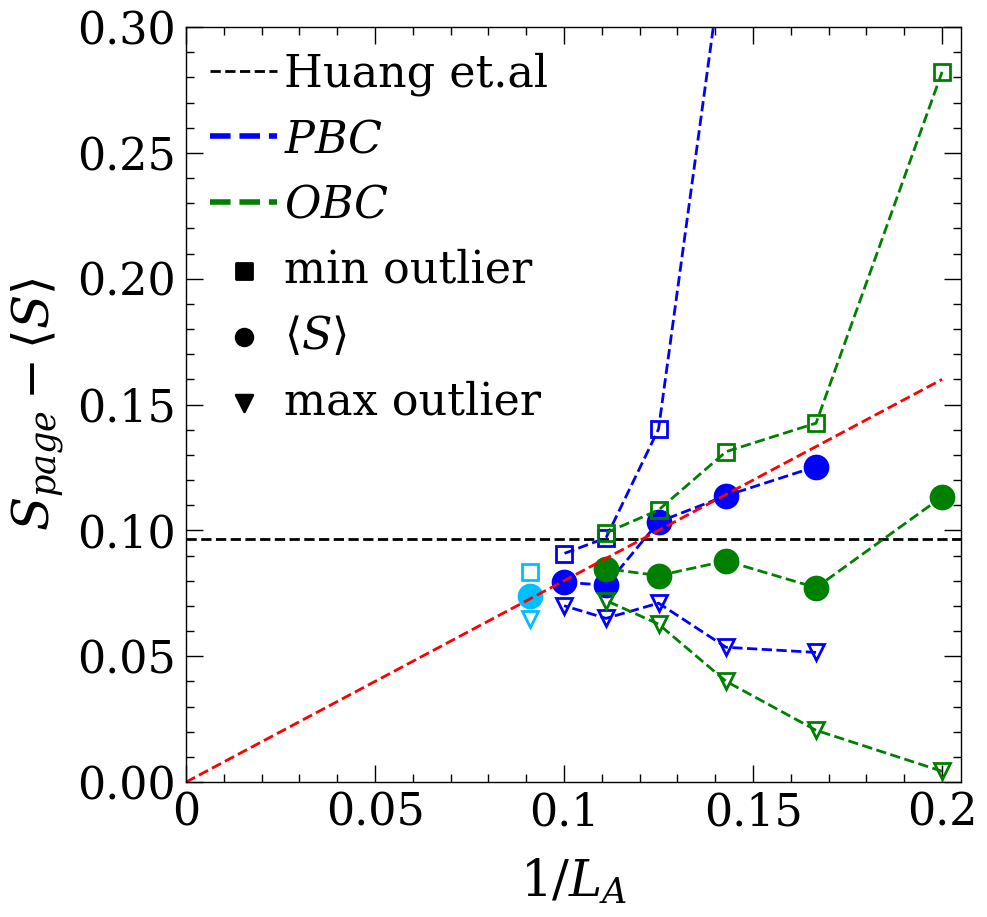

In [112]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
f = 0.5

J2 = 2.0
hz = 0.2
S_pbc, S_max_pbc, S_min_pbc, dims_re, dims_im, _, _, _ = get_entropy_scaling_combine_sectors(J2, hz, get_states=False, fraction=lambda dim: 100)
S_obc, S_max_obc, S_min_obc, dims_obc, _, _, _ = get_entropy_scaling_obc_combine_sectors(J2, hz, get_states=False, fraction=lambda dim: 100)

print("PBC\t", np.array(S_tot    ) - np.array(S_pbc))
print("OBC\t", np.array(S_tot_obc) - np.array(S_obc))
axis.axhline(y = 0.096574, linestyle='--', color='black', label='Huang et.al')

# PBC
Ls = sizes[-1:]; axis.plot(2. / Ls,       page_result(f * Ls, (1-f)*Ls) - S_pbc[-1:], ls='--', lw=0, color='DeepSkyBlue', marker='o', markersize=8, markeredgewidth=1.25)
Ls = sizes[:-1]; axis.plot(2. / Ls,       page_result(f * Ls, (1-f)*Ls) - S_pbc[:-1], ls='--', lw=1, color='blue',        marker='o', markersize=8, markeredgewidth=1.25)

Ls = sizes[-1:]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - S_max_pbc[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='v', markersize=6)
Ls = sizes[-1:]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - S_min_pbc[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='s', markersize=6)
Ls = sizes[:-1]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - S_max_pbc[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='v', markersize=6)
Ls = sizes[:-1]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - S_min_pbc[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='s', markersize=6)

#OBC
axis.plot(2. / sizes_obc,   page_result(f * sizes_obc, (1-f)*sizes_obc) - S_obc, ls='--', lw=1, color='green', marker='o', markersize=8, markeredgewidth=1.25)

axis.plot(2. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_max_obc,                      color='green', ls='--', markerfacecolor='None', marker='v', markersize=6)
axis.plot(2. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_min_obc,                      color='green', ls='--', markerfacecolor='None', marker='s', markersize=6)

#LEGEND
axis.plot(np.nan, np.nan, ls='--', lw=2, color='blue', label=r"$PBC$")
axis.plot(np.nan, np.nan, ls='--', lw=2, color='green', label=r"$OBC$")
axis.scatter(np.nan, np.nan, marker='s', color='black', label="min outlier")
axis.scatter(np.nan, np.nan, marker='o', color='black', label=r"$\langle S\rangle$")
axis.scatter(np.nan, np.nan, marker='v', color='black', label="max outlier")

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

y_min = 1.2 * (page_result(f * sizes_obc[0], (1-f)*sizes_obc[0]) - S_max_obc[0])
y_max = 1.2 * np.max(page_result(f * sizes[0], (1-f)*sizes[0]) - S_min_obc[0])
hfun.set_plot_elements(axis = axis, ylabel = "S_{page}-\\langle S\\rangle", xlabel = "1/L_A", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0, 0.205), ylim=(0.0, 0.3))

legend = axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))
xtic = axis.get_xticks()
tick_labels = ["%d"%tic if tic == 0 else "%g"%tic for tic in xtic]
axis.set_xticklabels(tick_labels)

eee = np.linspace(0, 0.2, 100)
axis.plot(eee, 0.8*eee, ls = '--', c='red')
axis.tick_params(axis='both', which='major', labelsize=16, length=6)
axis.tick_params(axis='both', which='minor', labelsize=16, length=3)

#plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
#plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling.png", bbox_inches = 'tight', padding=0.02, transparent=False)

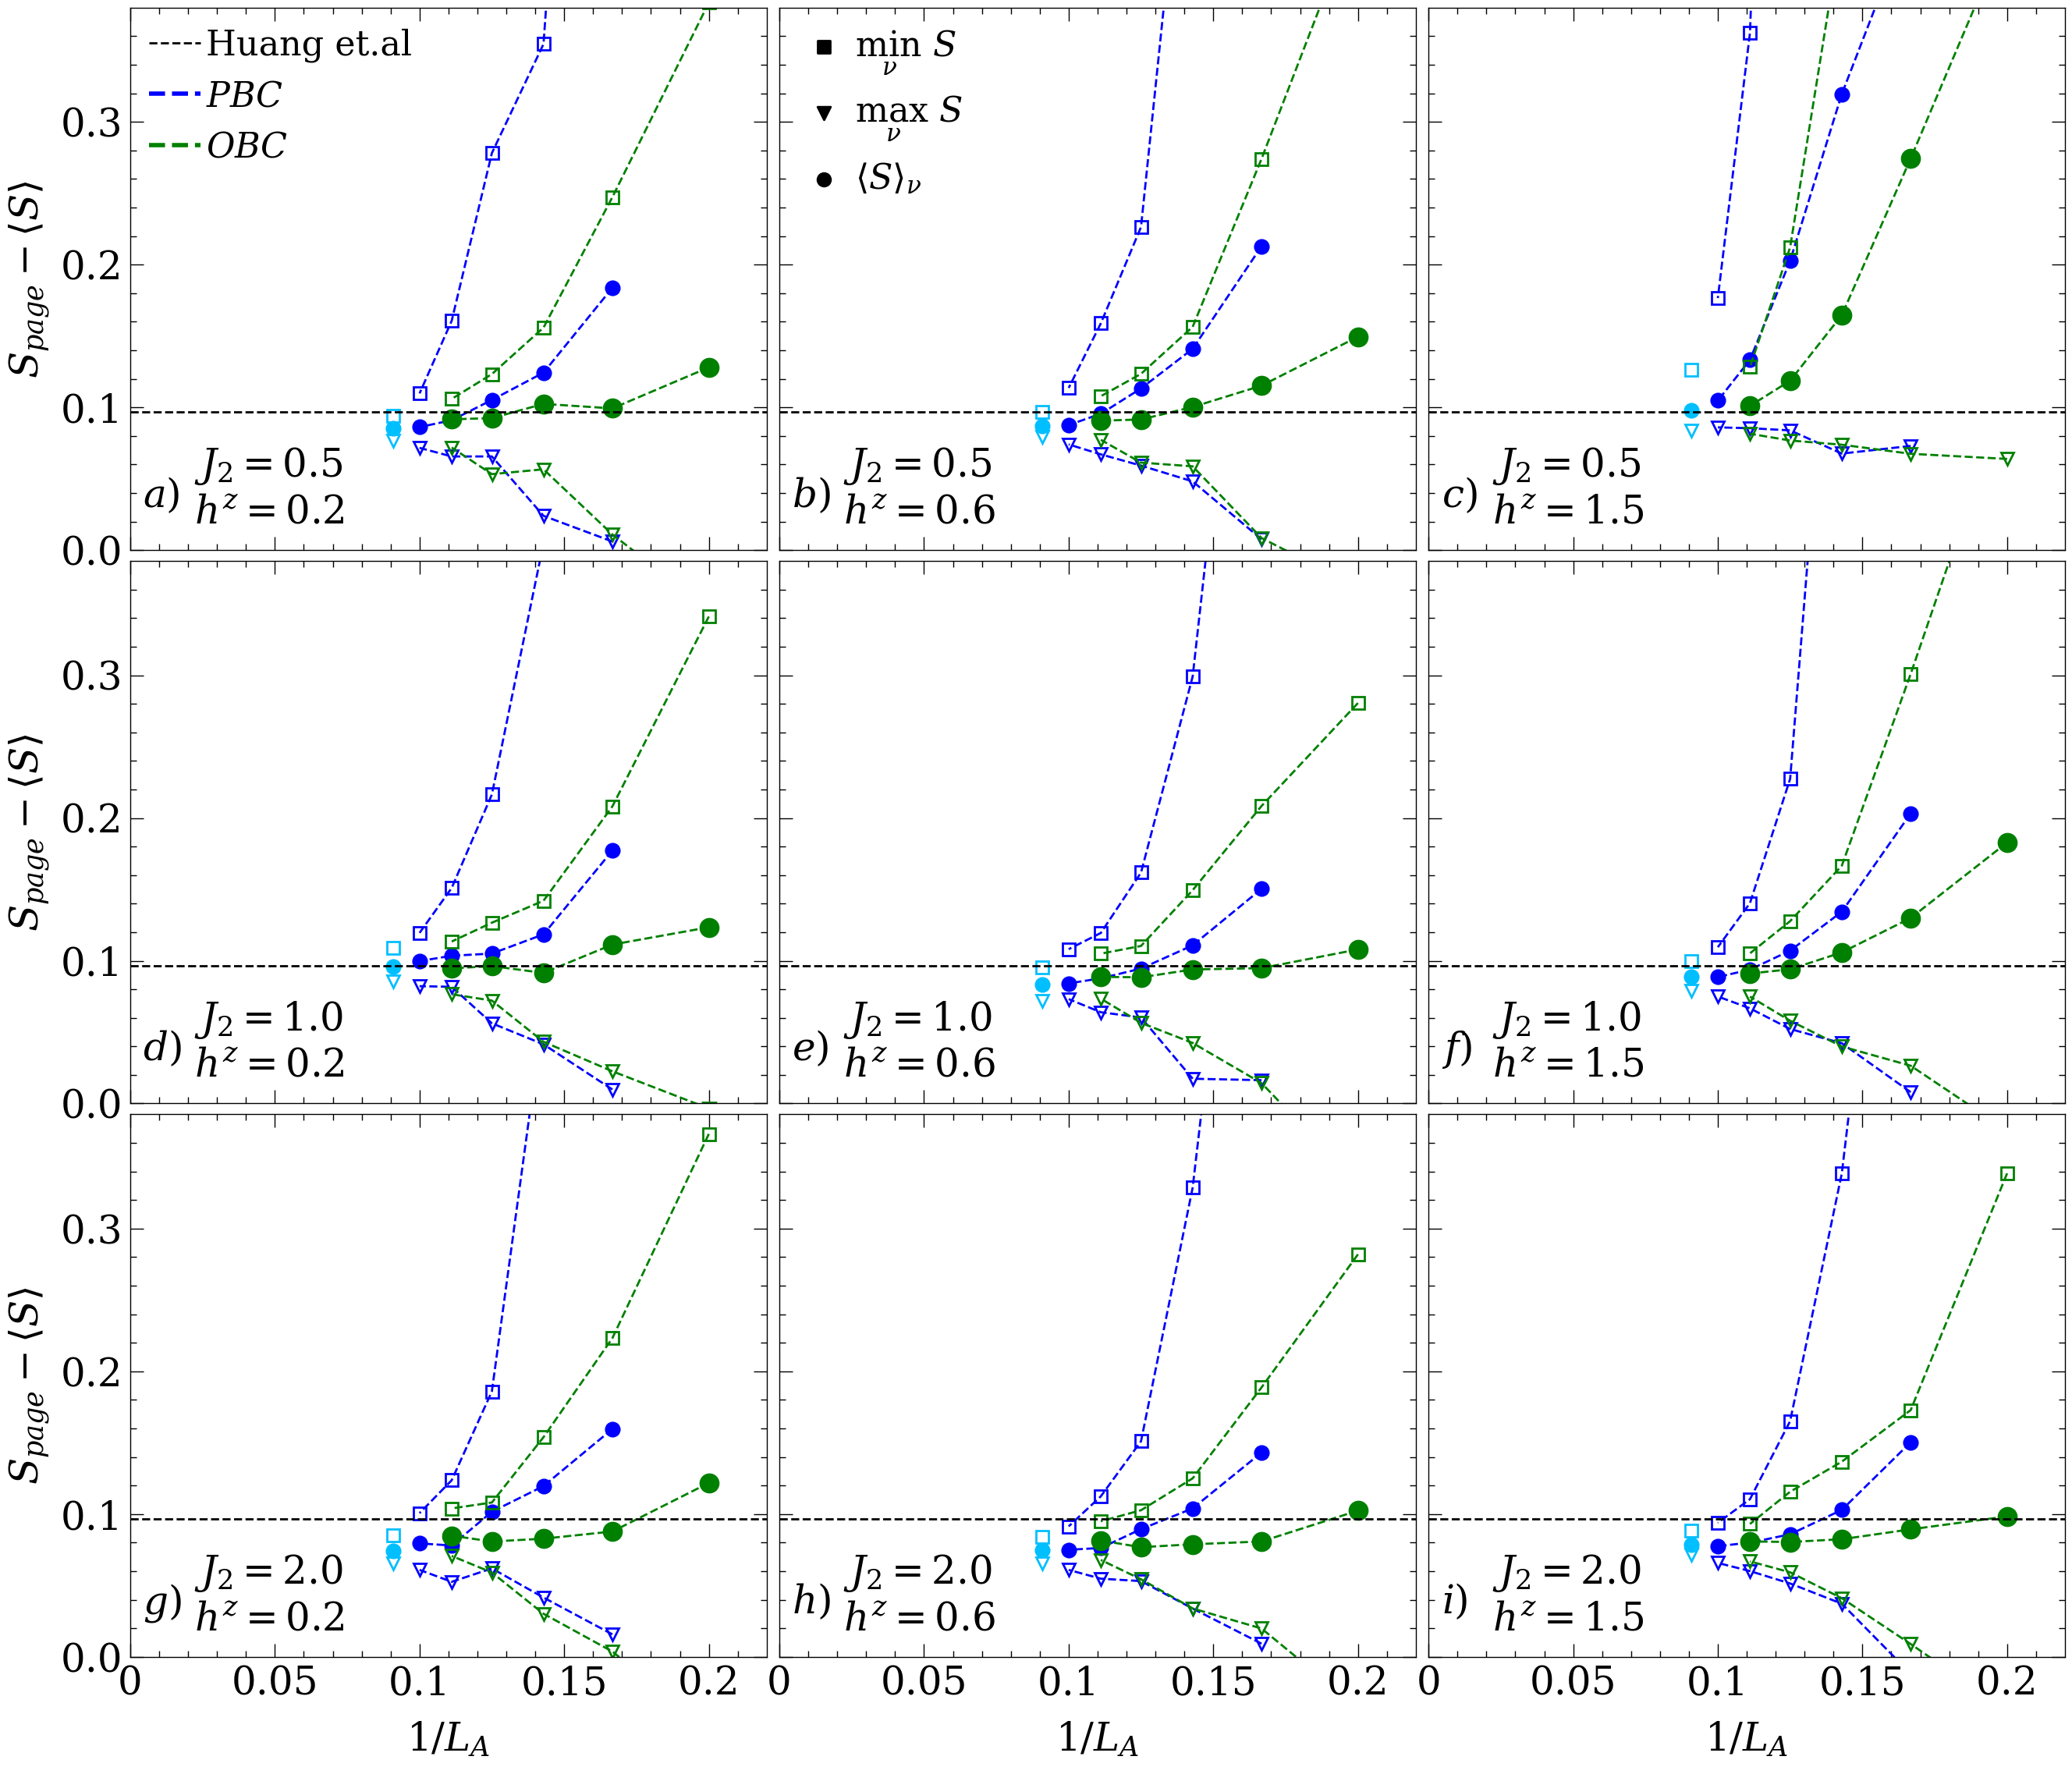

In [113]:
NCOLS=3
NROWS=3
space=0.02

num_of_subplots = NROWS * NCOLS
fig, axes = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(16 * (NCOLS / NROWS),14), dpi = 200, sharex=True, sharey=True)
axes = axes.flatten()
my_pars = [[J2, hz] for J2 in [0.5, 1.0, 2.0] for hz in [0.2, 0.6, 1.5] ]

labs = [r"$a)$", r"$b)$", r"$c)$", r"$d)$", r"$e)$", r"$f)$", r"$g)$", r"$h)$", r"$i)$", r"$j)$", r"$k)$", r"$l)$"]
for ii, [J2, hz] in enumerate(my_pars):
    axis = axes[ii]
    
    S_re, S_im, S_max_re, S_max_im, S_min_re, S_min_im, dims_re, dims_im, _, _, _ = get_entropy_scaling(J2, hz, get_states=False)
    S_obc, S_max_obc, S_min_obc, dims_obc, _, _, _ = get_entropy_scaling_obc(J2, hz, get_states=False)
    
    f = 0.5
    S_tot = []

    use_raw_size = True
    def rescaler(dim):
        return dim if use_raw_size else np.log2(dim)
    for i, L in enumerate(sizes):
        LA = f * L
        LB = (1-f)*L
        S_tot_tmp = 0
        dims = 0
        for jj, Sre in enumerate(S_re[i]): 
            #if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(LA, LB) - Sre, color='blue', s=20, label = r"$\Re$")
            #else:                   axis.scatter(1. / L, page_result(LA, LB) - Sre, color='blue', s=20)
            S_tot_tmp += Sre * rescaler(dims_re[i][jj])
            dims += rescaler(dims_re[i][jj])
        
        for jj, Sim in enumerate(S_im[i]): 
            #if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(LA, LB) - Sim, color='orange', s=20, label = r"$\Im$")
            #else:                   axis.scatter(1. / L, page_result(LA, LB) - Sim, color='orange', s=20)
            S_tot_tmp += Sim * rescaler(dims_im[i][jj])
            dims += rescaler(dims_im[i][jj])

        S_tot.append(S_tot_tmp / dims if dims > 0 else np.nan)
    
    S_tot_obc = []
    for i, L in enumerate(sizes_obc):
        LA = f * L
        LB = (1-f)*L
        S_tot_tmp = 0
        dims = 0
        #print(S_obc[i])
        for jj, So in enumerate(S_obc[i]):
            #if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(LA, LB) - So, color='green', marker='v', s=20, label = 'OBC')
            #else:                   axis.scatter(1. / L, page_result(LA, LB) - So, color='green', marker='v', s=20)
            S_tot_tmp += So * rescaler(dims_obc[i][jj])
            dims += rescaler(dims_obc[i][jj])
        S_tot_obc.append(S_tot_tmp / dims if dims > 0 else np.nan)
    
    #thermodynamic_value_pbc = page_result(f * 20, (1-f)*20) - (S_tot[-2] + np.maximum(S_max_re[-2], S_max_im[-2]) + + np.minimum(S_min_re[-2], S_min_im[-2])) / 3.
    #thermodynamic_value_obc = page_result(f * 16, (1-f)*16) - (S_tot_obc[-2] + S_max_obc[-2] +  S_min_obc[-2]) / 3.
    #print(thermodynamic_value_obc, thermodynamic_value_pbc)
    #
    #axis.arrow(x=0.005, y=thermodynamic_value_pbc, dx=-0.0025, dy=0, color='gray', head_length=0.002, head_width=0.005, lw=2)
    #axis.arrow(x=0.005, y=thermodynamic_value_obc, dx=-0.0025, dy=0, color='green', head_length=0.002, head_width=0.005, lw=2)

    # PBC
    Ls = sizes[-1:]; axis.plot(2. / Ls,       page_result(f * Ls, (1-f)*Ls) - S_tot[-1:], ls='--', lw=0, color='DeepSkyBlue', marker='o', markersize=6, markeredgewidth=1.25)
    Ls = sizes[:-1]; axis.plot(2. / Ls,       page_result(f * Ls, (1-f)*Ls) - S_tot[:-1], ls='--', lw=1, color='blue',        marker='o', markersize=6, markeredgewidth=1.25)
    
    max_PBC = [S_max_re[iii] if np.isnan(S_max_im[iii]) else np.maximum(S_max_re[iii], S_max_im[iii]) for iii in range(len(S_max_im)) ]
    min_PBC = [S_min_re[iii] if np.isnan(S_min_im[iii]) else np.minimum(S_min_re[iii], S_min_im[iii]) for iii in range(len(S_min_im)) ]
    Ls = sizes[-1:]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - max_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='v', markersize=6)
    Ls = sizes[-1:]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - min_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='s', markersize=6)
    Ls = sizes[:-1]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - max_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='v', markersize=6)
    Ls = sizes[:-1]; axis.plot(2. / Ls,     page_result(f * Ls,     (1-f)*Ls)     - min_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='s', markersize=6)
    
    #OBC
    axis.plot(2. / sizes_obc,   page_result(f * sizes_obc, (1-f)*sizes_obc) - S_tot_obc, ls='--', lw=1, color='green', marker='o', markersize=8, markeredgewidth=1.25)
    
    axis.plot(2. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_max_obc,                      color='green', ls='--', markerfacecolor='None', marker='v', markersize=6)
    axis.plot(2. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_min_obc,                      color='green', ls='--', markerfacecolor='None', marker='s', markersize=6)
    
    #LEGEND
    axis.axhline(y = 0.096574, linestyle='--', color='black')
    if ii == 0:
        axis.axhline(y = np.nan, linestyle='--', color='black', label='Huang et.al')
        axis.plot(np.nan, np.nan, ls='--', lw=2, color='blue', label=r"$PBC$")
        axis.plot(np.nan, np.nan, ls='--', lw=2, color='green', label=r"$OBC$")
    if ii ==1:
        axis.scatter(np.nan, np.nan, marker='s', color='black', label=r"$\min_\nu\ S$")
        axis.scatter(np.nan, np.nan, marker='v', color='black', label=r"$\max_\nu\ S$")
        axis.scatter(np.nan, np.nan, marker='o', color='black', label=r"$\langle S\rangle_\nu$")

    new_set_class = copy.deepcopy(cf.plot_settings)
    new_set_class.set_scales(xscale='linear', yscale='linear')
    settings = getattr(new_set_class, 'settings')

    ylab = "S_{page}-\\langle S\\rangle" if ii % NCOLS == 0 else "\ "
    xlab = "1/L_A" if ii >= NCOLS*(NROWS-1) else "\ "
    hfun.set_plot_elements(axis = axis, ylabel = ylab, xlabel = xlab, settings=settings, 
                            font_size=16, set_legend=False, xlim=(0, 0.22), ylim=(0.0, 0.38))

    if ii < 2:
        legend = axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))
        
    #Ls = [30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8]
    #Ls_with0 = [0] + Ls
    #tick_labels = ["0" if Lx == 0 else (r"$\frac{1}{%d}$"%(Lx / 2) if Lx % 2 == 0 and Lx < 22 else "") for Lx in Ls_with0]
    #axis.set_xticks([0] + list(2./np.array(Ls)))
    #axis.set_xticklabels(tick_labels)
    #axis.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(2./ ( np.array(Ls) - 1) ) )
    
    axis.annotate(labs[ii], xy=(0.02, 0.08), fontsize=18, xycoords='axes fraction')
    axis.annotate(r"$J_2=%.1f$"%J2 + "\n" + r"$h^z=%.1f$"%hz, xy=(0.1, 0.05), fontsize=18, xycoords='axes fraction')#, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
    axis.tick_params(axis='both', which='major', labelsize=18, length=6)
    axis.tick_params(axis='both', which='minor', labelsize=18, length=3)
    axis.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))
    axis.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))

fig.subplots_adjust(wspace=space, hspace=space)
#plt.tight_layout()
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_6panel.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_6panel.png", bbox_inches = 'tight', padding=0.02, transparent=False)

In [67]:
dir_drop = "/Users/rafal.swietek/Library/CloudStorage/Dropbox/EIGENSTATE ENTANGLEMENT MaksLevMarcos/Results4Plots"

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


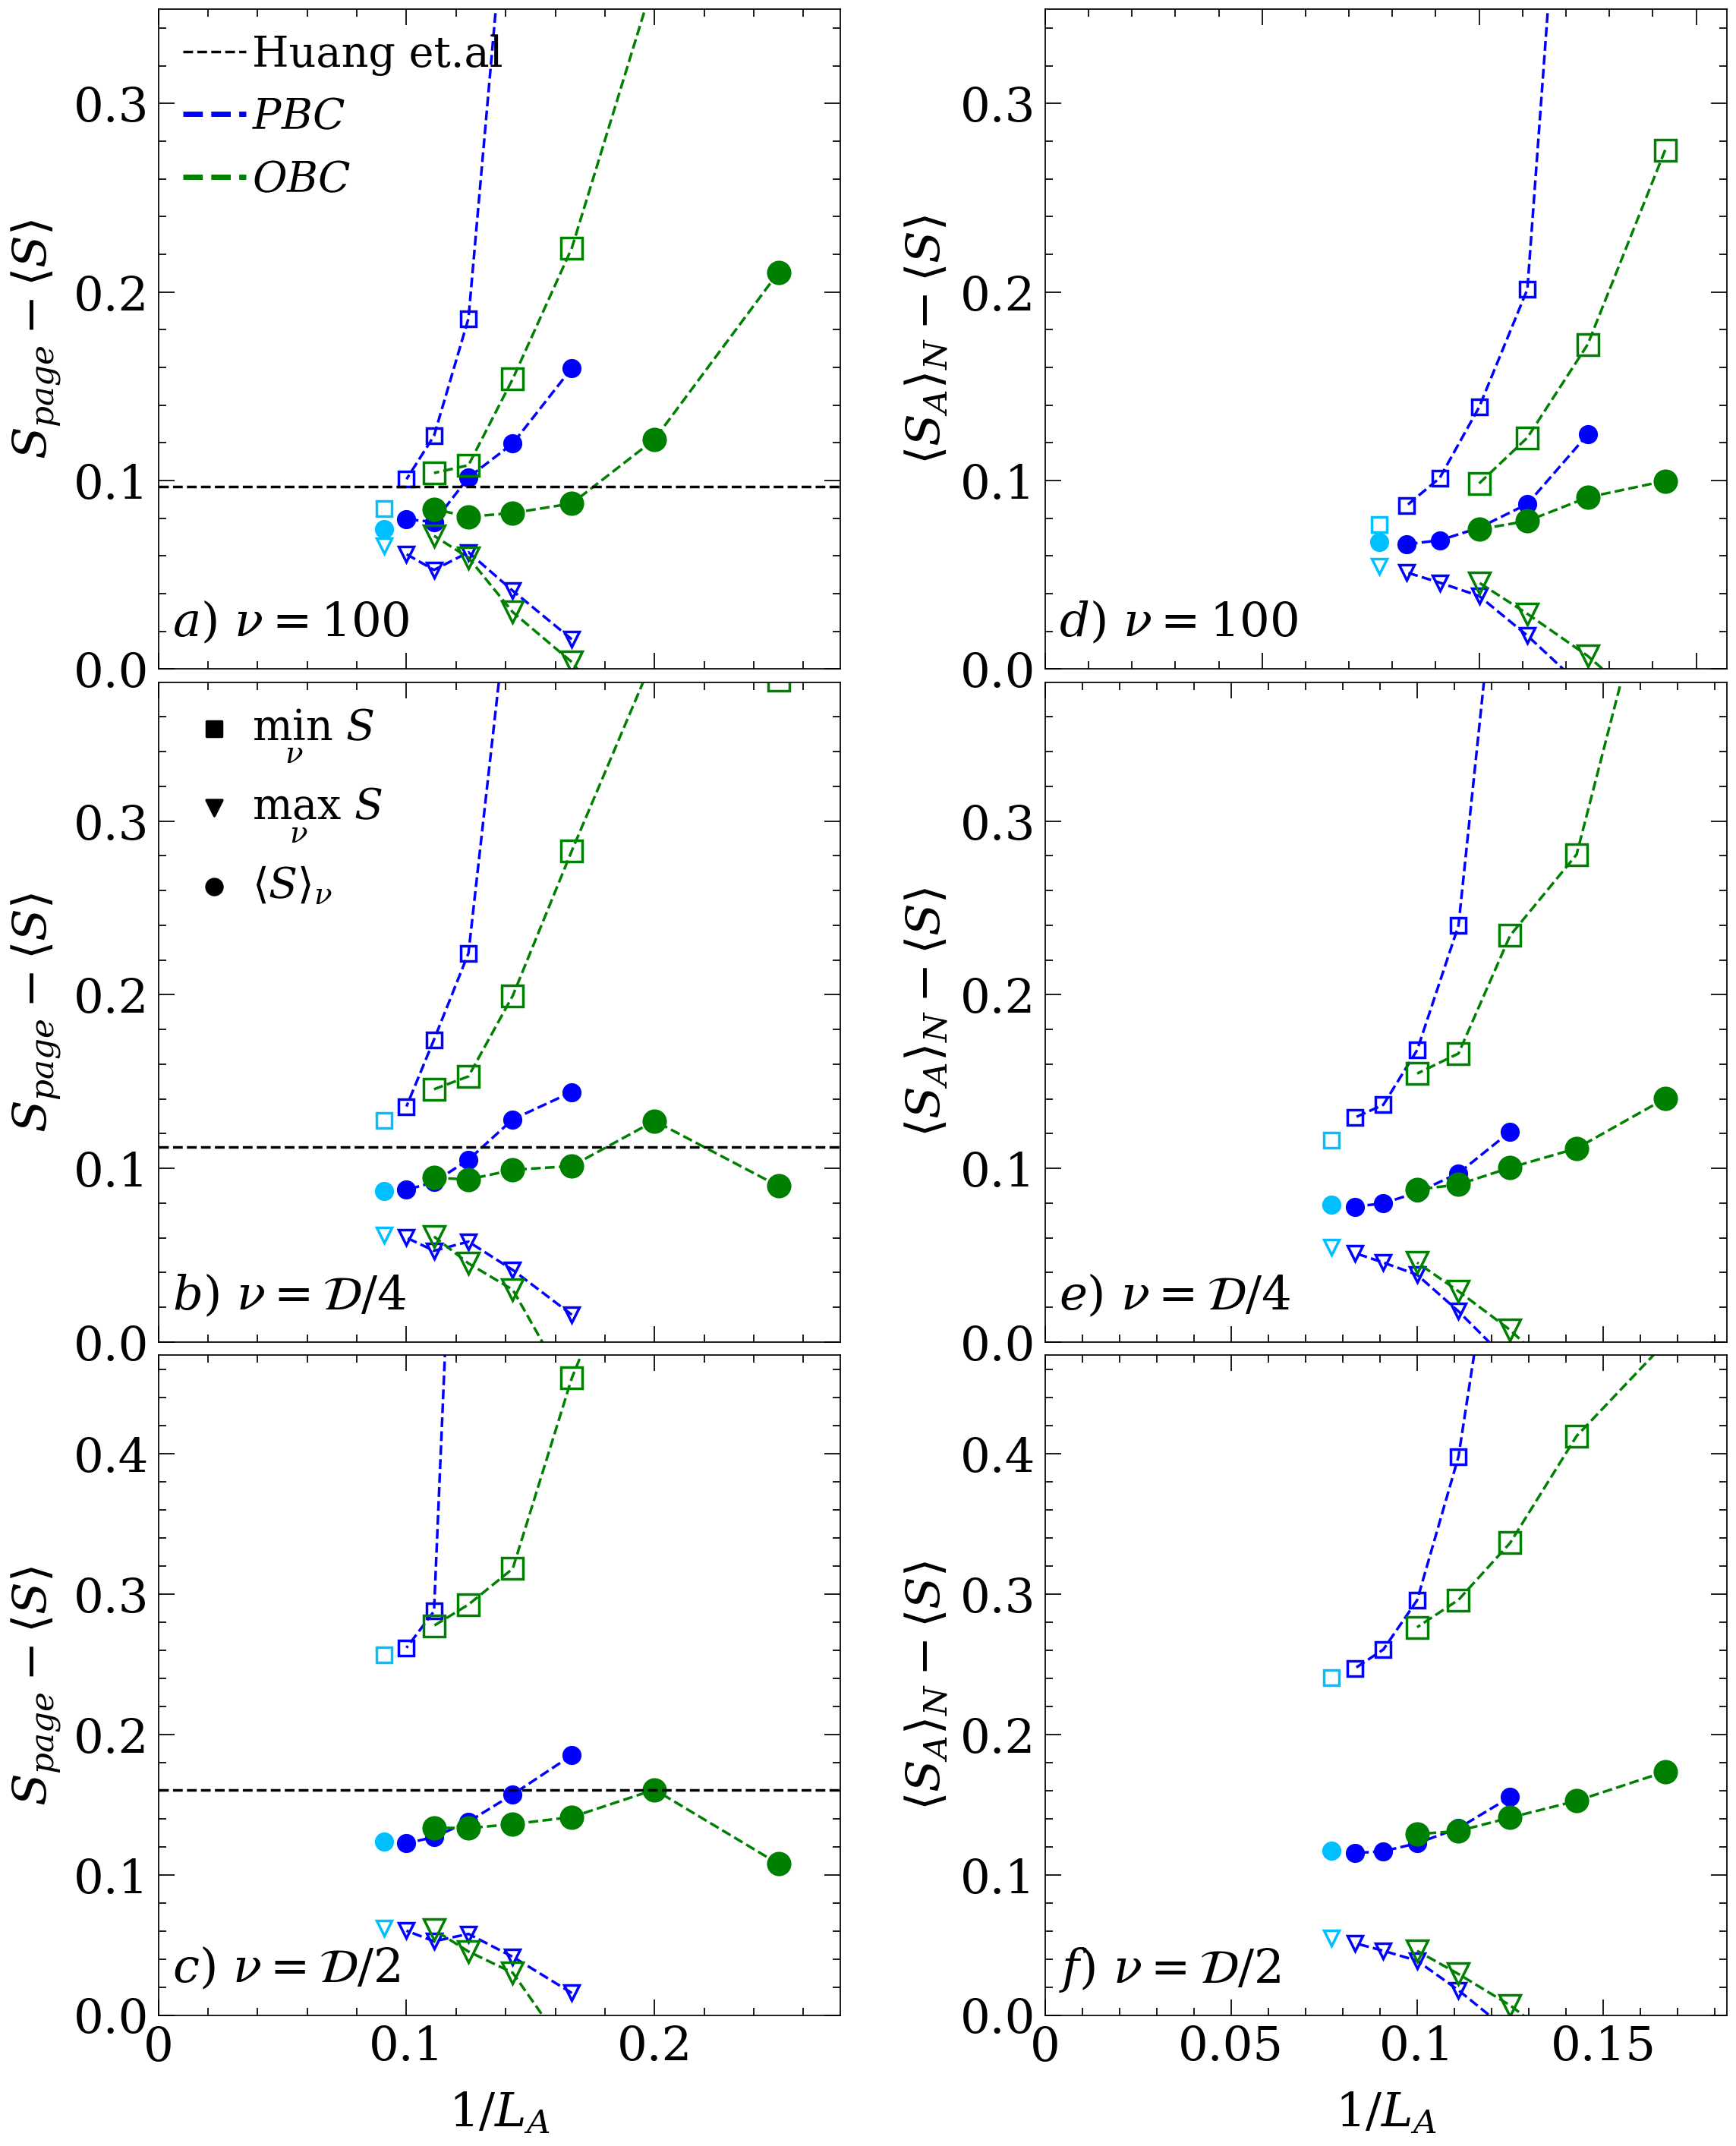

In [68]:
NCOLS=2
NROWS=3
space=0.02
J2 = 2.0
hz = 0.2
delta=0.2

num_of_subplots = NROWS * NCOLS
fig, axes = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(16 * (NCOLS / NROWS),14), dpi = 250)
axes = axes.flatten()

my_pars = [[J2, hz] for J2 in [0.5, 1.0, 2.0] for hz in [0.2, 0.6, 1.5] ]

frac_name = [r"$\nu=100$", r"$\nu=\mathcal{D}/4$", r"$\nu=\mathcal{D}/2$", r"$\nu=\mathcal{D}$"]
fractions_funcs = [lambda dim: 100, lambda dim: 0.25 * dim, lambda dim: 0.5 * dim]
frac_names = ['100', '0.25', '0.5']
huang = [0.096574, 0.112324, 0.160362, 0.483193]
y_min_list = [0.35, 0.35, 0.38, 0.38, 0.47, 0.47]

for ii, axis in enumerate(axes):
    frac = fractions_funcs[ii // NCOLS]
    Ls = sizes
    Ls_obc = sizes_obc
    if ii % NCOLS == 0:
        S_re, S_im, S_max_re, S_max_im, S_min_re, S_min_im, dims_re, dims_im, _, _, _ = get_entropy_scaling(J2, hz, get_states=False, fraction=frac)
        S_obc, S_max_obc, S_min_obc, dims_obc, _, _, _ = get_entropy_scaling_obc(J2, hz, get_states=False, fraction=frac)
        
        f = 0.5
        S_tot = []

        use_raw_size = True
        def rescaler(dim):
            return dim if use_raw_size else np.log2(dim)

        for i, L in enumerate(sizes):
            LA = f * L
            LB = (1-f)*L
            S_tot_tmp = 0
            dims = 0
            for jj, Sre in enumerate(S_re[i]): 
                S_tot_tmp += Sre * rescaler(dims_re[i][jj])
                dims += rescaler(dims_re[i][jj])

            for jj, Sim in enumerate(S_im[i]): 
                S_tot_tmp += Sim * rescaler(dims_im[i][jj])
                dims += rescaler(dims_im[i][jj])

            S_tot.append(S_tot_tmp / dims if dims > 0 else np.nan)
        S_tot_obc = []
        for i, L in enumerate(sizes_obc):
            LA = f * L
            LB = (1-f)*L
            S_tot_tmp = 0
            dims = 0
            for jj, So in enumerate(S_obc[i]):
                S_tot_tmp += So * rescaler(dims_obc[i][jj])
                dims += rescaler(dims_obc[i][jj])
            S_tot_obc.append(S_tot_tmp / dims if dims > 0 else np.nan)
        
        S_max_re = page_result(f * sizes, (1-f) * sizes) - S_max_re
        S_max_im = page_result(f * sizes, (1-f) * sizes) - S_max_im
        S_min_re = page_result(f * sizes, (1-f) * sizes) - S_min_re
        S_min_im = page_result(f * sizes, (1-f) * sizes) - S_min_im
        S_tot    = page_result(f * sizes, (1-f) * sizes) - S_tot

        S_tot_obc = page_result(f * sizes_obc, (1-f) * sizes_obc) - S_tot_obc
        S_max_obc = page_result(f * sizes_obc, (1-f) * sizes_obc) - S_max_obc
        S_min_obc = page_result(f * sizes_obc, (1-f) * sizes_obc) - S_min_obc
    else:
        f_n = frac_names[ii // 2]
        S_scaling = pd.read_csv(f'{dir_drop}/SU/size_scale_all_params/nu={f_n}/su_sizes_pbc_nu={f_n},J2={J2},d1={delta}.csv')
        
        
        Ls       = (S_scaling['Unnamed: 0']).to_numpy()
        S_tot    = (S_scaling['S_pred'] - S_scaling['S_tot']).to_numpy()
        S_max_re = (S_scaling['S_pred'] - S_scaling['S_max_re']).to_numpy()
        S_max_im = (S_scaling['S_pred'] - S_scaling['S_max_im']).to_numpy()
        S_min_re = (S_scaling['S_pred'] - S_scaling['S_min_re']).to_numpy()
        S_min_im = (S_scaling['S_pred'] - S_scaling['S_min_im']).to_numpy()
        
        S_scaling_obc = pd.read_csv(f'{dir_drop}/SU/size_scale_all_params/nu={f_n}/su_sizes_obc_nu={f_n},J2={J2},d1={delta}.csv')
        Ls_obc    = (S_scaling_obc['Unnamed: 0']).to_numpy()
        S_tot_obc = (S_scaling_obc['S_pred'] - S_scaling_obc['S_tot']).to_numpy()
        S_max_obc = (S_scaling_obc['S_pred'] - S_scaling_obc['S_max']).to_numpy()
        S_min_obc = (S_scaling_obc['S_pred'] - S_scaling_obc['S_min']).to_numpy()

    # PBC
    Lsx = Ls[-1:]; axis.plot(2. / Lsx, S_tot[-1:], ls='--', lw=0, color='DeepSkyBlue', marker='o', markersize=6, markeredgewidth=1.25)
    Lsx = Ls[:-1]; axis.plot(2. / Lsx, S_tot[:-1], ls='--', lw=1, color='blue',        marker='o', markersize=6, markeredgewidth=1.25)

    max_PBC = [S_max_re[iii] if np.isnan(S_max_im[iii]) else np.minimum(S_max_re[iii], S_max_im[iii]) for iii in range(len(S_max_im)) ]
    min_PBC = [S_min_re[iii] if np.isnan(S_min_im[iii]) else np.maximum(S_min_re[iii], S_min_im[iii]) for iii in range(len(S_min_im)) ]
    Lsx = Ls[-1:]; axis.plot(2. / Lsx, max_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='v', markersize=6)
    Lsx = Ls[-1:]; axis.plot(2. / Lsx, min_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='s', markersize=6)
    Lsx = Ls[:-1]; axis.plot(2. / Lsx, max_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='v', markersize=6)
    Lsx = Ls[:-1]; axis.plot(2. / Lsx, min_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='s', markersize=6)

    axis.plot(2. / Ls_obc, S_tot_obc, color='green', ls='--', lw=1, marker='o', markersize=8, markeredgewidth=1.25)    
    axis.plot(2. / Ls_obc, S_max_obc,  color='green', ls='--', markerfacecolor='None', marker='v', markersize=8)
    axis.plot(2. / Ls_obc, S_min_obc,  color='green', ls='--', markerfacecolor='None', marker='s', markersize=8)
    
    if ii % NCOLS == 0: axis.axhline(y = huang[ii // NCOLS], linestyle='--', color='black')
    if ii == 0:
        axis.axhline(np.nan, linestyle='--', color='black', label='Huang et.al')
        axis.plot(np.nan, np.nan, ls='--', lw=2, color='blue', label=r"$PBC$")
        axis.plot(np.nan, np.nan, ls='--', lw=2, color='green', label=r"$OBC$")
    if ii == 2:
        axis.scatter(np.nan, np.nan, marker='s', color='black', label=r"$\min_\nu\ S$")
        axis.scatter(np.nan, np.nan, marker='v', color='black', label=r"$\max_\nu\ S$")
        axis.scatter(np.nan, np.nan, marker='o', color='black', label=r"$\langle S\rangle_\nu$")

    new_set_class = copy.deepcopy(cf.plot_settings)
    new_set_class.set_scales(xscale='linear', yscale='linear')
    settings = getattr(new_set_class, 'settings')

    ylab = "S_{page}-\\langle S\\rangle" if ii % NCOLS == 0 else "\\langle S_{A}\\rangle_N-\\langle S\\rangle" 
    xlab = "1/L_A" if ii >= NCOLS*(NROWS-1) else "\ "
    hfun.set_plot_elements(axis = axis, ylabel = ylab, xlabel = xlab, settings=settings, 
                            font_size=16, set_legend=False, xlim=(0, 2.2 / Ls_obc[0]), ylim=(None, None))
    
    legend = axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))

    labs = ['a', 'd', 'b', 'e', 'c', 'f']
    axis.annotate(r"$%s)\ $"%labs[ii] + frac_name[ii // NCOLS], xy=(0.02, 0.05), fontsize=18, xycoords='axes fraction')
    axis.tick_params(axis='both', which='major', labelsize=18, length=6)
    axis.tick_params(axis='both', which='minor', labelsize=18, length=3)
    if ii >= NCOLS*(NROWS-1):   axis.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))
    else:                       axis.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    axis.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    for ax in axes[1::2]:
        #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
        ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
        #ax.annotate(r"$S_z=0$", xy=(0.02, 0.9), fontsize=18, xycoords='axes fraction')
        
    axes[ii].set_ylim(0, y_min_list[ii])

fig.subplots_adjust(wspace = 15 * space, hspace=space)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_fracs.pdf", bbox_inches = 'tight', transparent=False)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_fracs.png", bbox_inches = 'tight', transparent=False)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[16 18 20 22 24 26]
[16 18 20 22 24 26]
[16 18 20 22 24 26]


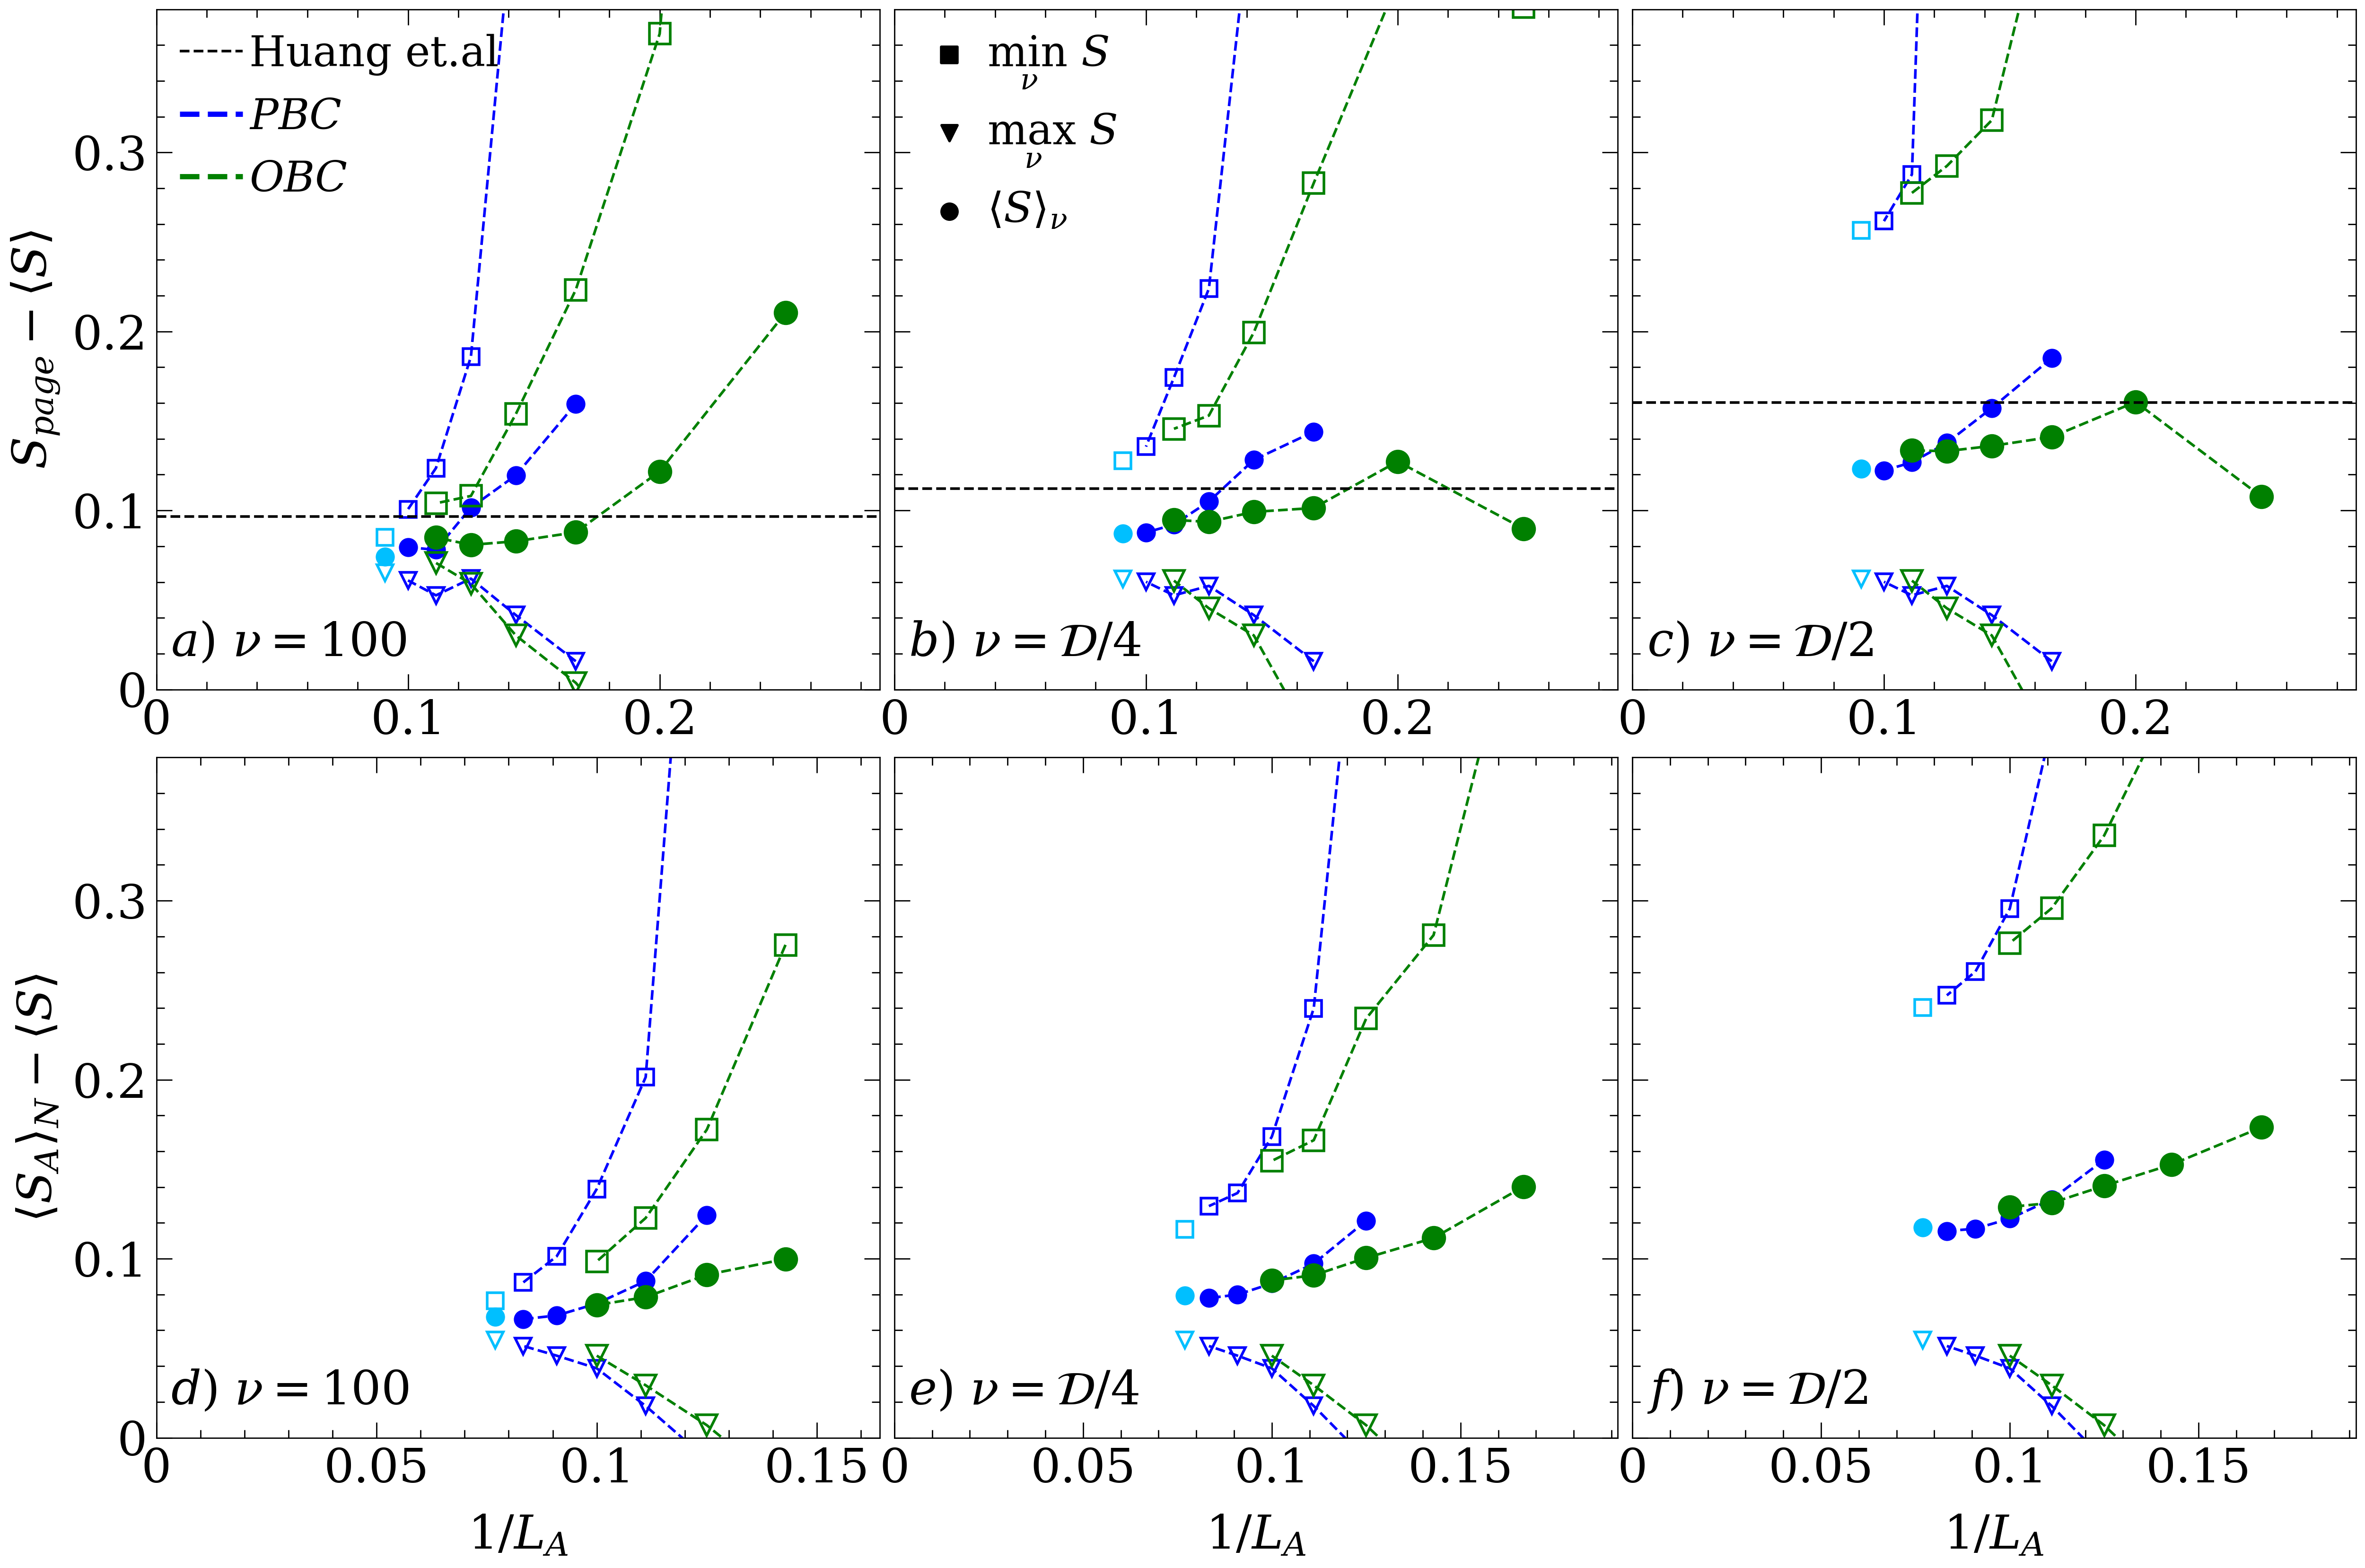

In [69]:
NCOLS=3
NROWS=2
space=0.02
J2 = 2.0
hz = 0.2
delta=0.2

num_of_subplots = NROWS * NCOLS
fig, axes = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(10 * (NCOLS / NROWS),10), dpi = 400)
axes = axes.flatten()

my_pars = [[J2, hz] for J2 in [0.5, 1.0, 2.0] for hz in [0.2, 0.6, 1.5] ]

frac_name = [r"$\nu=100$", r"$\nu=\mathcal{D}/4$", r"$\nu=\mathcal{D}/2$", r"$\nu=\mathcal{D}$"]
fractions_funcs = [lambda dim: 100, lambda dim: 0.25 * dim, lambda dim: 0.5 * dim]
frac_names = ['100', '0.25', '0.5']
huang = [0.096574, 0.112324, 0.160362, 0.483193]
y_min_list = [0.35, 0.35, 0.38, 0.38, 0.47, 0.47]

for ii, axis in enumerate(axes):
    frac = fractions_funcs[ii % NCOLS]
    Ls = sizes
    Ls_obc = sizes_obc
    S_tot = []; S_max_re=[]; S_max_im=[]; S_min_re=[]; S_min_im=[];
    S_tot_obc=[]; S_max_obc=[]; S_min_obc=[];
    if ii < NCOLS:
        S_re, S_im, S_max_re, S_max_im, S_min_re, S_min_im, dims_re, dims_im, _, _, _ = get_entropy_scaling(J2, hz, get_states=False, fraction=frac)
        S_obc, S_max_obc, S_min_obc, dims_obc, _, _, _ = get_entropy_scaling_obc(J2, hz, get_states=False, fraction=frac)
        
        f = 0.5

        use_raw_size = True
        def rescaler(dim):
            return dim if use_raw_size else np.log2(dim)

        for i, L in enumerate(sizes):
            LA = f * L
            LB = (1-f)*L
            S_tot_tmp = 0
            dims = 0
            for jj, Sre in enumerate(S_re[i]): 
                S_tot_tmp += Sre * rescaler(dims_re[i][jj])
                dims += rescaler(dims_re[i][jj])

            for jj, Sim in enumerate(S_im[i]): 
                S_tot_tmp += Sim * rescaler(dims_im[i][jj])
                dims += rescaler(dims_im[i][jj])

            S_tot.append(S_tot_tmp / dims if dims > 0 else np.nan)
        
        for i, L in enumerate(sizes_obc):
            LA = f * L
            LB = (1-f)*L
            S_tot_tmp = 0
            dims = 0
            for jj, So in enumerate(S_obc[i]):
                S_tot_tmp += So * rescaler(dims_obc[i][jj])
                dims += rescaler(dims_obc[i][jj])
            S_tot_obc.append(S_tot_tmp / dims if dims > 0 else np.nan)
        
        S_max_re = page_result(f * sizes, (1-f) * sizes) - S_max_re
        S_max_im = page_result(f * sizes, (1-f) * sizes) - S_max_im
        S_min_re = page_result(f * sizes, (1-f) * sizes) - S_min_re
        S_min_im = page_result(f * sizes, (1-f) * sizes) - S_min_im
        S_tot    = page_result(f * sizes, (1-f) * sizes) - S_tot

        S_tot_obc = page_result(f * sizes_obc, (1-f) * sizes_obc) - S_tot_obc
        S_max_obc = page_result(f * sizes_obc, (1-f) * sizes_obc) - S_max_obc
        S_min_obc = page_result(f * sizes_obc, (1-f) * sizes_obc) - S_min_obc
    else:
        f_n = frac_names[ii % NCOLS]
        S_scaling = pd.read_csv(f'{dir_drop}/SU/size_scale_all_params/nu={f_n}/su_sizes_pbc_nu={f_n},J2={J2},d1={delta}.csv')
        
        Ls       = (S_scaling['Unnamed: 0']).to_numpy()
        print(Ls)
        S_tot    = (S_scaling['S_pred'] - S_scaling['S_tot']).to_numpy()
        S_max_re = (S_scaling['S_pred'] - S_scaling['S_max_re']).to_numpy()
        S_max_im = (S_scaling['S_pred'] - S_scaling['S_max_im']).to_numpy()
        S_min_re = (S_scaling['S_pred'] - S_scaling['S_min_re']).to_numpy()
        S_min_im = (S_scaling['S_pred'] - S_scaling['S_min_im']).to_numpy()
        
        S_scaling_obc = pd.read_csv(f'{dir_drop}/SU/size_scale_all_params/nu={f_n}/su_sizes_obc_nu={f_n},J2={J2},d1={delta}.csv')
        Ls_obc    = (S_scaling_obc['Unnamed: 0']).to_numpy()
        S_tot_obc = (S_scaling_obc['S_pred'] - S_scaling_obc['S_tot']).to_numpy()
        S_max_obc = (S_scaling_obc['S_pred'] - S_scaling_obc['S_max']).to_numpy()
        S_min_obc = (S_scaling_obc['S_pred'] - S_scaling_obc['S_min']).to_numpy()

    # PBC
    Lsx = Ls[-1:]; axis.plot(2. / Lsx, S_tot[-1:], ls='--', lw=0, color='DeepSkyBlue', marker='o', markersize=6, markeredgewidth=1.25)
    Lsx = Ls[:-1]; axis.plot(2. / Lsx, S_tot[:-1], ls='--', lw=1, color='blue',        marker='o', markersize=6, markeredgewidth=1.25)

    max_PBC = [S_max_re[iii] if np.isnan(S_max_im[iii]) else np.minimum(S_max_re[iii], S_max_im[iii]) for iii in range(len(S_max_im)) ]
    min_PBC = [S_min_re[iii] if np.isnan(S_min_im[iii]) else np.maximum(S_min_re[iii], S_min_im[iii]) for iii in range(len(S_min_im)) ]
    Lsx = Ls[-1:]; axis.plot(2. / Lsx, max_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='v', markersize=6)
    Lsx = Ls[-1:]; axis.plot(2. / Lsx, min_PBC[-1:], color='DeepSkyBlue',  lw=0, ls='--', markerfacecolor='None', marker='s', markersize=6)
    Lsx = Ls[:-1]; axis.plot(2. / Lsx, max_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='v', markersize=6)
    Lsx = Ls[:-1]; axis.plot(2. / Lsx, min_PBC[:-1], color='blue',         lw=1, ls='--', markerfacecolor='None', marker='s', markersize=6)

    axis.plot(2. / Ls_obc, S_tot_obc, color='green', ls='--', lw=1, marker='o', markersize=8, markeredgewidth=1.25)    
    axis.plot(2. / Ls_obc, S_max_obc,  color='green', ls='--', markerfacecolor='None', marker='v', markersize=8)
    axis.plot(2. / Ls_obc, S_min_obc,  color='green', ls='--', markerfacecolor='None', marker='s', markersize=8)
    
    if ii < NCOLS: axis.axhline(y = huang[ii % NCOLS], linestyle='--', color='black')
    if ii == 0:
        axis.axhline(np.nan, linestyle='--', color='black', label='Huang et.al')
        axis.plot(np.nan, np.nan, ls='--', lw=2, color='blue', label=r"$PBC$")
        axis.plot(np.nan, np.nan, ls='--', lw=2, color='green', label=r"$OBC$")
    if ii == 1:
        axis.scatter(np.nan, np.nan, marker='s', color='black', label=r"$\min_\nu\ S$")
        axis.scatter(np.nan, np.nan, marker='v', color='black', label=r"$\max_\nu\ S$")
        axis.scatter(np.nan, np.nan, marker='o', color='black', label=r"$\langle S\rangle_\nu$")

    new_set_class = copy.deepcopy(cf.plot_settings)
    new_set_class.set_scales(xscale='linear', yscale='linear')
    settings = getattr(new_set_class, 'settings')

    ylab = "S_{page}-\\langle S\\rangle" if ii == 0 else ("\\langle S_{A}\\rangle_N-\\langle S\\rangle" if ii == NCOLS else "\ ")
    xlab = "1/L_A" if ii >= NCOLS*(NROWS-1) else "\ "
    hfun.set_plot_elements(axis = axis, ylabel = ylab, xlabel = xlab, settings=settings, 
                            font_size=16, set_legend=False, xlim=(0, 2.3 / Ls_obc[0]), ylim=(None, None))
    #axis.set_xlim(0.0, 0.201)

    legend = axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))

    labs = ['a', 'b', 'c', 'd', 'e', 'f']
    axis.annotate(r"$%s)\ $"%labs[ii] + frac_name[ii % NCOLS], xy=(0.02, 0.05), fontsize=18, xycoords='axes fraction')
    axis.tick_params(axis='both', which='major', labelsize=18, length=6)
    axis.tick_params(axis='both', which='minor', labelsize=18, length=3)
    #if ii >= NCOLS*(NROWS-1):   
    axis.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))
    #else:                       axis.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    axis.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    if ii % NCOLS > 0:  axis.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    else:               axis.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))
    axis.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
        #ax.annotate(r"$S_z=0$", xy=(0.02, 0.9), fontsize=18, xycoords='axes fraction')
        
    axes[ii].set_ylim(0, 0.38)

fig.subplots_adjust(wspace = space, hspace=0.1)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_fracs_T.pdf", bbox_inches = 'tight', transparent=False)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_fracs_T.png", bbox_inches = 'tight', transparent=False)

## LOADER WITH STATES

In [36]:
S_re_list = []
S_im_list = []
S_max_re_list = []
S_max_im_list = []
dims_re_list = []
dims_im_list = []
edges = []
histograms = []
gaussianity = []

print(J_points)
print(hz_points)
pars = []
for J2 in J_points:
    for hz in hz_points:
        pars.append([J2, hz])
        S_re_tmp, S_im_tmp, S_max_re_tmp, S_max_im_tmp, S_min_re_tmp, S_min_im_tmp, dims_re_tmp, dims_im_tmp, edge, hist, gauss = get_entropy_scaling(J2, hz, get_states=True)
        S_re_list.append(S_re_tmp)
        S_im_list.append(S_im_tmp)
        S_max_re_list.append(S_max_re_tmp)
        S_max_im_list.append(S_max_im_tmp)
        dims_re_list.append(dims_re_tmp)
        dims_im_list.append(dims_im_tmp)
        edges.append(edge)
        histograms.append(hist)
        gaussianity.append(gauss)   

[0.5, 1.0, 2.0]
[0.2, 0.6, 0.8, 1.5]


In [17]:
S_obc_list = []
S_max_obc_list = []
dims_obc_list = []
edges_onc = []
hist_obc = []
gauss_obc = []

pars = []
for J2 in J_points:
    for hz in hz_points:
        pars.append([J2, hz])
        S_obc, S_max_obc, S_min_obc, dims_obc, edge_obc, his_obc, gaga_obc = get_entropy_scaling_obc(J2, hz, get_states=True)
        S_obc_list.append(S_obc)
        S_max_obc_list.append(S_max_obc)
        dims_obc_list.append(dims_obc)
        edges_onc.append(edge_obc)
        hist_obc.append(his_obc)
        gauss_obc.append(gaga_obc)  

## PLOTTER WITH STATES

Let's start
J2=0.5, hz=1.5
J2=1.0, hz=0.8
J2=1.0, hz=1.5
J2=2.0, hz=0.2
J2=2.0, hz=0.6


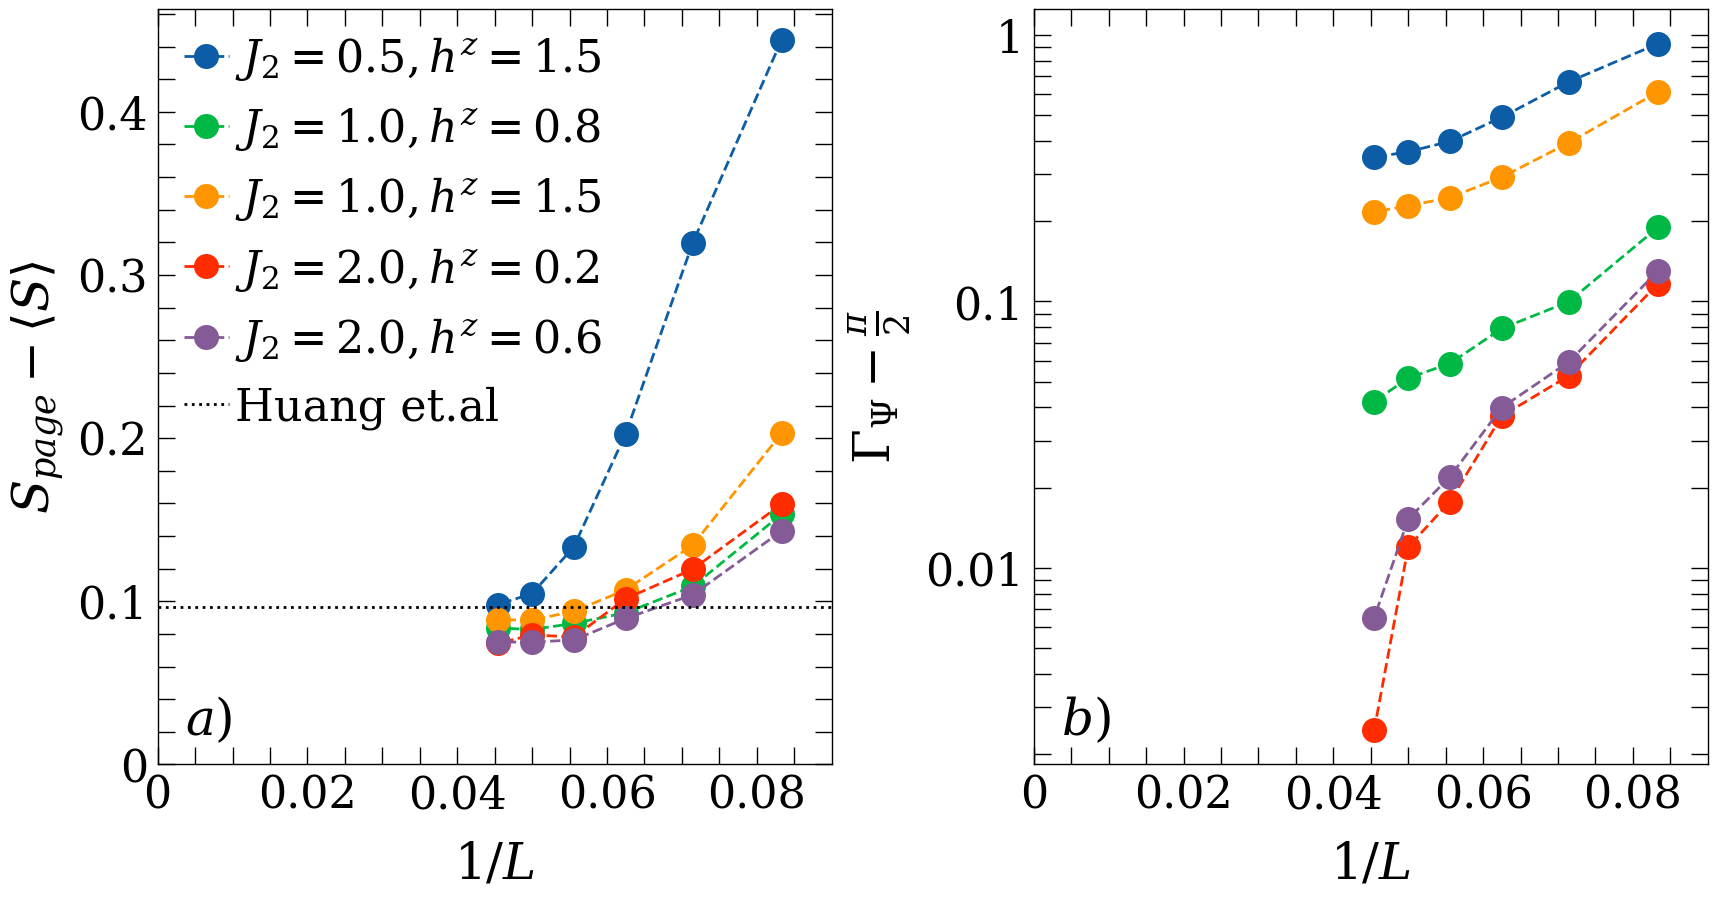

In [37]:
print("Let's start")
fig = plt.figure(figsize=(10,5), dpi = 200)

gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])
axes = [None, None]
axes[0] = fig.add_subplot(gs[0])
axes[1] = fig.add_subplot(gs[1])

plot_abs = False

width = 0.4
height = 0.4
axis = axes[0]
colors = ['blue', 'black', 'green', 'red']
def lablab(val):
    return r"$J_2=%.1f$"%val if use_J_change else r"$h^z=%.1f$"%val
f=0.5
#for ii, xx in enumerate(x_points):
my_pars = [[0.5, hz] for hz in hz_points]
my_pars = [[J2, hz] for J2 in [0.5, 2.0] for hz in hz_points]
my_pars = [[0.5, 1.5], [1.0, 0.8], [1.0, 1.5], [2.0, 0.2], [2.0, 0.6]]
for [J2, hz] in my_pars:
    ii = pars.index([J2, hz])
    print(f'J2={J2}, hz={hz}')
    S_real = S_re_list[ii]
    S_imag = S_im_list[ii]
    S_max_real = S_max_re_list[ii]
    S_max_imag = S_max_im_list[ii]
    dims_real =  dims_re_list[ii]
    dims_imag =  dims_im_list[ii]
    edge = edges[ii]
    hist = histograms[ii]
    S_total = []
    for i, L in enumerate(sizes):
        S_tot_tmp = 0
        dims = 0
        for jj, Sre in enumerate(S_real[i]): 
            S_tot_tmp += Sre * dims_real[i][jj]
            dims += dims_real[i][jj]

        for jj, Sim in enumerate(S_imag[i]): 
            S_tot_tmp += Sim * dims_imag[i][jj]
            dims += dims_imag[i][jj]
        
        S_total.append(S_tot_tmp / dims if dims > 0 else np.nan)

    p = axis.plot(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_total, marker='o', ls='--', markersize=8, label=r"$J_2=%.1f,h^z=%.1f$"%(J2, hz))

    axes[1].plot(1/np.array(sizes), np.array(gaussianity[ii]) - np.pi / 2, color=p[0].get_color(), marker='o', ls='--', markersize=8)
    
        
axis.axhline(y = 0.096574, linestyle=':', color='black', label='Huang et.al')

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

hfun.set_plot_elements(axis = axis, ylabel = "S_{page}-\\langle S\\rangle", xlabel = "1/L", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0, 0.09), ylim=(0.0, None))
#axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)
axis.set_ylim(0.0, None)
legend = axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1., bbox_to_anchor=(-0.02, 1.02))





val = np.pi / 2
valname = r"$\pi/2$"

#axes[1].axhline(y=val, ls='--', color='black')

hfun.set_plot_elements(axis = axes[1], ylabel = "\\Gamma_\\Psi-\\frac{\\pi}{2}", xlabel = "1 / L", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0.0, 0.09), ylim=(0.0, None))
#ax_inset.legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)

axes[1].set_xscale('linear')
axes[1].set_yscale('log')
axes[1].set_ylim(0, None)
for ajx in axes:
    for ax in [ajx.xaxis, ajx.yaxis]:
        ax.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))


axes[0].annotate(r"$a)$", xy=(0.04, 0.04), fontsize=18, xycoords='axes fraction')
axes[1].annotate(r"$b)$", xy=(0.04, 0.04), fontsize=18, xycoords='axes fraction')
fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_gaussPBC.pdf", bbox_inches = 'tight', padding=0.02, transparent=True)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_gaussPBC.png", bbox_inches = 'tight', padding=0.02, transparent=True)

Let's start
[[1.2711041569416093, 1.580306020438641, 1.574939469140585, 1.575429829050829, 1.5753235416428975, 1.5742858548566494], [1.371169149179712, 1.6505000790679365, 1.6187957184033872, 1.612333385426722, 1.609360683564469, 1.6077486242031216], [1.4541445843053609, 1.7316889828259647, 1.677865582179131, 1.6632577468677334, 1.6556041592122237, nan], [2.0698292441862343, 2.5270654276282194, 2.2034222822936513, 2.027664739355814, 1.967459549658325, 1.9502424336176627], [1.2896262153736295, 1.5862280554987063, 1.5764766429291455, 1.5755693875100423, 1.5760363873443004, 1.5744746795256523], [1.338290184789758, 1.6278500154686728, 1.2933047405599043, 1.5973473494391692, 1.5938297278919709, 1.5928155302525782], [1.396854200346529, 1.6836466893891697, 1.636459352013601, 1.6256350317963795, 1.6222687717040558, nan], [1.768682361258706, 2.1375593085205518, 1.9304623936446739, 1.8554381342963255, 1.8219029929285542, nan], [1.2820205786166337, 1.5821320892701938, 1.5770503755987464, 1.575235

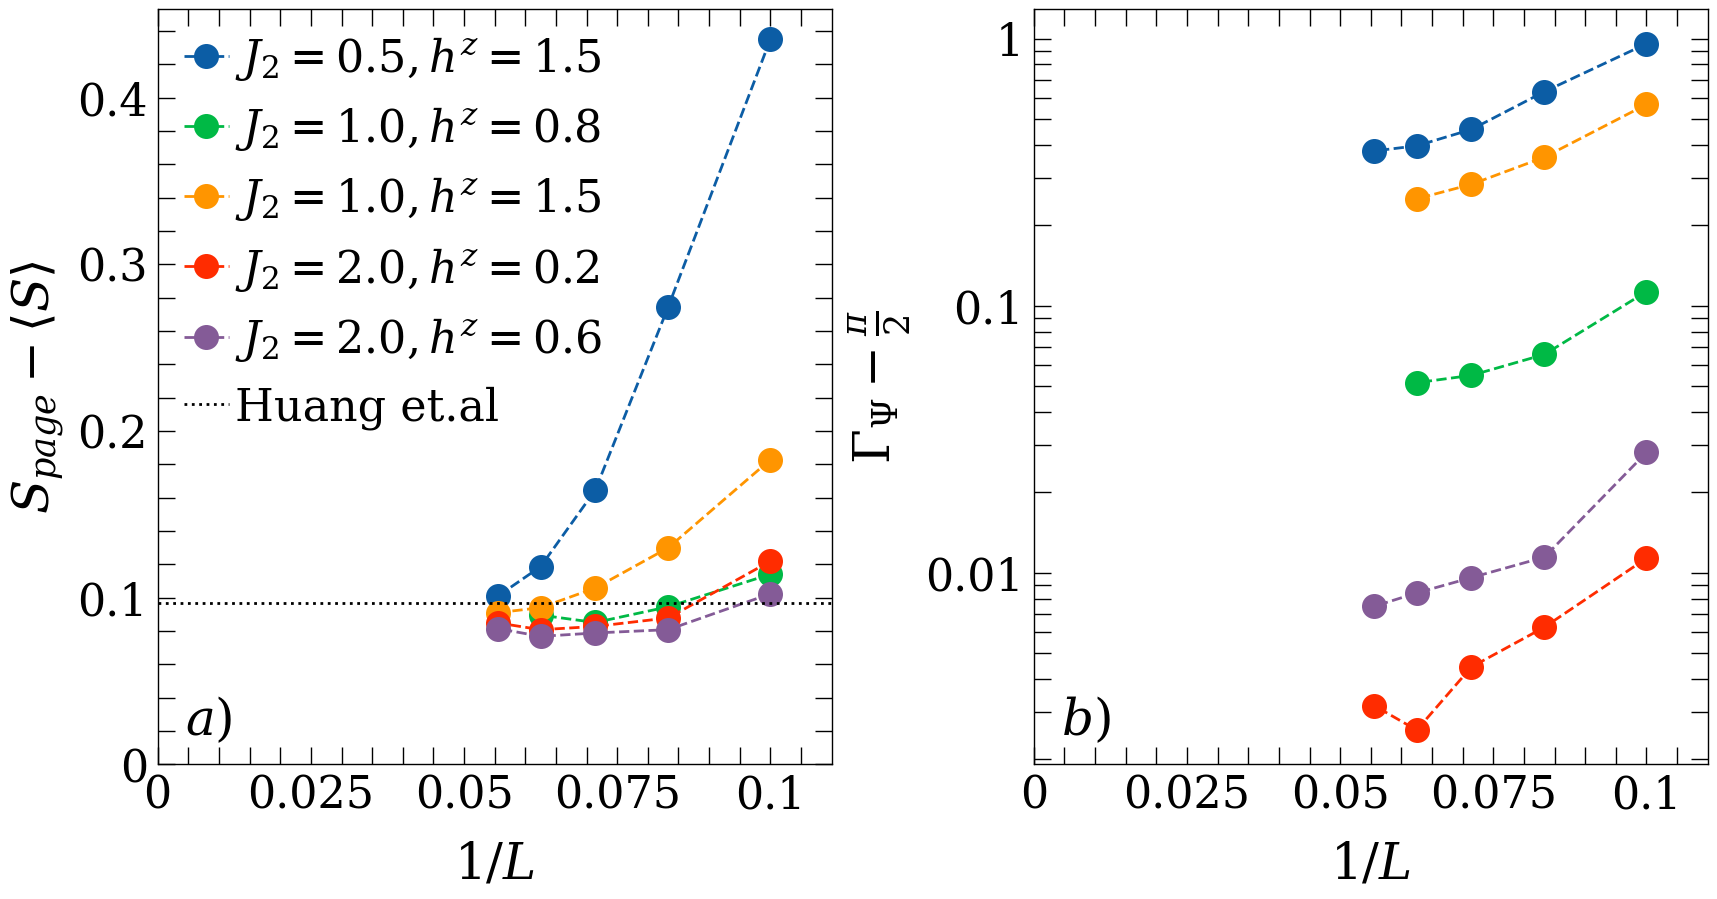

In [33]:
print("Let's start")
fig = plt.figure(figsize=(10,5), dpi = 200)

gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])
axes = [None, None]
axes[0] = fig.add_subplot(gs[0])
axes[1] = fig.add_subplot(gs[1])

plot_abs = False
print(gauss_obc)

width = 0.4
height = 0.4
axis = axes[0]
colors = ['blue', 'black', 'green', 'red']
def lablab(val):
    return r"$J_2=%.1f$"%val if use_J_change else r"$h^z=%.1f$"%val
f=0.5
#for ii, xx in enumerate(x_points):
my_pars = [[0.5, hz] for hz in hz_points]
my_pars = [[J2, hz] for J2 in [0.5, 2.0] for hz in hz_points]
my_pars = [[0.5, 1.5], [1.0, 0.8], [1.0, 1.5], [2.0, 0.2], [2.0, 0.6]]
#S_obc_list
#S_max_obc_list
#dims_obc_list
#edges_onc
#hist_obc
#gauss_obc
for [J2, hz] in my_pars:
    ii = pars.index([J2, hz])
    print(f'J2={J2}, hz={hz}')
    S_obc = S_obc_list[ii]
    S_max = S_max_obc_list[ii]
    dims =  dims_obc_list[ii]
    edge = edges_onc[ii]
    hist = hist_obc[ii]
    S_total = []
    for i, L in enumerate(sizes_obc[1:]):
        S_tot_tmp = 0
        dims_sum = 0
        for jj, S in enumerate(S_obc[i+1]): 
            S_tot_tmp += S * dims[i][jj]
            dims_sum += dims[i][jj]

        S_total.append(S_tot_tmp / dims_sum if dims_sum > 0 else np.nan)

    p = axis.plot(1. / sizes_obc[1:], page_result(f * sizes_obc[1:], (1-f)*sizes_obc[1:]) - S_total, marker='o', ls='--', markersize=8, label=r"$J_2=%.1f,h^z=%.1f$"%(J2, hz))

    axes[1].plot(1/np.array(sizes_obc[1:]), np.array(gauss_obc[ii][1:]) - np.pi / 2, color=p[0].get_color(), marker='o', ls='--', markersize=8)
    
        
axis.axhline(y = 0.096574, linestyle=':', color='black', label='Huang et.al')

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

hfun.set_plot_elements(axis = axis, ylabel = "S_{page}-\\langle S\\rangle", xlabel = "1/L", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0, 0.11), ylim=(0.0, None))
#axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)
axis.set_ylim(0.0, None)
legend = axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1., bbox_to_anchor=(-0.02, 1.02))



val = np.pi / 2
valname = r"$\pi/2$"

#axes[1].axhline(y=val, ls='--', color='black')

hfun.set_plot_elements(axis = axes[1], ylabel = "\\Gamma_\\Psi-\\frac{\\pi}{2}", xlabel = "1 / L", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0.0, 0.11), ylim=(0.0, None))
#ax_inset.legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)

axes[1].set_xscale('linear')
axes[1].set_yscale('log')
axes[1].set_ylim(0, None)
for ajx in axes:
    for ax in [ajx.xaxis, ajx.yaxis]:
        ax.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x if x > 0 else "0"))


axes[0].annotate(r"$a)$", xy=(0.04, 0.04), fontsize=18, xycoords='axes fraction')
axes[1].annotate(r"$b)$", xy=(0.04, 0.04), fontsize=18, xycoords='axes fraction')
fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_gaussOBC.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_scaling_gaussOBC.png", bbox_inches = 'tight', padding=0.02, transparent=False)

# RMT

In [44]:
import tenpy.linalg.random_matrix as rmt
import random
def rotate_left(state, L):
    maxPower = 2**(L - 1)
    return (state - maxPower) * 2 + 1 if state >= maxPower else state * 2;

def generate_cpx_goe(system_size, use_real = False):
    dim = 2**system_size
    A = np.array(rmt.GOE( (dim, dim) ))
    E, V = np.linalg.eigh(A)
    return E, V

#---------------------------------------------
def get_midspectrum_states_TEST(num_realis, L = 10, use_real = False):
    states = []
    r = 0
    for i in range(num_realis):
        A = np.array(rmt.GOE( (dim, dim) ))
        E, V = np.linalg.eigh(A)
        #E, V = generate_cpx_goe(system_size=L, use_real=use_real)
        #print(E)
        dim = E.size
        E_av = np.mean(E)
        idx = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
        gaps = np.diff(E)
        r_tmp = 0
        counter = 0
        mu = int(0.5 * (dim // 2))
        for i in range(int(idx - mu), int(idx + mu)):
            r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
            counter += 1

        r += r_tmp / counter
        #print(idx, E_av, "r= ", r_tmp / counter)
        Vv = V[idx - 100 : idx + 100]
        states += list(Vv.flatten())
    
    return np.array(states), r / num_realis
Eere, Vfsdf = generate_cpx_goe(system_size=10, use_real=False)

def get_midspectrum_states(num_realis, dim):
    states = []
    r = 0
    entro = 0
    for i in range(num_realis):
        A = np.array(rmt.GOE( (dim, dim) ))
        E, V = np.linalg.eigh(A)

        dim = E.size
        E_av = np.mean(E)
        idx = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
        gaps = np.diff(E)
        r_tmp = 0
        counter = 0
        mu = int(0.5 * (dim // 2))
        for i in range(int(idx - mu), int(idx + mu)):
            r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
            counter += 1

        r += r_tmp / counter
        print(idx, E_av, "r= ", r_tmp / counter)
        Vv = (V[idx - 100 : idx + 100])
        states += list(Vv.flatten())
        
        for state in Vv:
            red_mat = state.reshape(( int(np.sqrt(dim)) , int(np.sqrt(dim)) ))

            _, s, _ = np.linalg.svd(red_mat, full_matrices=False)
            entro += -np.sum(s**2 * np.log(s**2))

    
    return np.array(states), r / num_realis, entro / (200 * num_realis)

In [ ]:
states_re, r_re = get_midspectrum_states_TEST(num_realis=50, L=12, use_real=True)
print(f'REAL:\taverage gap ratio:\t{r_re}')
states_cpx, r_cpx = get_midspectrum_states_TEST(num_realis=50, L=12, use_real=False)
print(f'CPX:\taverage gap ratio:\t{r_cpx}')

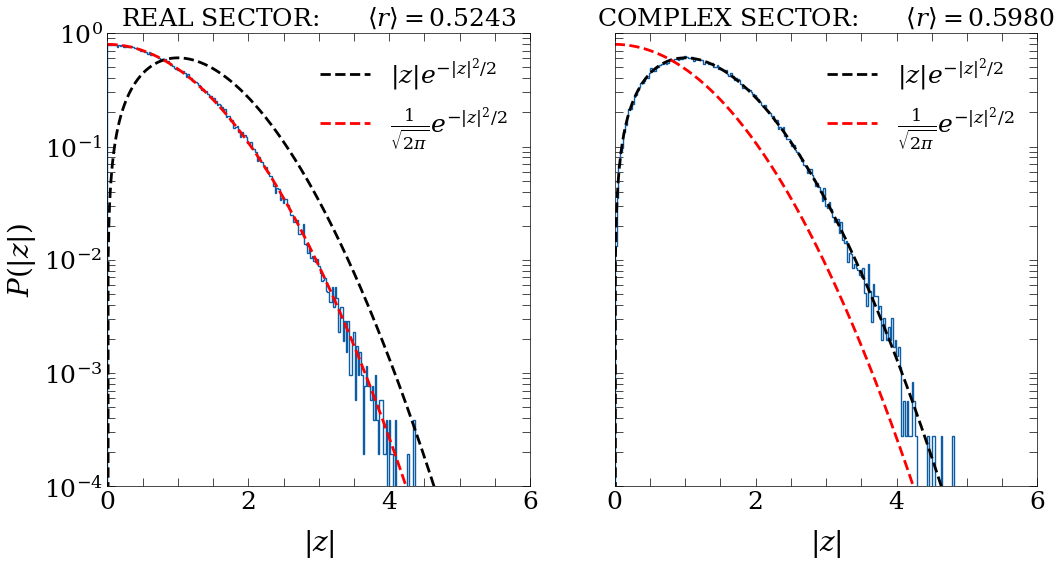

In [61]:

fig, axes = plt.subplots(ncols=2, nrows=1, dpi=100, figsize=(12,6), sharey=True)

rescale_vec = lambda x : (x - np.mean(x))/np.sqrt(np.var(x))

for i, ax in enumerate(axes):
    if i == 1:
        ax.set_title(r"COMPLEX SECTOR:$\qquad\langle r\rangle=%.4f$"%r_cpx, fontsize=18)
        coeff = np.sqrt(rescale_vec(states_cpx.real)**2 + rescale_vec(states_cpx.imag)**2)
    else:
        ax.set_title(r"REAL SECTOR:$\qquad\langle r\rangle=%.4f$"%r_re, fontsize=18)
        coeff = np.abs(rescale_vec(states_re))
    hista, bins = np.histogram(coeff, bins=200, normed=True)


    def sum_of_squares_normals_sqrt(bins):
        return bins * np.exp(-np.square(bins)/2.0)

    def gauss(bins):
        return 2/np.sqrt(2*np.pi) * np.exp(-bins**2 / 2)

    ax.stairs(hista, bins)
    adada = np.linspace(0, 10, 1010)

    ax.plot(adada, sum_of_squares_normals_sqrt(adada),  lw=2, ls='--', c='black', label=r"$|z|e^{-|z|^2/2}$")
    ax.plot(adada, gauss(adada),                        lw=2, ls='--', c='red', label=r"$\frac{1}{\sqrt{2\pi}}e^{-|z|^2/2}$")
    
    ax.set_xlim(0, 6)
    ax.set_ylim(1e-4, 1)
    hfun.set_plot_elements(axis = ax, ylabel = "P(|z|)" if i == 0 else "\ ", xlabel = "|z|", settings=user_settings, 
                            font_size=18, set_legend=True, xlim=(None, None), ylim=(None, None))
    ax.set_yscale('log')
    ax.set_xscale('linear')



In [47]:

J2 = 2.0
hz = 0.6

S_obc, _, _, dims_obc, edge, hist, gauss_obc = get_entropy_scaling_obc(J2, hz, get_states=True, with_small_size=True)
print(dims_obc, gauss_obc)

[array([120, 136, 120, 136]), array([496, 528, 496, 528]), array([2016, 2080, 2016, 2080]), array([8128, 8256, 8128, 8256]), array([32640, 32896, 32640, 32896]), array([130816, 131328, 130816, 131328])] [1.3081581523324495, 1.5990159215472377, 1.5822354853274767, 1.5803866052718256, 1.579199459750502, 1.5782846324714372]


In [ ]:

figas, ax_dist = plt.subplots(ncols=1, nrows=1, figsize=(6,6), dpi = 200)
def gaus(x):
    return 2. / np.sqrt(2*np.pi) * np.exp( - (x)**2 / (2))
    
rescale_vec = lambda x : (x - np.mean(x))/np.sqrt(np.var(x))

num_realis = 100

f=0.5

print(dims_obc)
dims = [min(dim) for dim in dims_obc]
print(dims)
gauss_rand_state = []
gauss_rmt = []

entropy_rand_state = []
entropy_rmt = []

siz_rmt = []
siz_rand = []
for jj, dim in enumerate(dims):
    if dim > 0:
        print(dim)
        p = ax_dist.scatter(edge[jj][:-1], hist[jj], label=r"$L=%d$"%sizes_obc[jj], s=20)
        if dim > 5e3: num_realis = 20
        if dim < 12000:
            states, r, entro = get_midspectrum_states(num_realis, 2**( int(np.log2(dim)) ))

            coeff = np.abs(rescale_vec(states))
            hos, binaes = np.histogram(coeff, bins=60, normed=True)

            ax_dist.stairs(hos, binaes, ls='--')#, c=p[0].get_color())

            siz_rmt.append(sizes_obc[jj])
            gauss_rmt.append(np.mean(np.square(coeff)) / np.mean(coeff)**2)
            entropy_rmt.append(entro)
        
        mu=0.0
        sigma=1.0
        rand_vec = []
        dimaa = 2**( int(np.log2(dim)) )
        gen = np.random.Generator( np.random.MT19937() )
        states = [np.array(gen.normal(mu, sigma, dimaa))]

        entro_rand = 0
        dimaa2 = int(2**( int(np.log2(dim)) / 2 ))
        counterer = 0
        for i in range(1, 200 * num_realis):
            s = np.array(gen.normal(mu, sigma, dimaa))
            states.append(s)
            
            red_mat = s.reshape((dimaa2, dimaa2))
            _, s, _ = np.linalg.svd(red_mat, full_matrices=False)
            entro_rand += -np.sum(s**2 * np.log(s**2))
            
            counterer += 1
            #for psi in states:
            #    s = s - np.dot(s, psi) / np.dot(psi, psi) * psi
            #states.append(s)
        states = np.abs(states).flatten()

        hos2, binaes2 = np.histogram(states, bins=100, normed=True)
        
        ax_dist.plot(binaes2[:-1], hos2, ls=':')#, c=p[0].get_color())
        
        entropy_rand_state.append(entro_rand / counterer)
        siz_rand.append(sizes_obc[jj])
        gauss_rand_state.append(np.mean(np.square(states)) / np.mean(states)**2)


ylab = "P(z)"
xlab = "z=\\sigma|c_n|"
hfun.set_plot_elements(axis = ax_dist, ylabel = ylab, xlabel = xlab, settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
ax_dist.legend(loc = 'lower left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, -0.02))

ax_dist.set_xscale('linear')
ax_dist.set_yscale('log')
aa = np.linspace(-100.0, 100, 20000)
mu=0.0
sigma=1.
ax_dist.set_ylim(1e-6, 3.0)
ax_dist.set_xlim(0, 10)

ax_dist.plot(aa, gaus(aa), linestyle='--', color='black', linewidth=2)


[   120    496   2016   8128  32640 130816]
[-1.67978987e+02 -8.44229257e+02 -4.07179776e+03 -1.91065292e+04
 -8.77314936e+04 -3.96276739e+05]


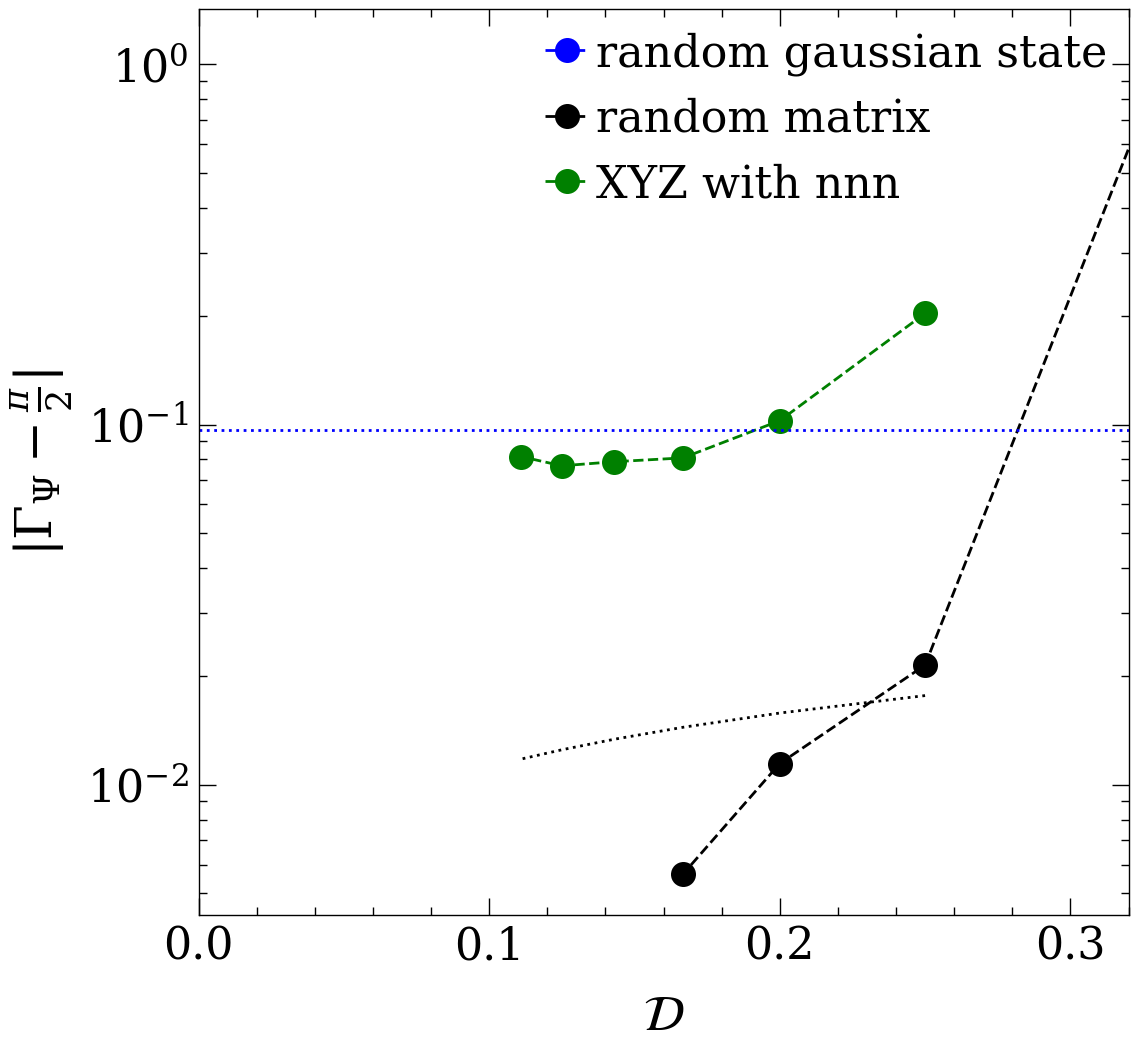

In [65]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6,6), dpi = 200)
dims = np.array(dims)

print(dims)
siz_rand = np.log2(dims).astype(int)
siz_rmt = np.log2(dims[:4]).astype(int)
print(np.array(entropy_rand_state))
axis.plot(2./(np.array(siz_rand)), page_result(f * np.array(siz_rand), (1-f)*np.array(siz_rand)) + np.array(entropy_rand_state), marker = 'o', markersize=8, ls='--', c='blue',  label='random gaussian state')
axis.plot(2./(np.array(siz_rmt)),  page_result(f * np.array(siz_rmt), (1-f)*np.array(siz_rmt)) - np.array(entropy_rmt),        marker = 'o', markersize=8, ls='--', c='black', label='random matrix')
axis.plot(2./(np.array(sizes_obc)), page_result(f * np.array(sizes_obc), (1-f)*np.array(sizes_obc)) - np.array( [np.mean(Sobo) for Sobo in S_obc]),       marker = 'o', markersize=8, ls='--', c='green', label='XYZ with nnn')

hfun.set_plot_elements(axis = axis, ylabel = "\\left|\\Gamma_\\Psi-\\frac{\\pi}{2}\\right|", xlabel = "\\mathcal{D}", settings=user_settings, 
                        font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis.legend(fontsize=16, loc='upper right', ncol=1, handletextpad=0.15, handlelength = 1., bbox_to_anchor=(1.02, 1.02))
axis.set_yscale('log')
axis.set_xscale('linear')
axis.set_xlim(0.0, 0.32)
#axis.set_ylim(None, 4e-1)
axis.axhline(y=0.0966, ls=':', c='blue')
#axis.plot(2**np.array(sizes_obc[:-1]), 0.08 / (2**sizes_obc[:-1])**0.33, ls=':', c='green')
axis.plot(2./np.array(sizes_obc), 0.5e-1 / (np.array(sizes_obc))**0.5, ls=':', c='black')

axis.tick_params(axis='both', which='major', labelsize=16, length=6)
axis.tick_params(axis='both', which='minor', labelsize=16, length=3)
#plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_gaussianityRMT.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
#plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_gaussianityRMT.png", bbox_inches = 'tight', padding=0.02, transparent=False)

[   120    496   2016   8128  32640 130816]


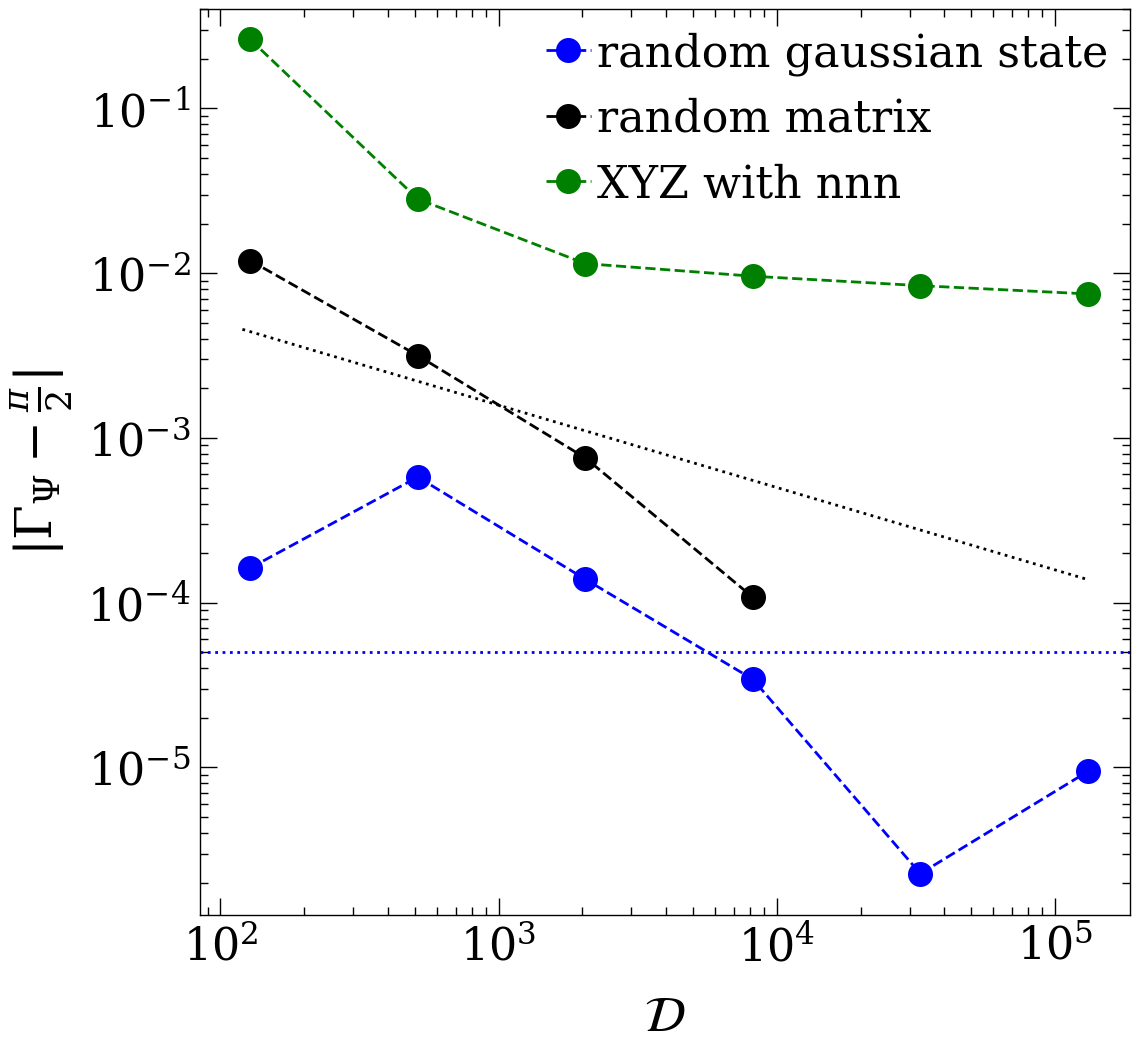

In [48]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6,6), dpi = 200)
dims = np.array(dims)

print(dims)
axis.plot(2**(np.array(siz_rand)-1), np.abs(np.array(gauss_rand_state) - np.pi / 2), marker = 'o', markersize=8, ls='--', c='blue',  label='random gaussian state')
axis.plot(2**(np.array(siz_rmt)-1),  np.abs(np.array(gauss_rmt) - np.pi / 2),        marker = 'o', markersize=8, ls='--', c='black', label='random matrix')
axis.plot(2**(np.array(sizes_obc)-1), np.abs(np.array(gauss_obc) - np.pi / 2),       marker = 'o', markersize=8, ls='--', c='green', label='XYZ with nnn')

hfun.set_plot_elements(axis = axis, ylabel = "\\left|\\Gamma_\\Psi-\\frac{\\pi}{2}\\right|", xlabel = "\\mathcal{D}", settings=user_settings, 
                        font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis.legend(fontsize=16, loc='upper right', ncol=1, handletextpad=0.15, handlelength = 1., bbox_to_anchor=(1.02, 1.02))
axis.set_yscale('log')
axis.set_xscale('log')
#axis.set_xlim(0.0, 0.127)
axis.set_ylim(None, 4e-1)
axis.axhline(y=1/2e4, ls=':', c='blue')
#axis.plot(2**np.array(sizes_obc[:-1]), 0.08 / (2**sizes_obc[:-1])**0.33, ls=':', c='green')
axis.plot(dims, 0.5e-1 / (dims)**0.5, ls=':', c='black')

axis.tick_params(axis='both', which='major', labelsize=16, length=6)
axis.tick_params(axis='both', which='minor', labelsize=16, length=3)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_gaussianityRMT.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
plt.savefig("../swap results/MAXIMAL_ENTROPY/Fig_gaussianityRMT.png", bbox_inches = 'tight', padding=0.02, transparent=False)